In [1]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from barplots import barplots

# Load the datasets

## Epigenomic data and labels

In [2]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters

In [3]:
cell_line = 'K562'
window_size = 256
enhancers_epigenomes, enhancers_labels = active_enhancers_vs_inactive_enhancers(
                                            binarize=True,
                                            cell_line=cell_line,
                                            window_size=window_size,
                                            min_active_tpm_value=0,
                                            max_inactive_tpm_value=0
                                         )
promoters_epigenomes, promoters_labels = active_promoters_vs_inactive_promoters(
                                            binarize=True,
                                            cell_line=cell_line,
                                            window_size=window_size,
                                            min_active_tpm_value=5,
                                            max_inactive_tpm_value=0
                                         )

In [4]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

## Sequence data

In [5]:
from ucsc_genomes_downloader import Genome

In [6]:
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|                                                      | 0/25 [00:00<…

In [7]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# Preprocessing

## Rate between featurs and samples

In [10]:
for region, data in epigenomes.items():
    print(
        f"The rate between features and samples for {region.upper()} data is: {data.shape[1]/data.shape[0]}\n"
        f"Number of features: {data.shape[1]}\n"
        f"Number of samples: {data.shape[0]}\n"
    )
    print("="*80)

The rate between features and samples for PROMOTERS data is: 0.005439330543933054
Number of features: 429
Number of samples: 78870

The rate between features and samples for ENHANCERS data is: 0.006778857549182271
Number of features: 429
Number of samples: 63285



## Nan detection

In [11]:
for region, data in epigenomes.items():
    print("\n".join((
        f"Nan values report for {cell_line} {region.upper()} data:",
        f"In the document there are {data.isna().values.sum()} NaN values out of {data.values.size} values.",
        f"The sample (row) with most values has {data.isna().sum(axis=1).max()} NaN values out of {data.shape[1]} values.",
        f"The feature (column) with most values has {data.isna().sum().max()} NaN values out of {data.shape[0]} values."
    )))
    print("="*80)

Nan values report for K562 PROMOTERS data:
In the document there are 378 NaN values out of 33835230 values.
The sample (row) with most values has 20 NaN values out of 429 values.
The feature (column) with most values has 230 NaN values out of 78870 values.
Nan values report for K562 ENHANCERS data:
In the document there are 102 NaN values out of 27149265 values.
The sample (row) with most values has 7 NaN values out of 429 values.
The feature (column) with most values has 93 NaN values out of 63285 values.


## Data Imputation

In [12]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [13]:
for region, x in epigenomes.items():
    epigenomes[region] = knn_imputation(x)

In [14]:
for region, data in epigenomes.items():
    print("\n".join((
        f"Nan values report for {cell_line} {region.upper()} data:",
        f"In the document there are {data.isna().values.sum()} NaN values out of {data.values.size} values.",
        f"The sample (row) with most values has {data.isna().sum(axis=1).max()} NaN values out of {data.shape[1]} values.",
        f"The feature (column) with most values has {data.isna().sum().max()} NaN values out of {data.shape[0]} values."
    )))
    print("="*80)

Nan values report for K562 PROMOTERS data:
In the document there are 0 NaN values out of 33835230 values.
The sample (row) with most values has 0 NaN values out of 429 values.
The feature (column) with most values has 0 NaN values out of 78870 values.
Nan values report for K562 ENHANCERS data:
In the document there are 0 NaN values out of 27149265 values.
The sample (row) with most values has 0 NaN values out of 429 values.
The feature (column) with most values has 0 NaN values out of 63285 values.


## Constant features

In [15]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [16]:
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        numberOfConstantFeatures = x.shape[1] - result.shape[1]
        print(f"{numberOfConstantFeatures} features in {region.upper()} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")
    print("="*80)

No constant features were found in promoters!
No constant features were found in enhancers!


## Z-scoring

In [17]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [18]:
epigenomes = {
    region:robust_zscoring(x)
    for region, x in epigenomes.items()
}

## Correlation between pairs of features

In [19]:
from scipy.stats import pearsonr, spearmanr

In [20]:
@Cache(
    cache_path="correlations/pearson/{cell_line}/{region}/{window_size}/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_pearson(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str,
    window_size: int
) -> Dict:
    """Returns Pearson correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = pearsonr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

@Cache(
    cache_path="correlations/spearmanr/{cell_line}/{region}/{window_size}/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str,
    window_size: int
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )


In [21]:
p_value_threshold = 0.01

def getCorrelatedFeatures(epigenomes):
    highly_correlated_features = {}
    for region, X in epigenomes.items():
        highly_correlated_features[region] = {}
        highly_correlated_features[region]['pearson'] = []
        highly_correlated_features[region]['spearman'] = []
        for feature_left in tqdm(X.columns, desc=f"Running Pearson and Spearman test in {region}", dynamic_ncols=True, leave=False):
            for feature_right in X.columns:
                if feature_left >= feature_right:
                    # Since the pearson correlation is simmetric, we do not need to check
                    # for the entire squared matrix of features but the upper triangular one
                    # is sufficient.
                    continue
                pearson_result = compute_pearson(
                    X,
                    feature_left,
                    feature_right,
                    cell_line=cell_line,
                    region=region,
                    window_size=window_size
                )
                spearman_result = compute_spearmanr(
                    X,
                    feature_left,
                    feature_right,
                    cell_line=cell_line,
                    region=region,
                    window_size=window_size
                )
                if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.95:
                    correlation = pearson_result["correlation"]
                    print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
                    highly_correlated_features[region]['pearson'].append((feature_left, feature_right))

                if spearman_result["p_value"] < p_value_threshold and np.abs(spearman_result["correlation"]) > 0.95:
                    correlation = spearman_result["correlation"]
                    print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
                    highly_correlated_features[region]['spearman'].append((feature_left, feature_right))
    return highly_correlated_features

In [22]:
getCorrelatedFeatures(epigenomes)

Running Pearson and Spearman test in promoters:   0%|                                          | 0/429 [00:00<…

The feature POLR2G is highly correlated with RBFOX2 (0.964188699238063).


Running Pearson and Spearman test in enhancers:   0%|                                          | 0/429 [00:00<…

The feature CBFA2T3 is highly correlated with TCF12 (0.9517533601546021).


{'promoters': {'pearson': [('POLR2G', 'RBFOX2')], 'spearman': []},
 'enhancers': {'pearson': [('CBFA2T3', 'TCF12')], 'spearman': []}}

# Visualization

## Class Balance

In [18]:
labels_binary = {}
for i, (region, y) in enumerate(labels.items()):
    y_binary = y.copy()
    #print(y.index)
    #print(y_binary.index)
    for column in y_binary.columns:
        y_binary[column] = y_binary[column].replace(False,0)
        y_binary[column] = y_binary[column].replace(True,1)
        labels_binary[region] = y_binary

C:\Users\saram\AppData\Local\Temp/ipykernel_5736/1896697193.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


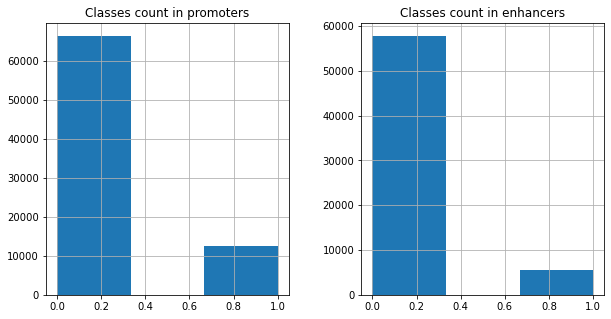

In [49]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(ncols=2, figsize=(10,5))

for axis, (region, y) in zip(axes.ravel(), labels_binary.items()):
    y.hist(ax=axis, bins=3)
    axis.set_title(f"Classes count in {region}")
    
fig.show()

## Dimensionality reduction for visualization purposes

In [64]:
# Here we need to use the cached decomposition because computing
# TSNE decompositions can get very expensive computationally
# I provide the TSNE decomposition within the course repository.
@Cache(
    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    # The import of the TSNECUDA is within the method and not
    # outside because it is hard to install the package
    from tsnecuda import TSNE
    return pd.DataFrame(
        TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            verbose=True
        ).fit_transform(X.values),
        index=X.index
    )
setattr(get_tsne_decomposition, 'name', 'TSNE' )

In [62]:
from sklearn.decomposition import PCA

@Cache(
    cache_path="decompositions/pca/{data_type}_{region}_{cell_line}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    **kwargs
) -> pd.DataFrame:
    """Return the 2D PCA decomposition of the given data."""
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )
setattr(get_pca_decomposition, 'name', 'PCA' )

In [65]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        s=3,
        alpha=0.5, edgecolors='none'
    )
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    ax.add_artist(legend1)

In [66]:
promoters = {
    'epigenomes': promoters_epigenomes,
    'label': promoters_labels
}

enhancers = {
    'epigenomes': enhancers_epigenomes,
    'label': enhancers_labels
}

Decomposition method:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

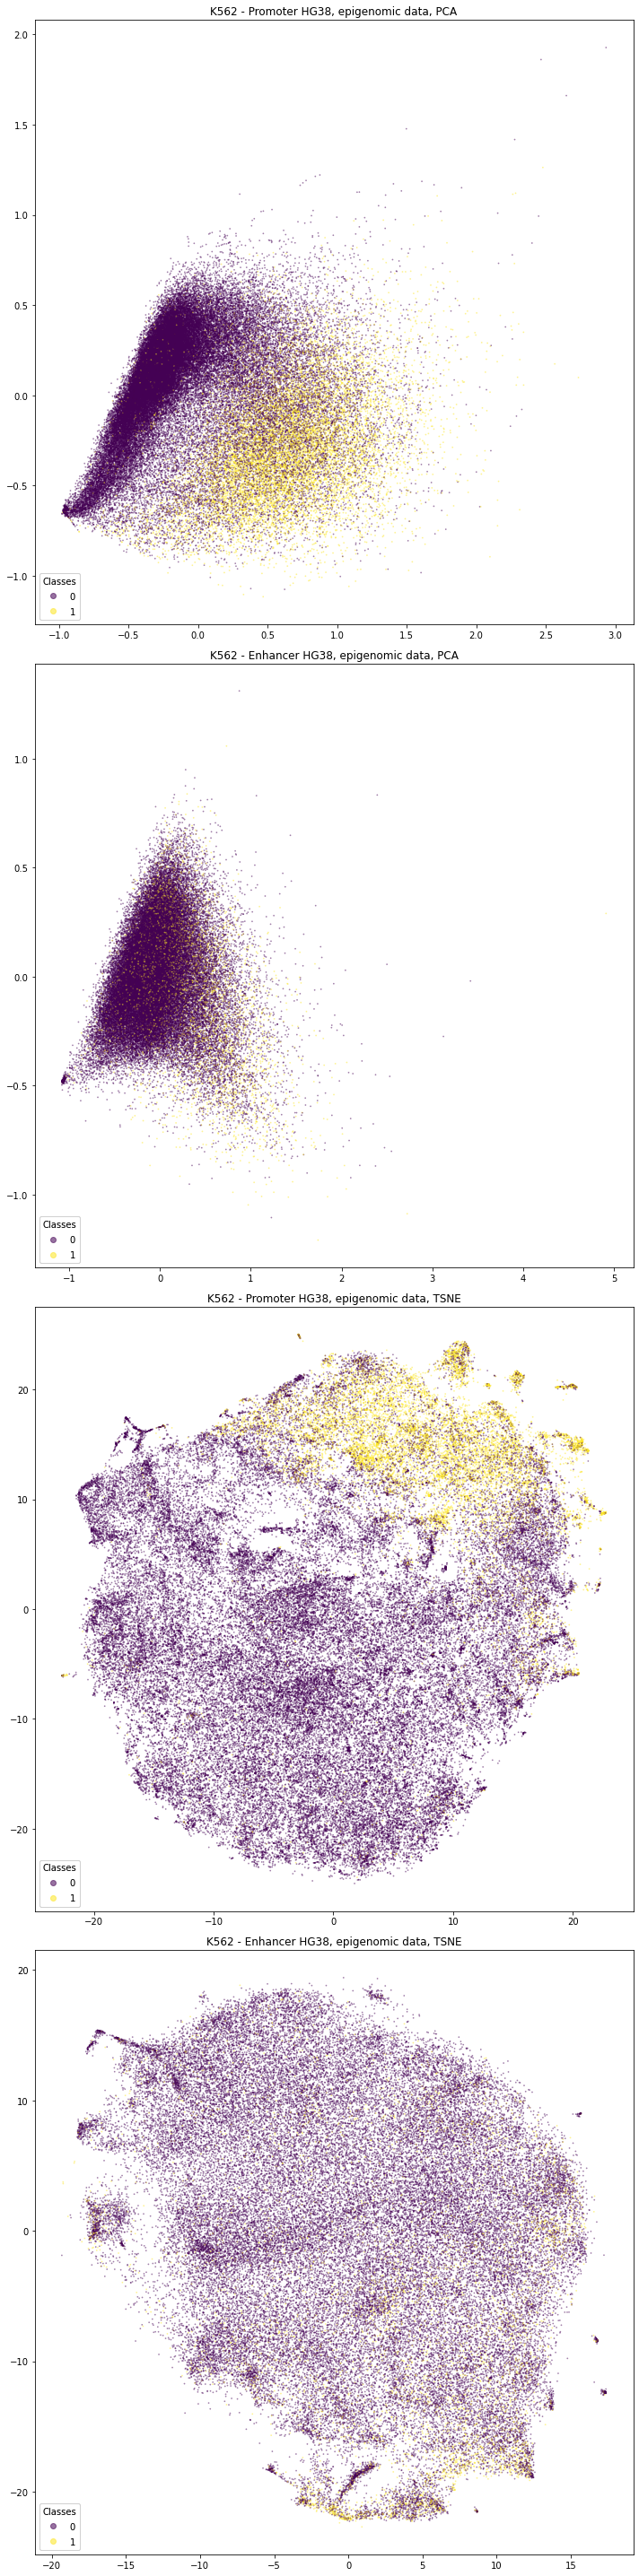

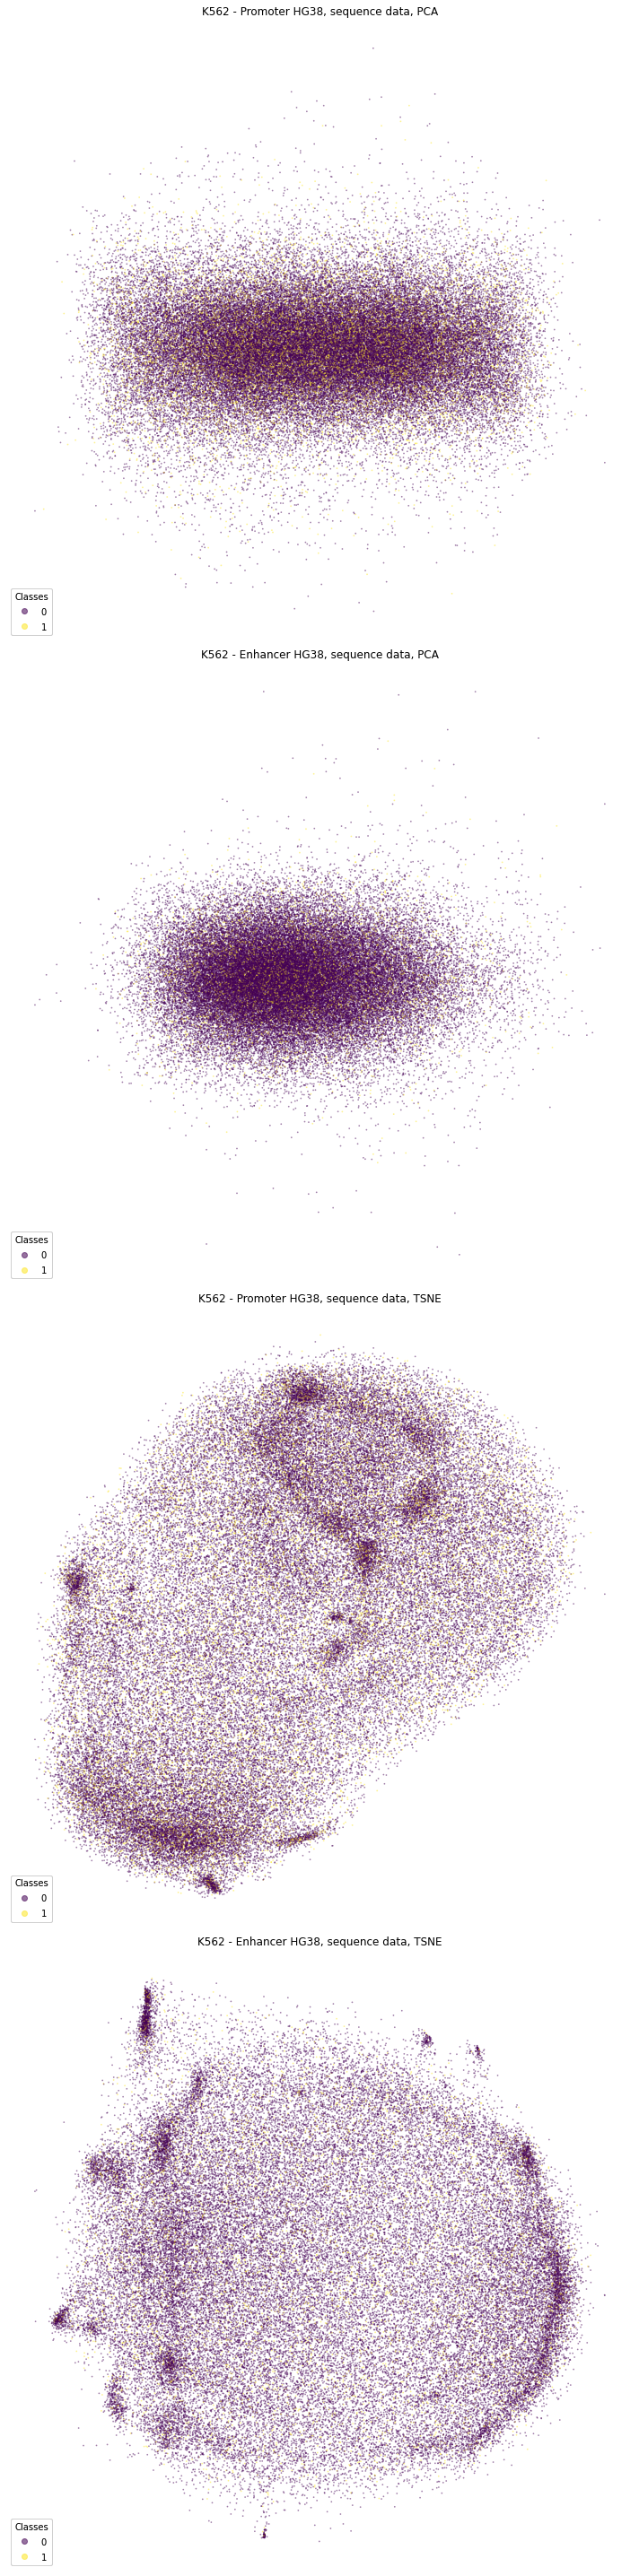

In [69]:
from keras_bed_sequence import BedSequence
from sklearn.preprocessing import MinMaxScaler

epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=4,
    figsize=(10, 40),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=4,
    figsize=(10, 40),
    squeeze=False
)


for l, decomposition_method in enumerate(tqdm((get_pca_decomposition,get_tsne_decomposition), desc="Decomposition method", leave=False)):
    for j, ((epigenomic, lab), region) in enumerate(tqdm((
        (promoters.items(), 'Promoter'),
        (enhancers.items(), 'Enhancer')
    ), desc="Task", leave=False)):
        # imputation and scaling of the data
        epigenomic = epigenomic[1]
        lab = lab[1]
        epigenomic_axes = epigenomic_axes.flatten()
        sequence_axes = sequence_axes.flatten()
        
        imputed_epigenomic = pd.DataFrame(
            MinMaxScaler().fit_transform(
                KNNImputer().fit_transform(epigenomic)
            ),
            columns=epigenomic.columns,
            index=epigenomic.index
        )
        decomposed_epigenomic = decomposition_method(
            imputed_epigenomic,
            "epigenomic",
            region,
            cell_line
        )
        scatter_with_heatmap(
            decomposition=decomposed_epigenomic,
            scores=lab.values,
            figure=epigenomic_fig,
            ax=epigenomic_axes[j + l*2]
        )
        epigenomic_axes[j + l*2].set_title(f"{cell_line} - {region} HG38, epigenomic data, {decomposition_method.name}")
        #epigenomic_axes[j + l*2].set_axis_off()


        sequence = pd.DataFrame(
            np.array(BedSequence(
                genome,
                bed=to_bed(lab),
                batch_size=1
            )).reshape(-1, 4*window_size),
            index=lab.index
        )
        decomposed_sequence = decomposition_method(
            sequence,
            "sequence",
            region,
            cell_line
            # It would be better to use the COSINE distance,
            # but it is too terribly slow to be feaseable
            # with all the considered use cases.
            # distance_metric="cosine"
        )
        
        scatter_with_heatmap(
            decomposition=decomposed_sequence,
            scores=lab.values,
            figure=sequence_fig,
            ax=sequence_axes[j + l*2]
        )
        sequence_axes[j + l*2].set_title(f"{cell_line} - {region} HG38, sequence data, {decomposition_method.name}")
        sequence_axes[j + l*2].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()

## Most differentiable features

In [55]:
from sklearn.metrics.pairwise import euclidean_distances

def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

[13782.366481461278, 6821.668663220762, 6169.097906775422, 5779.32839489611, 5511.569733283739]
[ 68 268 200 186 180]
Top 5 different features from promoters.


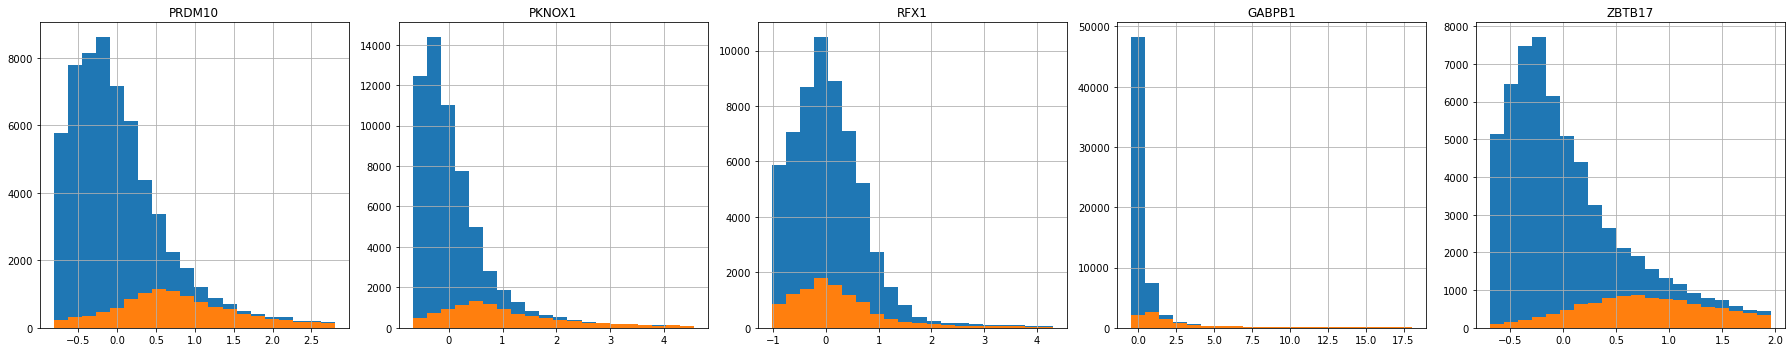

[4465.704195330363, 3238.2486360335574, 2688.950319765044, 2672.616587827016, 2590.1379191157107]
[200  71 397 222 325]
Top 5 different features from enhancers.


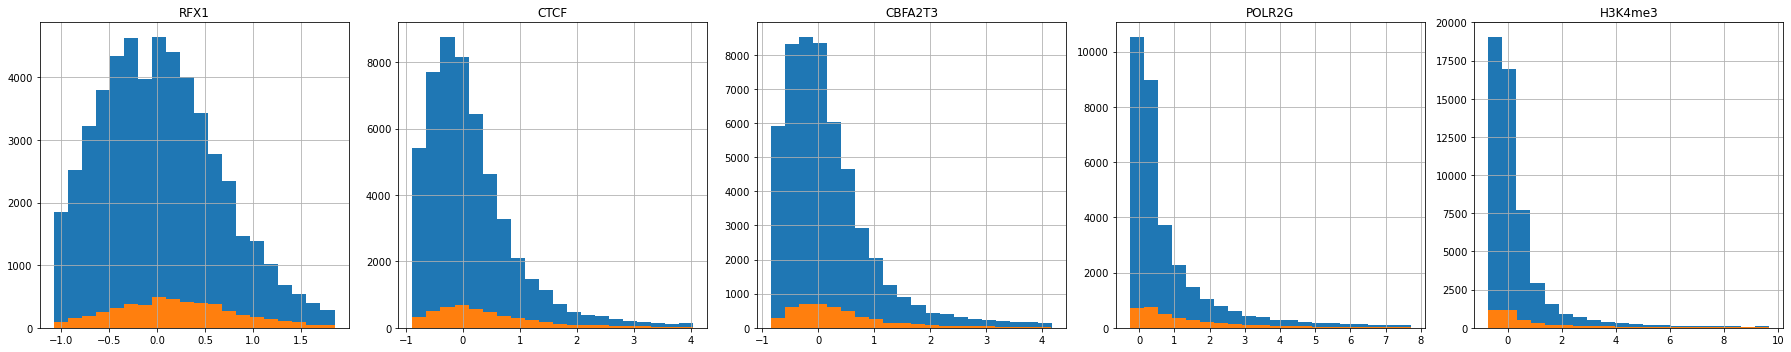

In [56]:
top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    print(sorted(np.mean(dist, axis=1), key=lambda x: -x)[:top_number])
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    print(most_distance_columns_indices)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=top_number, figsize=(25,5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        mask = ((x[column] < tail) & (x[column] > head)).values
        cleared_x = x[column][mask]
        cleared_y = labels[region].values.ravel()[mask]
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)
        axis.set_title(column)
    fig.tight_layout()
    plt.show()

# NN

In [23]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics

In [72]:
def build_binary_classification_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)

    for _ in range(2):
        hidden = Dense(
            32,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [25]:
def build_binary_classification_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="relu")(input_sequence_data)

    for _ in range(2):
        hidden = Conv1D(
            32,
            kernel_size=4,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

In [26]:
def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

In [27]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    class_weight_dict:dict = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        class_weight=class_weight_dict,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            # TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

# Here for speed sake we are only doing two holdouts
# but normally at least 10 are executed
number_of_splits = 10

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "boruta/kept_features_{_hash}.json",
        "boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

In [32]:
# Create a list to store all the computed performance
all_binary_classification_performance = []
all_binary_classification_costSensitive_performance = []

training_histories = {}
training_histories_costSensitive = {}

test_examples_enhancers = 0
test_examples_promoters = 0

# For each task
for region in tqdm(('enhancers', 'promoters'), leave=False, desc='Computing regions'):
    print(region)
    X = epigenomes[region]
    y = labels[region]
    training_histories[region] = []
    training_histories_costSensitive[region] = []
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]
    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        # Impute and normalize the epigenomic data
        
        kept_features, discarded_features = execute_boruta_feature_selection(train_X,
                                                                             train_y.values.ravel(),
                                                                             holdout_number,
                                                                             regression=False,
                                                                             task_name=region,
                                                                             max_iter= 100)
        print(f'kept_features: {len(kept_features)}')
        print(f'discarded features: {len(discarded_features)}')
        train_X = train_X.loc[:, kept_features]
        test_X = test_X.loc[:, kept_features]
            
        train_X = train_X.to_numpy()
        test_X = test_X.to_numpy()
        
        number_of_features = train_X.shape[1]
        if region == 'enhancers':
            test_examples_enhancers = test_X.shape[0]
        else:
            test_examples_promoters = test_X.shape[0]
        
        
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(number_of_features)
        cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        mmnn1 = build_binary_classification_mmnn(number_of_features, window_size)
        mmnn2 = build_binary_classification_mmnn(
            input_sequence_data=input_sequence_data,
            input_epigenomic_data=input_epigenomic_data,
            last_hidden_ffnn=last_hidden_ffnn,
            last_hidden_cnn=last_hidden_cnn
        )
        
        class_weights = class_weight.compute_class_weight('balanced',
                                                           classes=np.unique(train_y),
                                                           y=train_y)

        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
        
        for model, train_sequence, test_sequence in tqdm(
            (
                (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                (mmnn1, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                (mmnn2, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
            ),
            desc="Training models",
            leave=False
        ):
            
            
            # We compute the model performance
            history, performance = train_model(
                model,
                model.name,
                region,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number
            )
            
            history_costSensitive, performance_costSensitive = train_model(
                model,
                model.name,
                region,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number,
                class_weight_dict
            )
            
            training_histories[region].append(history)
            training_histories_costSensitive[region].append(history_costSensitive)
            # We chain the computed performance to the performance list
            all_binary_classification_performance.append(performance)
            all_binary_classification_costSensitive_performance.append(performance_costSensitive)
            
        
# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)
all_binary_classification_costSensitive_performance = pd.concat(all_binary_classification_costSensitive_performance)

Computing regions:   0%|          | 0/2 [00:00<?, ?it/s]

enhancers


Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

kept_features: 212
discarded features: 217
enhancers, 0, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 218
discarded features: 211
enhancers, 1, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 209
discarded features: 220
enhancers, 2, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 214
discarded features: 215
enhancers, 3, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 201
discarded features: 228
enhancers, 4, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 210
discarded features: 219
enhancers, 5, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 210
discarded features: 219
enhancers, 6, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 208
discarded features: 221
enhancers, 7, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 207
discarded features: 222
enhancers, 8, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 215
discarded features: 214
enhancers, 9, text examples: 12657
[0.54781536 5.72844535]
{0: 0.5478153606440304, 1: 5.728445349626613}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

promoters


Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

kept_features: 378
discarded features: 51
promoters, 0, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 371
discarded features: 58
promoters, 1, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 371
discarded features: 58
promoters, 2, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 376
discarded features: 53
promoters, 3, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 381
discarded features: 48
promoters, 4, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 372
discarded features: 57
promoters, 5, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 375
discarded features: 54
promoters, 6, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 379
discarded features: 50
promoters, 7, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 375
discarded features: 54
promoters, 8, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

kept_features: 375
discarded features: 54
promoters, 9, text examples: 15774
[0.59438175 3.14881725]
{0: 0.59438174727283, 1: 3.1488172472302627}


Training models:   0%|          | 0/4 [00:00<?, ?it/s]

## Confusion matrices

In [44]:
from scipy.sparse import coo_matrix
from sklearn import metrics

In [45]:
test_X_enhancers_numExamples = 12657
test_X_enhancers_numFeatures = 429
test_X_promoter_numExamples = 15774
test_X_promoter_numFeatures = 429

enhancers
Base TP+TN = 11567.999889346305
CostSensitive TP+TN = 9769.999714817852


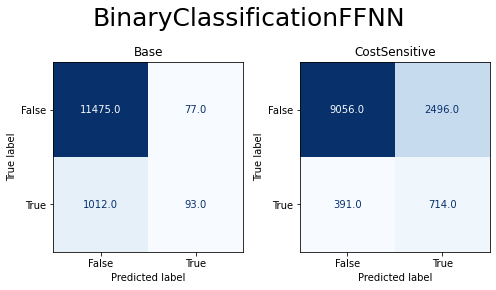

Base TP+TN = 11552.000111281872
CostSensitive TP+TN = 9634.999896962196


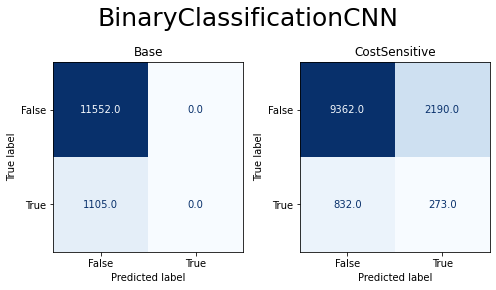

Base TP+TN = 11259.000170957297
CostSensitive TP+TN = 10283.999642316252


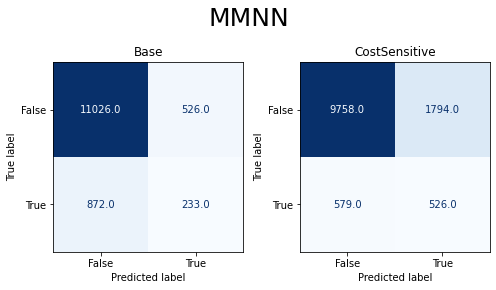

Base TP+TN = 11221.000355472788
CostSensitive TP+TN = 10226.999742273241


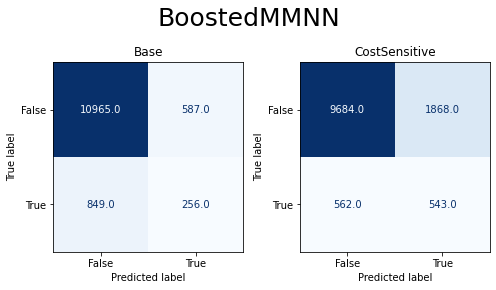

promoters
Base TP+TN = 11597.837106540797
CostSensitive TP+TN = 11401.249690711498


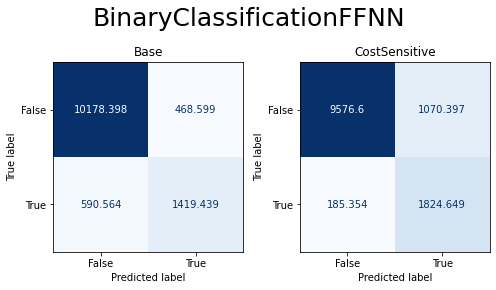

Base TP+TN = 10779.392653863877
CostSensitive TP+TN = 9079.916785106063


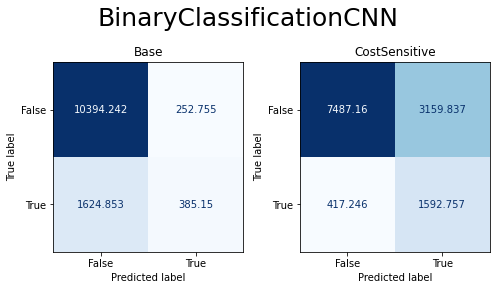

Base TP+TN = 11735.04651452601
CostSensitive TP+TN = 11547.285765767097


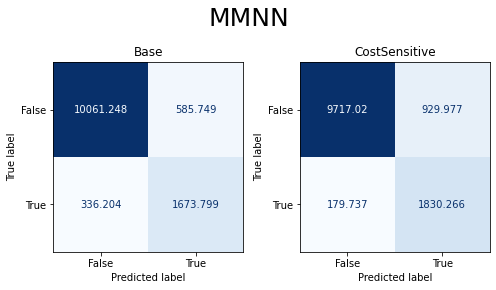

Base TP+TN = 11703.752962097526
CostSensitive TP+TN = 11521.608840376139


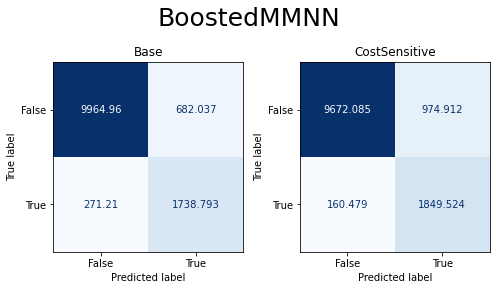

In [46]:
names = ['Base', 'CostSensitive']

for region in all_binary_classification_performance.task.unique():
    print(region)
    for model in all_binary_classification_performance.model_name.unique():
        fig, axes = plt.subplots(nrows=1, ncols=2 ,figsize=(7,7))
        for i, performance_ax in enumerate(zip([all_binary_classification_performance, all_binary_classification_costSensitive_performance],axes.flatten())):
            confusion_matrix = [] #TN, FP, FN, TP
            performance = performance_ax[0]
            ax = performance_ax[1]
            for metric in ['true_negatives_over_total', 'false_positives_over_total', \
                           'false_negatives_over_total', 'true_positives_over_total']:
                performance_metric = performance[(performance['task'] == region) & (performance['run_type'] == 'test') & \
                                          (performance['model_name'] == model)][metric]
                performance_metric = performance_metric.tolist()[len(performance_metric)-1]
                confusion_matrix.append(test_X_enhancers_numExamples*performance_metric)
            row  = np.array([0, 0, 1, 1])
            col  = np.array([0, 1, 0, 1])
            data = np.array([round(confusion_matrix[0], 3), round(confusion_matrix[1], 3),\
                             round(confusion_matrix[2], 3), round(confusion_matrix[3], 3)])
            coo = coo_matrix((data, (row, col)), shape=(2, 2)).toarray()
            cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = coo, display_labels = [False, True])
            cm_display.plot(values_format='', ax=ax, cmap='Blues',colorbar=False)
            ax.title.set_text(names[i])
            print(names[i],'TP+TN =', confusion_matrix[0]+confusion_matrix[3])
        plt.tight_layout()  
        fig.suptitle(model, y=0.75,fontsize=25,ha='center',va='bottom')
        plt.show()

## Barplots

In [47]:
all_binary_classification_performance_new = all_binary_classification_performance.copy()
all_binary_classification_performance_new['performance_type'] = 'base'
all_binary_classification_costSensitive_performance_new = all_binary_classification_costSensitive_performance.copy()
all_binary_classification_costSensitive_performance_new['performance_type'] = 'costSensitive'

In [48]:
all_performances = pd.concat([all_binary_classification_performance_new, all_binary_classification_costSensitive_performance_new], axis=0)
all_performances = all_performances.drop(columns=["holdout_number"])

Rendering barplots:   0%|                                                                       | 0/27 [00:00<…

((<Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 

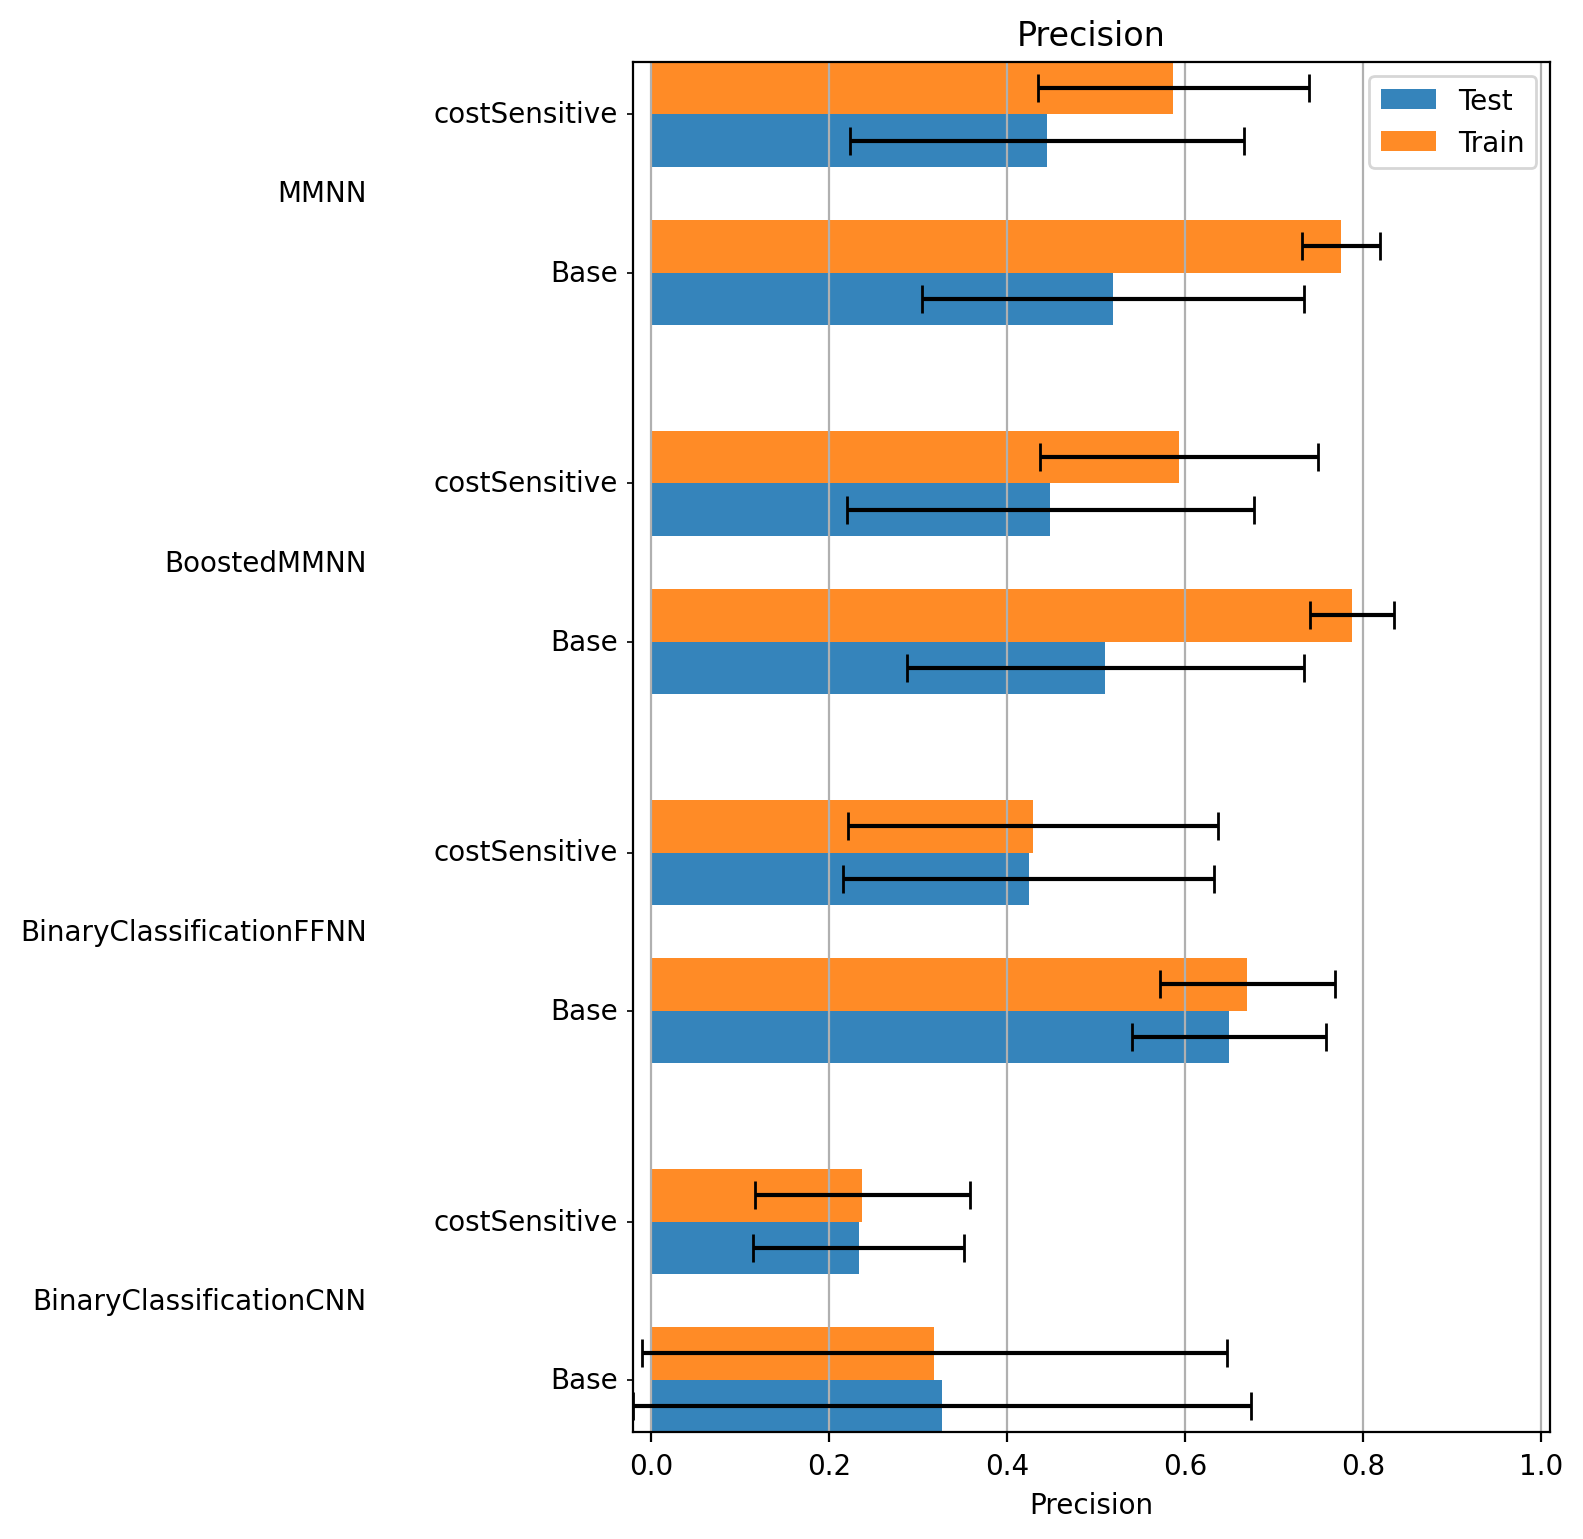

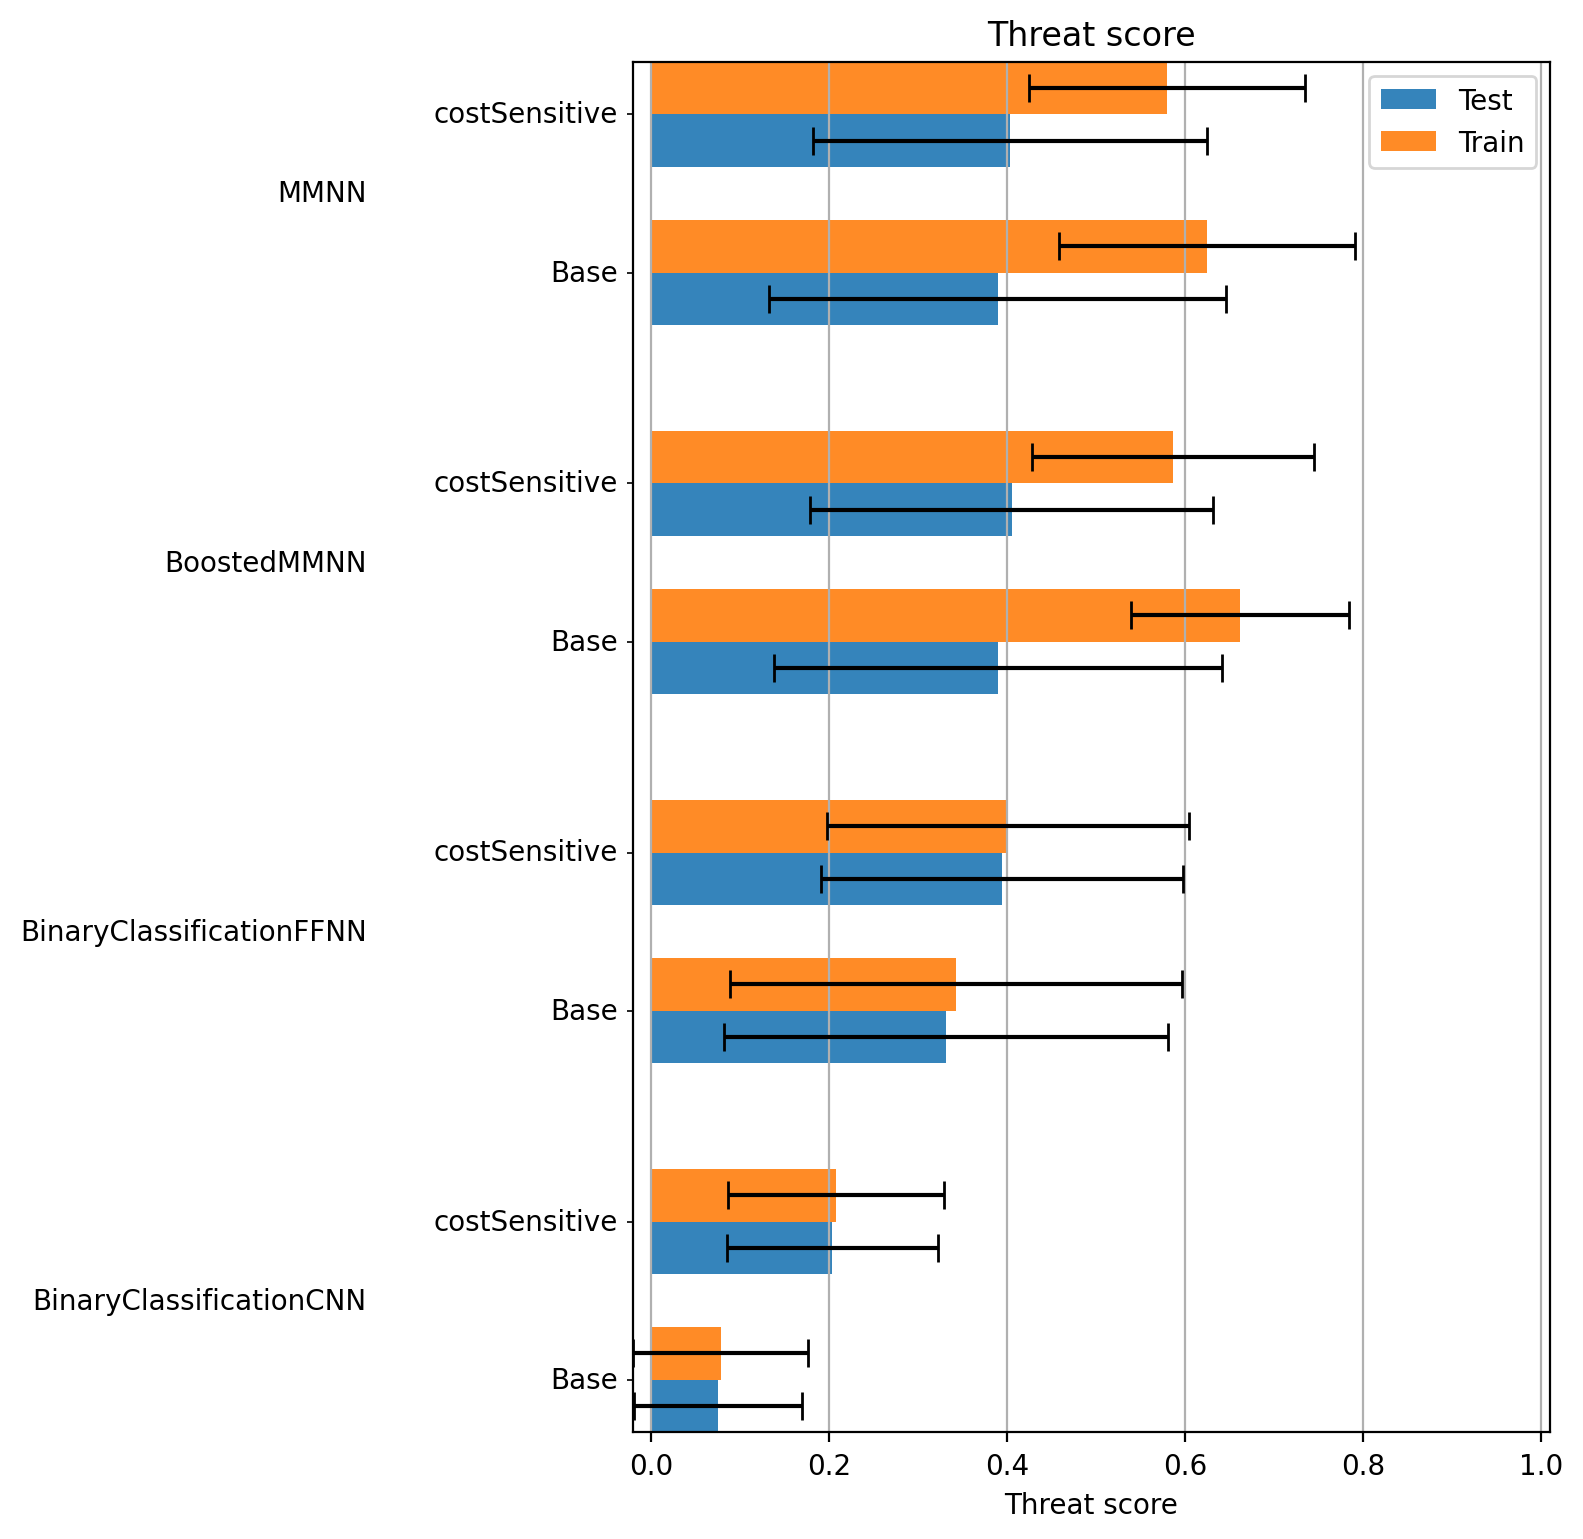

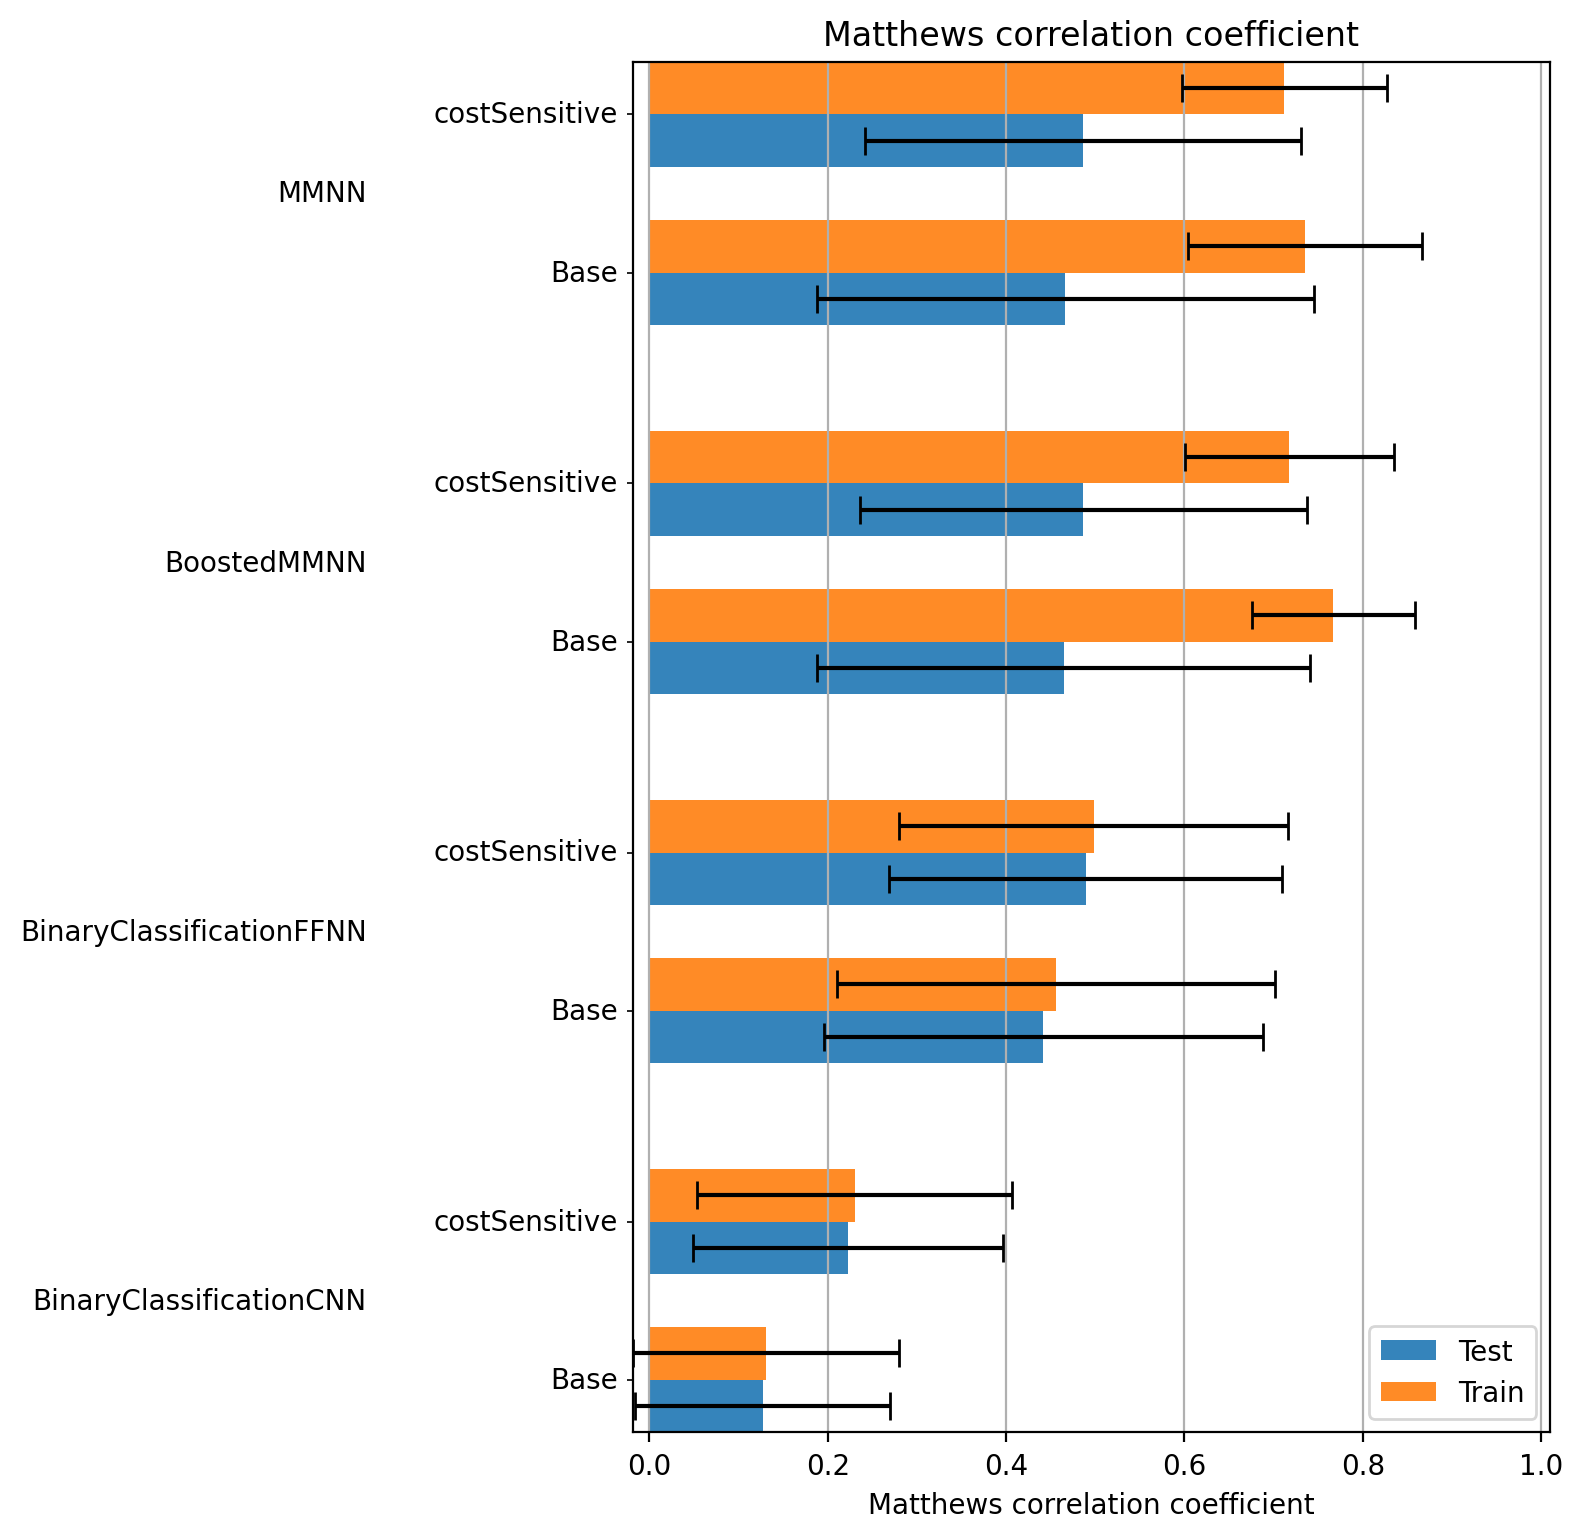

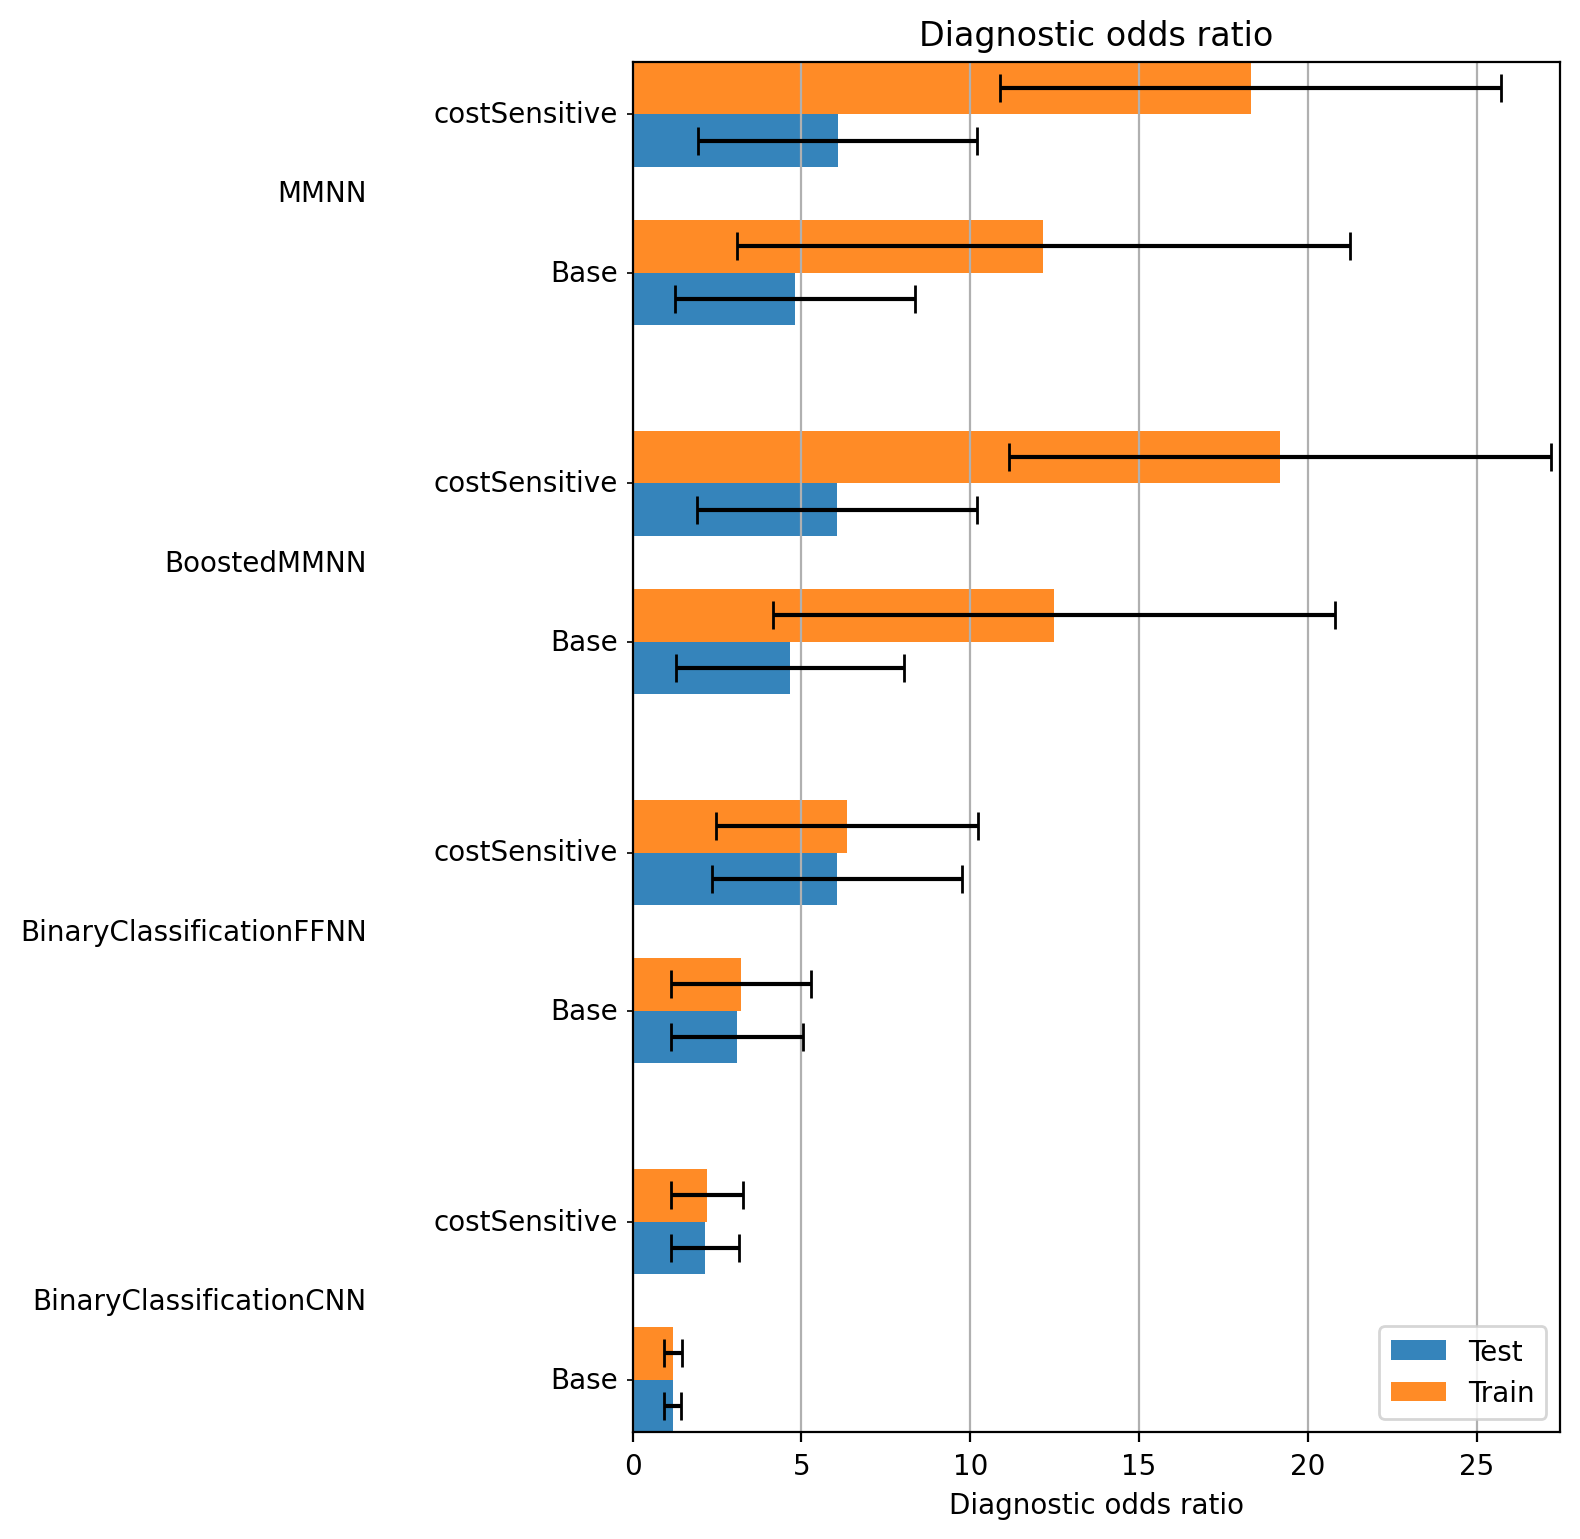

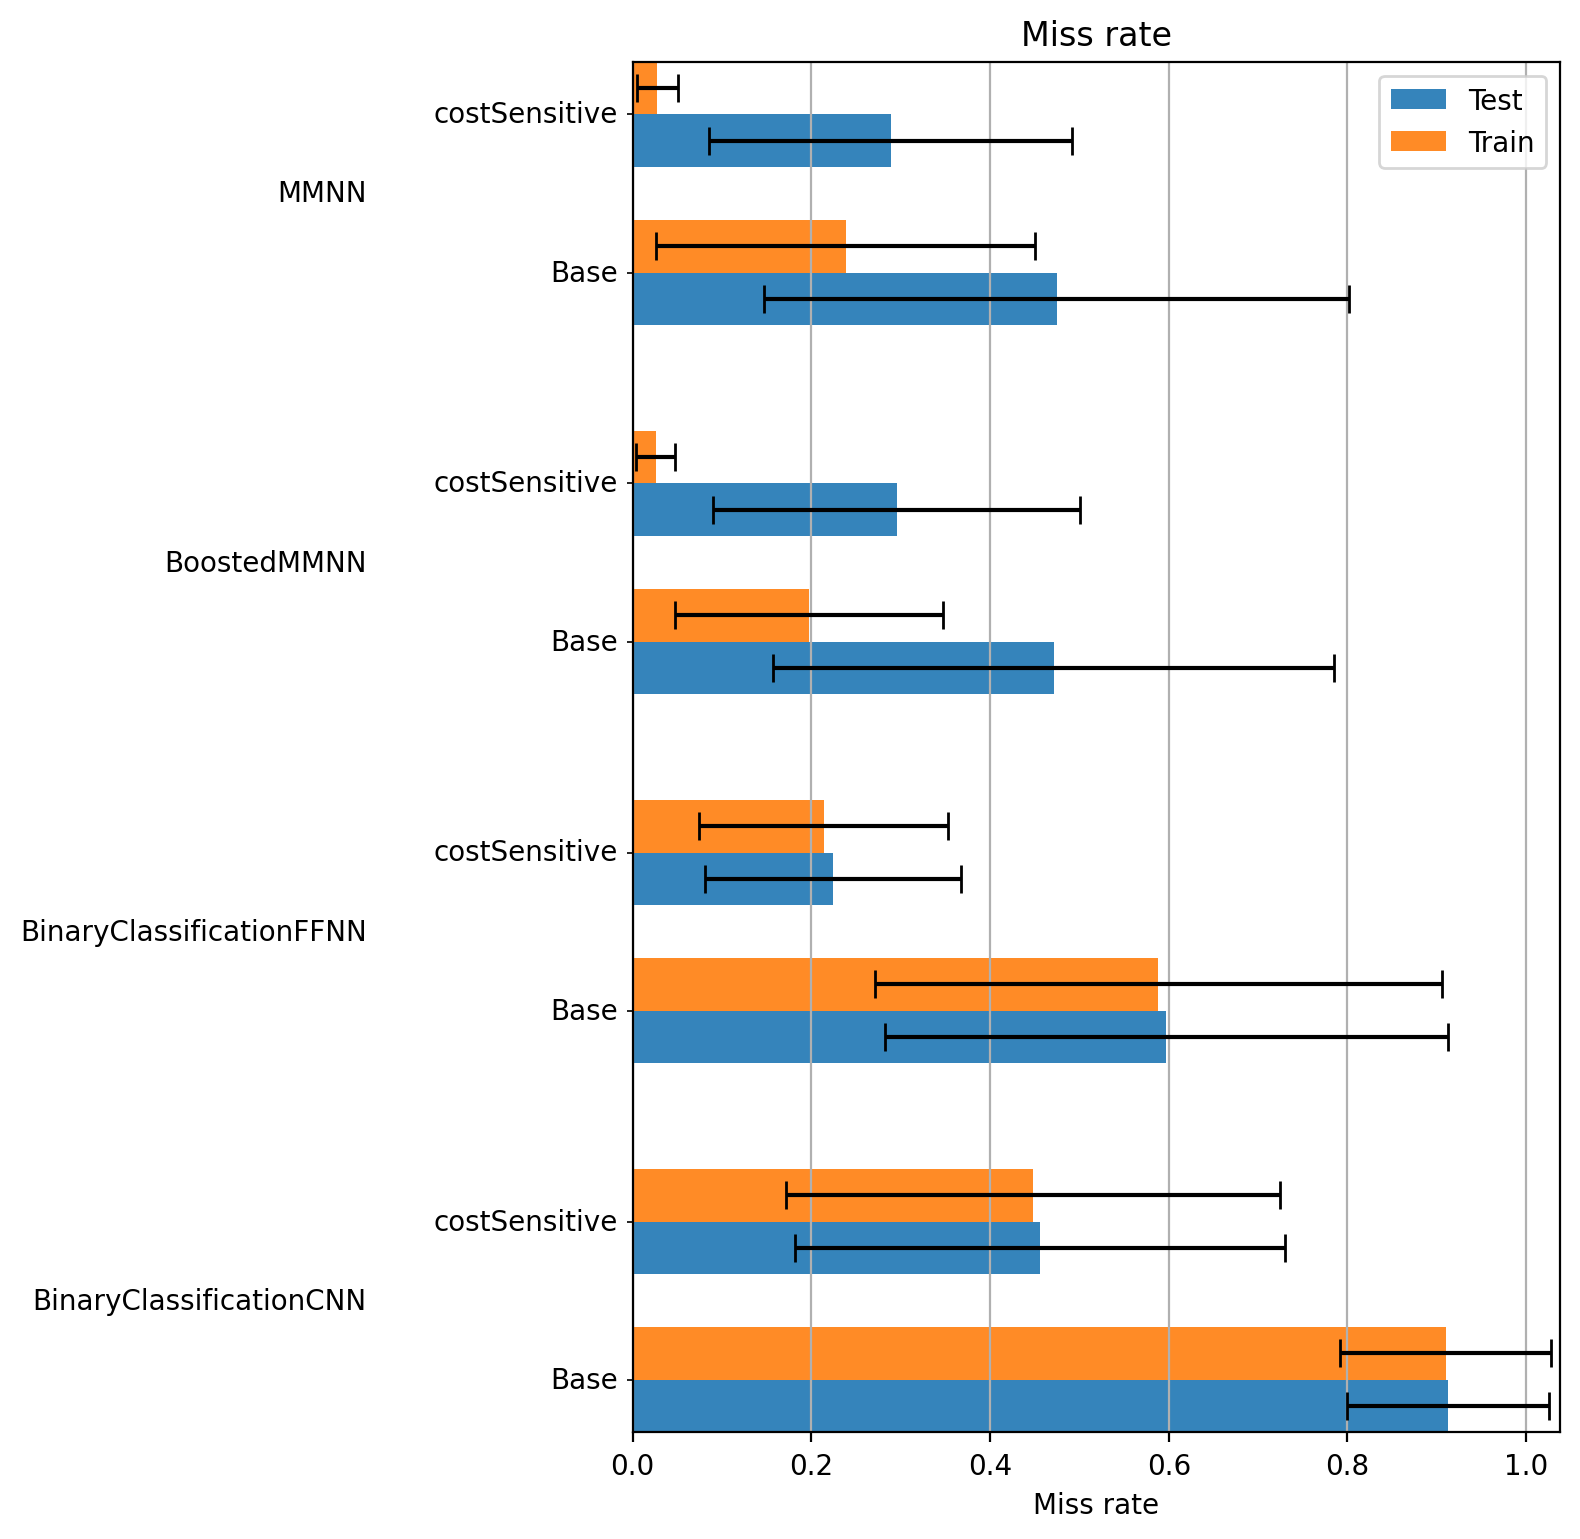

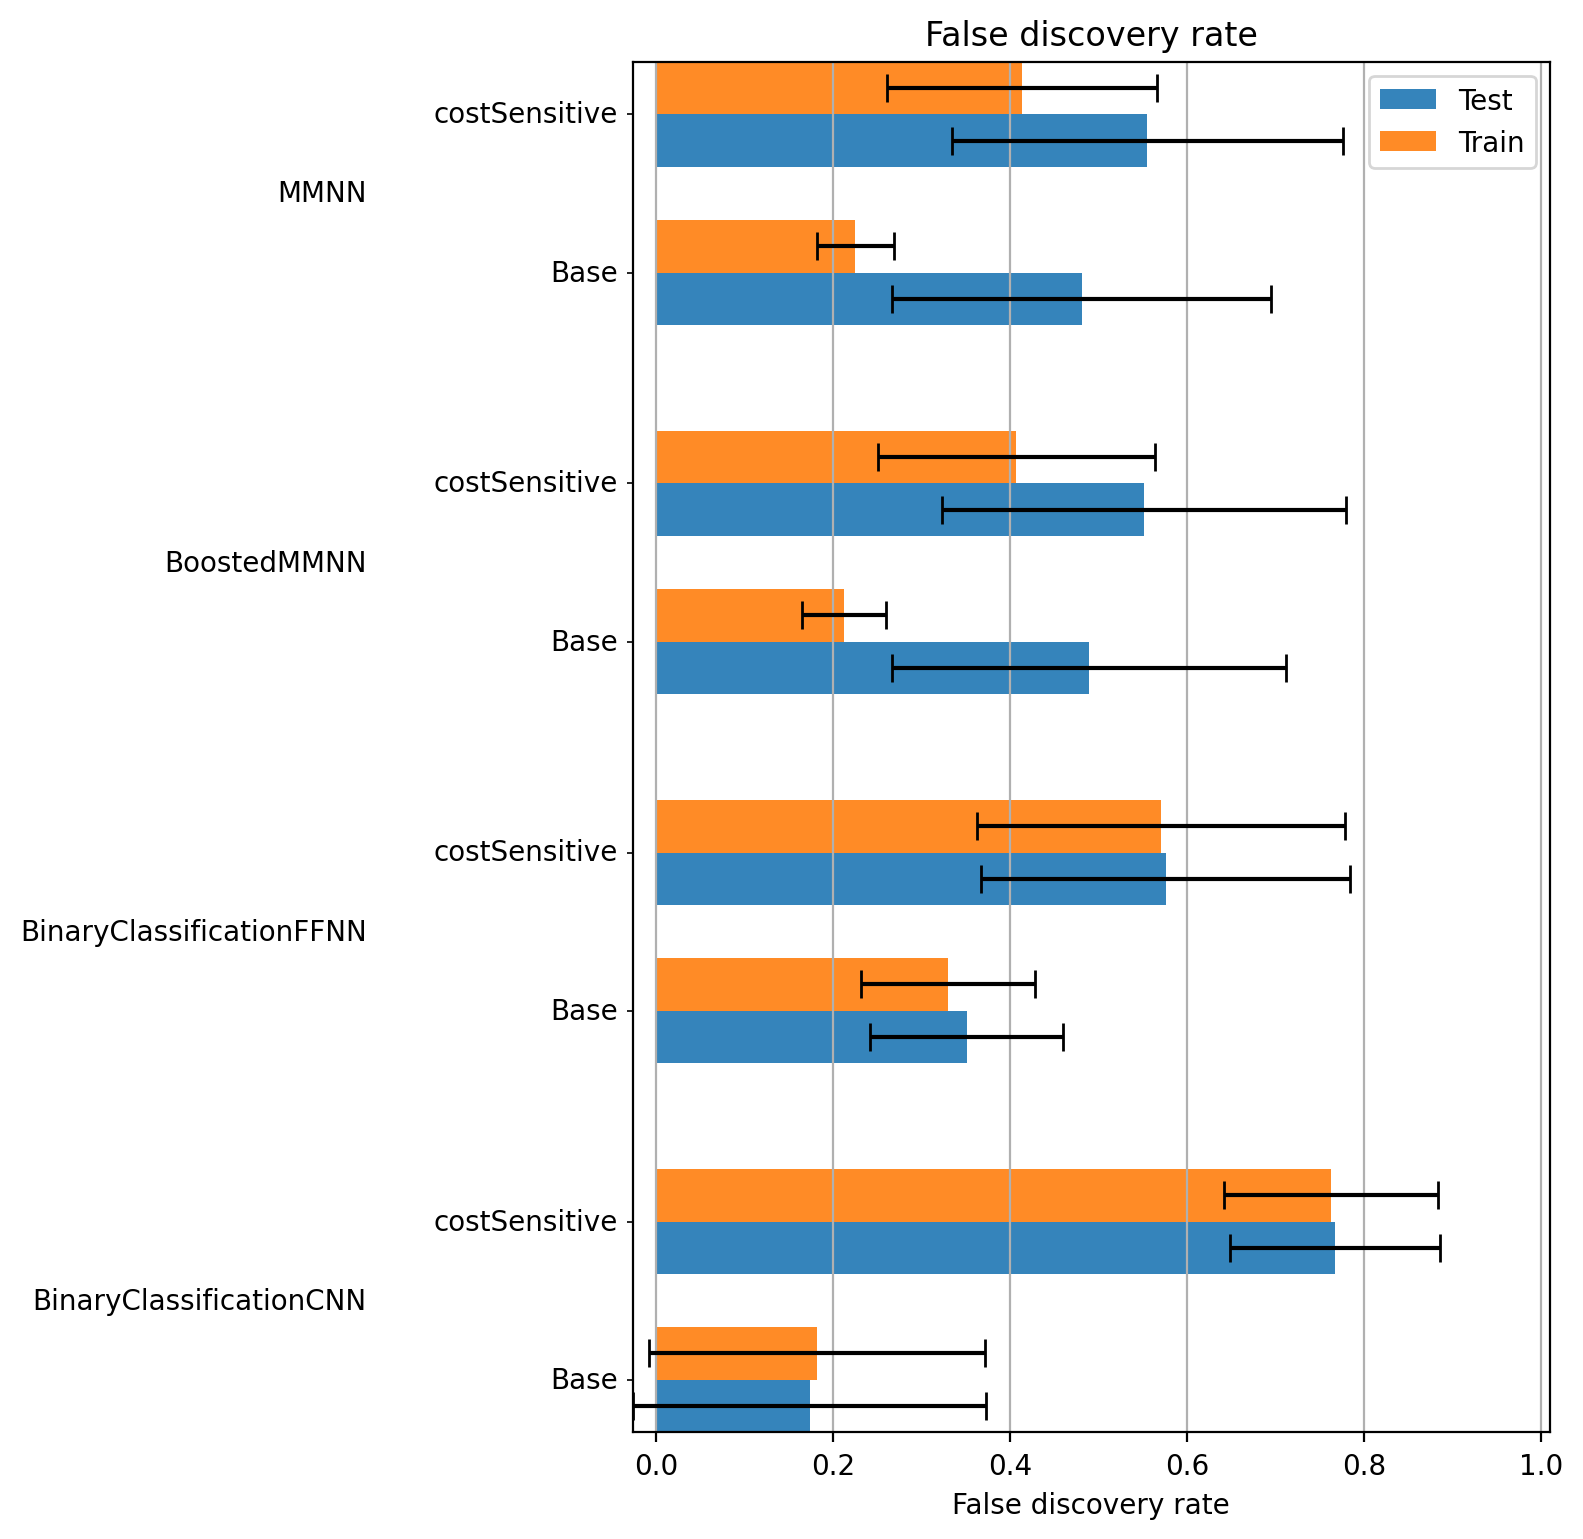

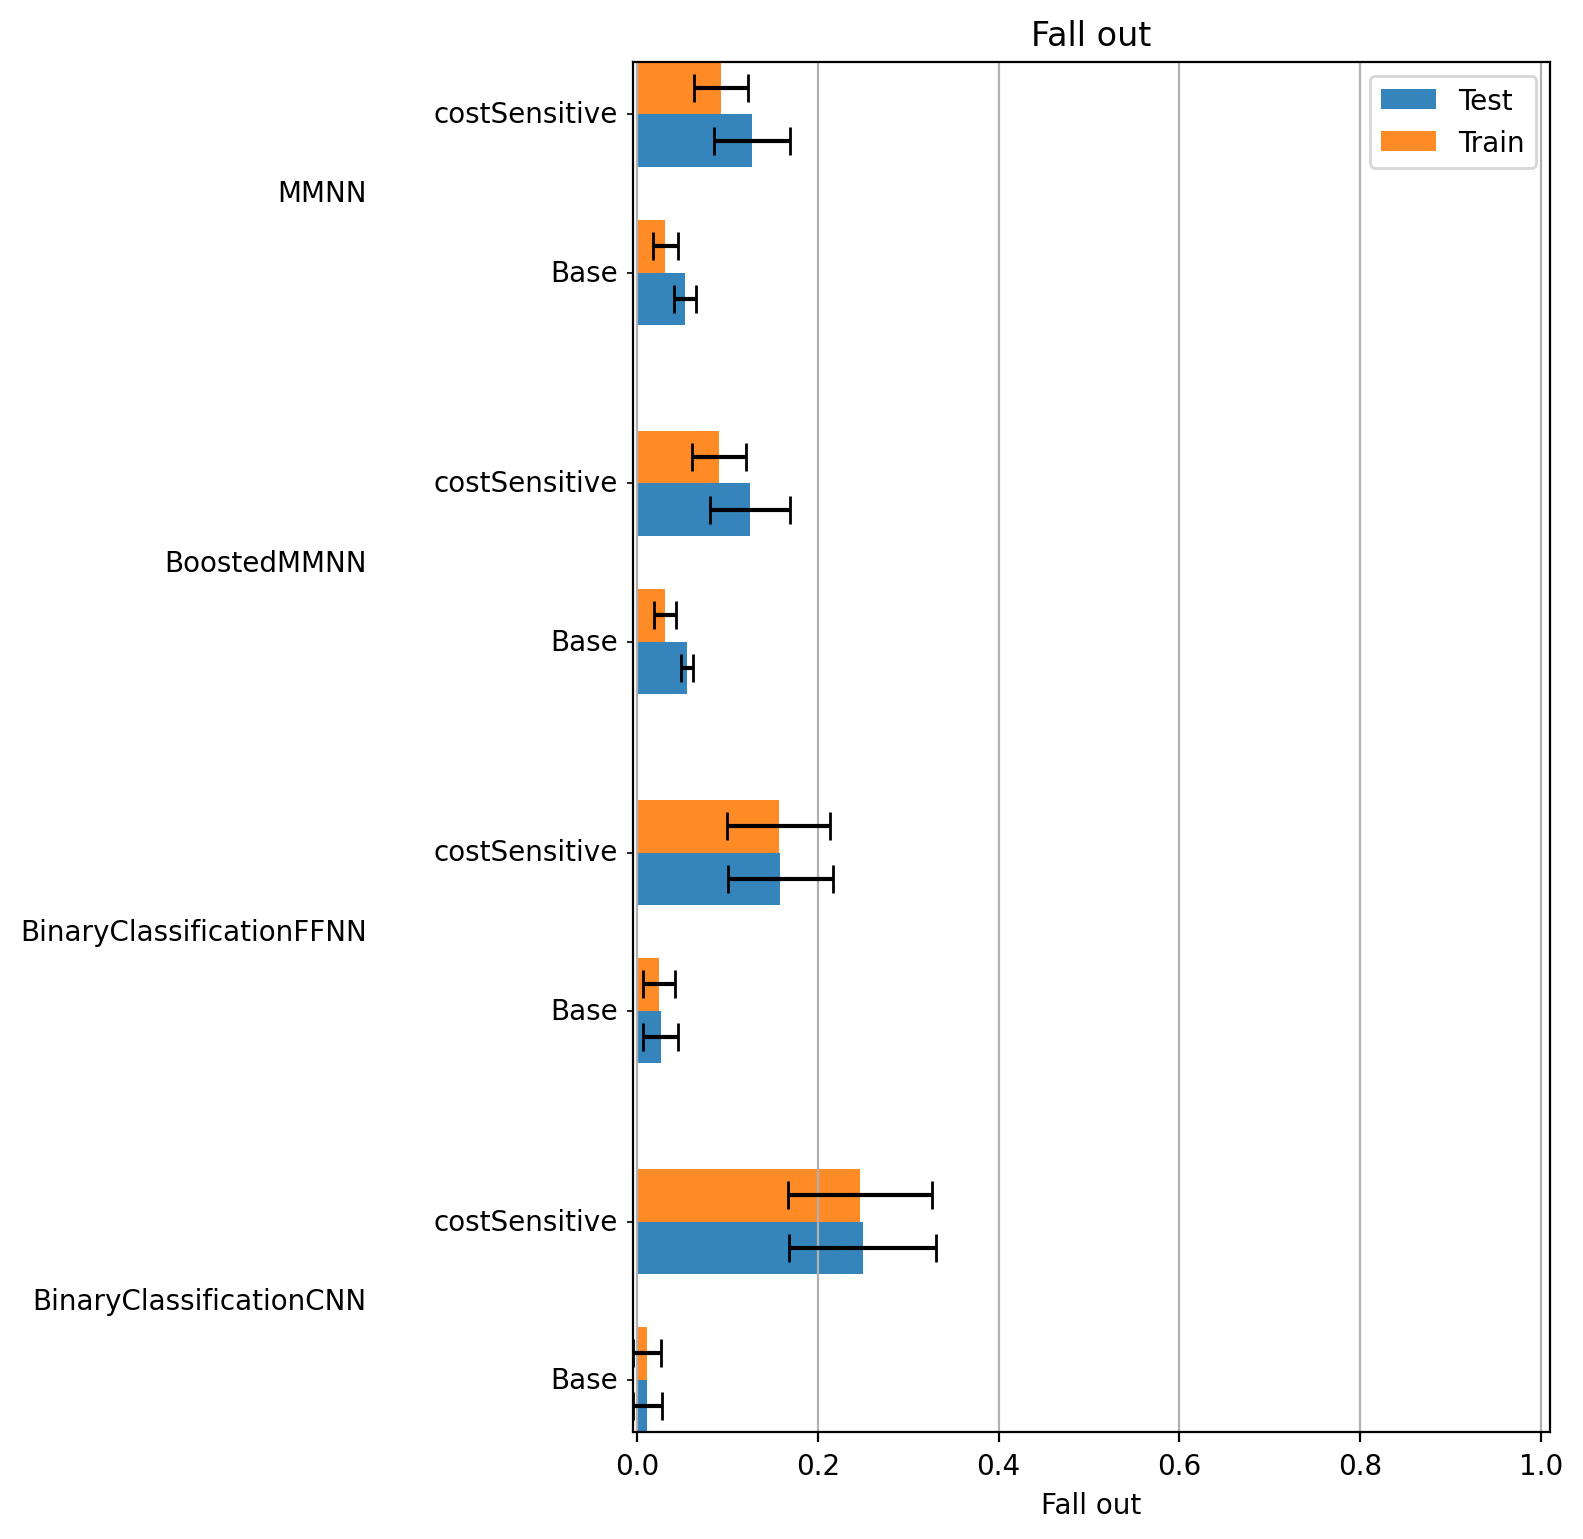

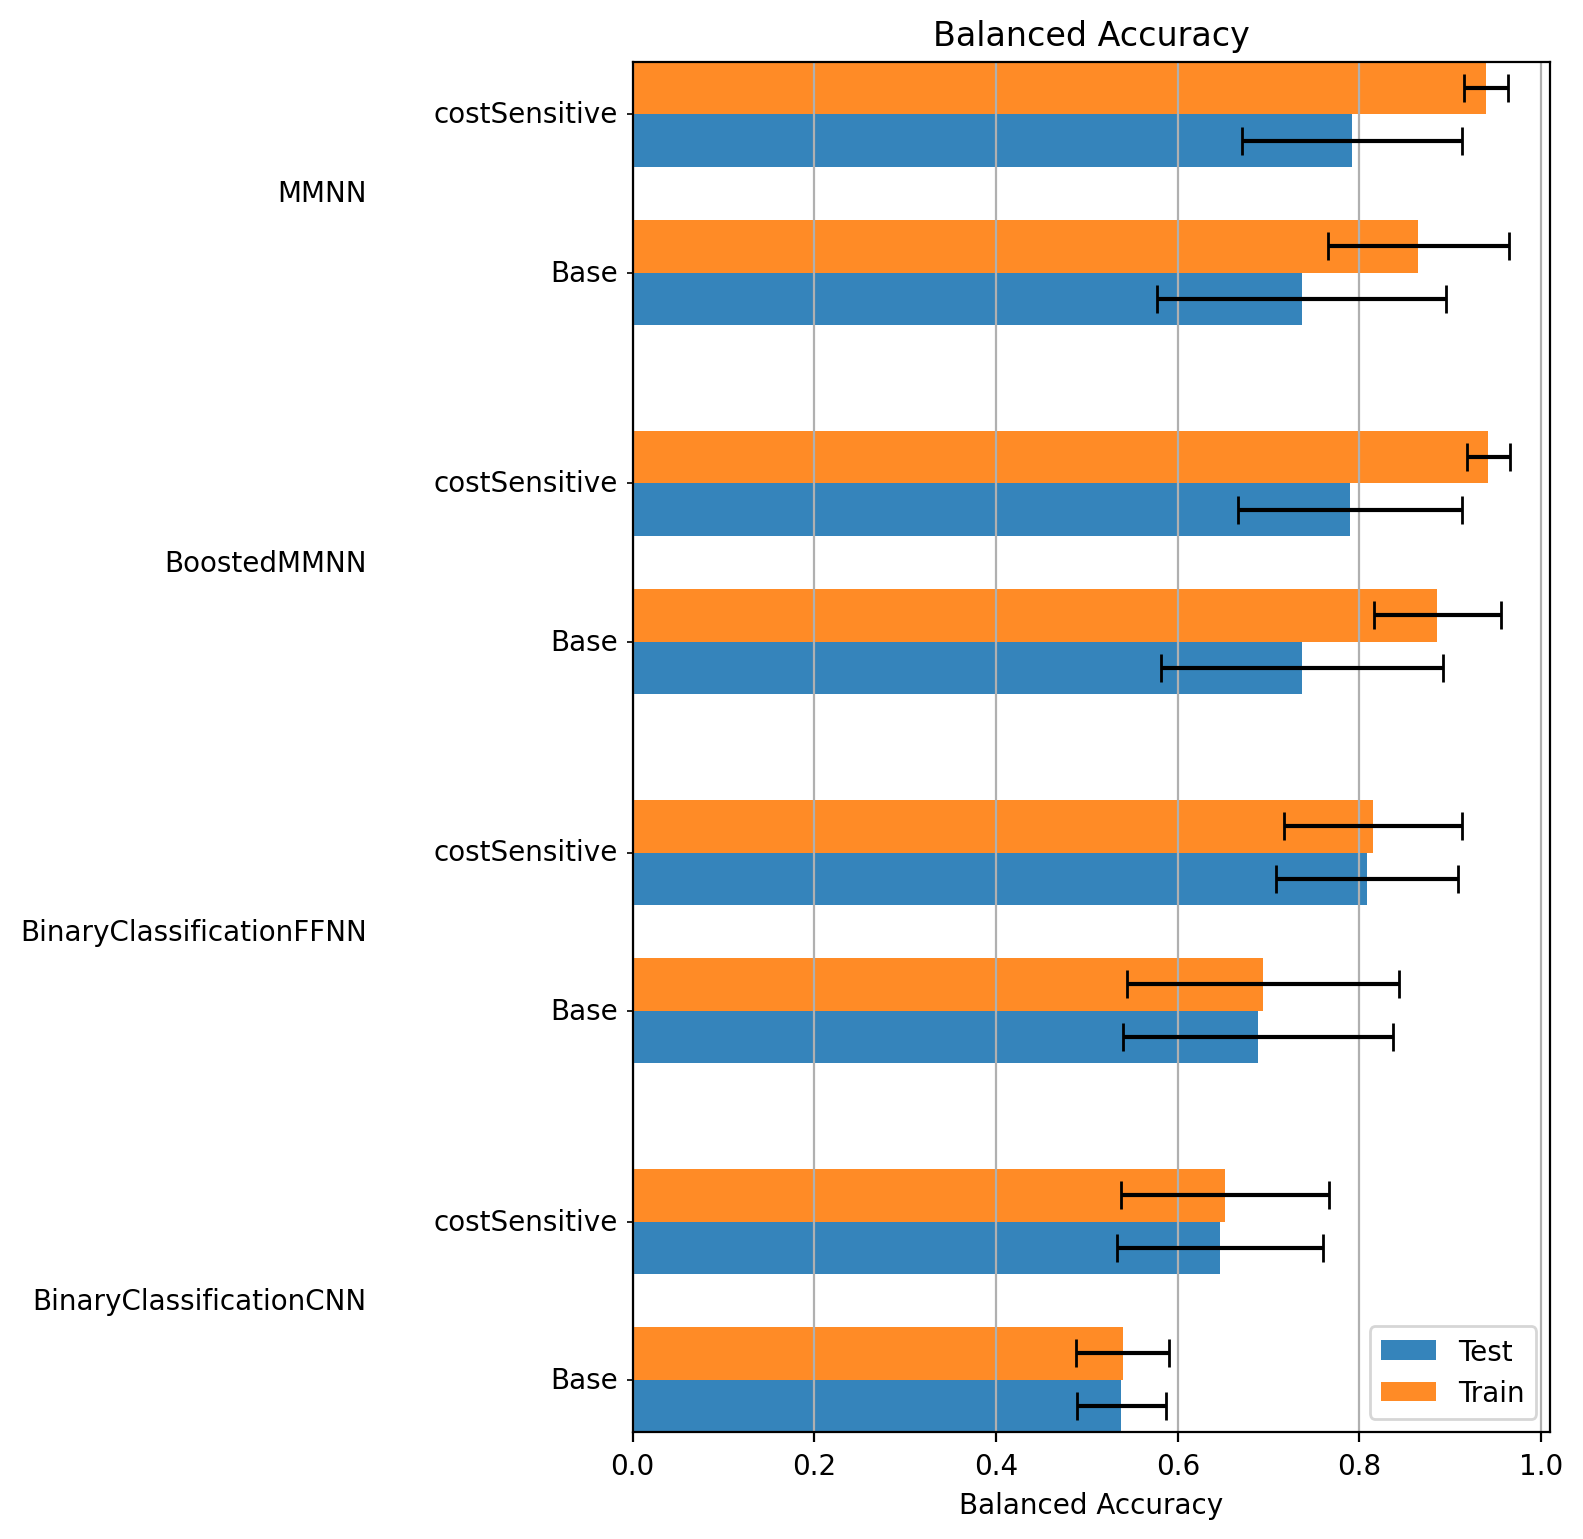

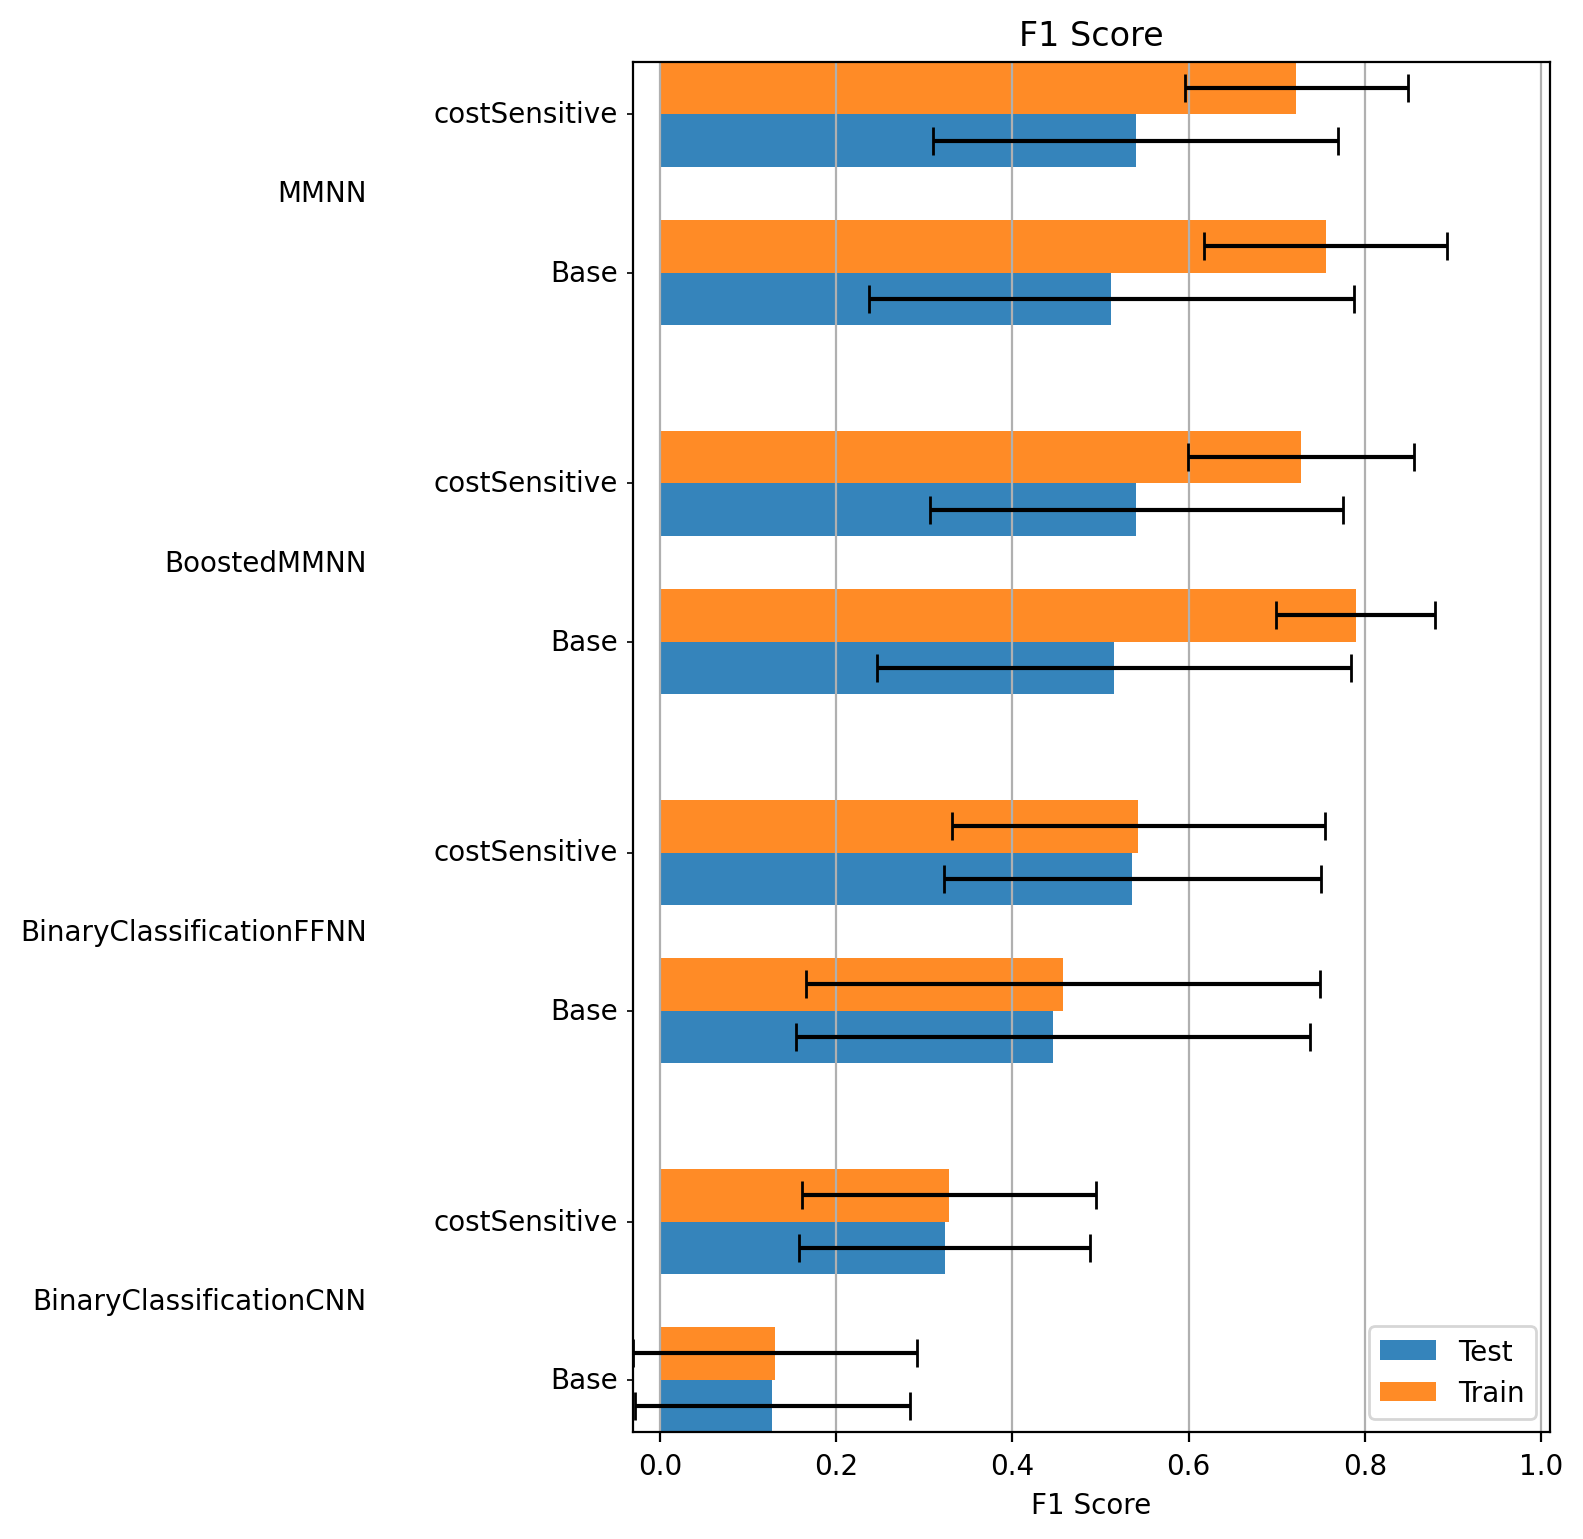

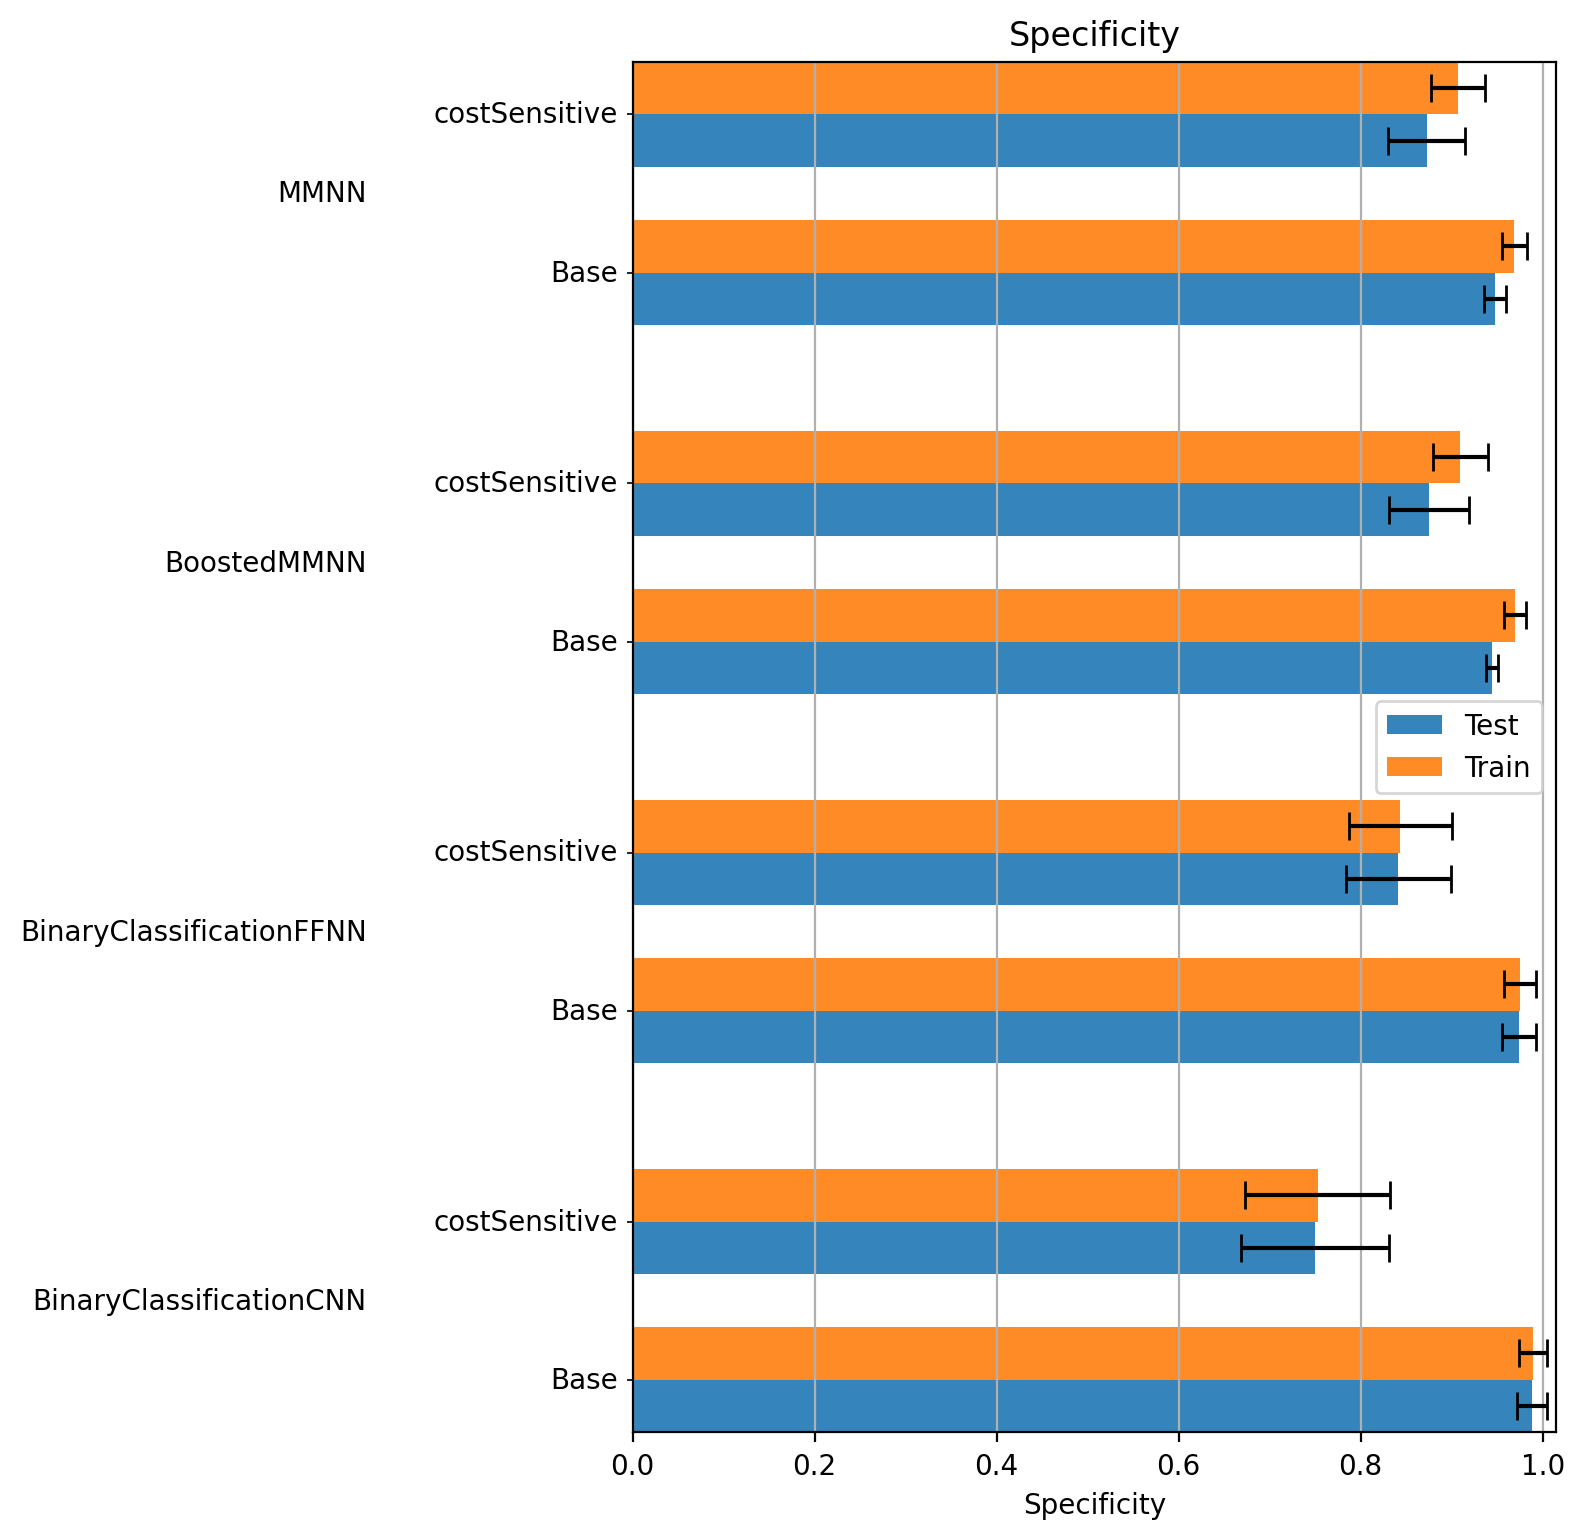

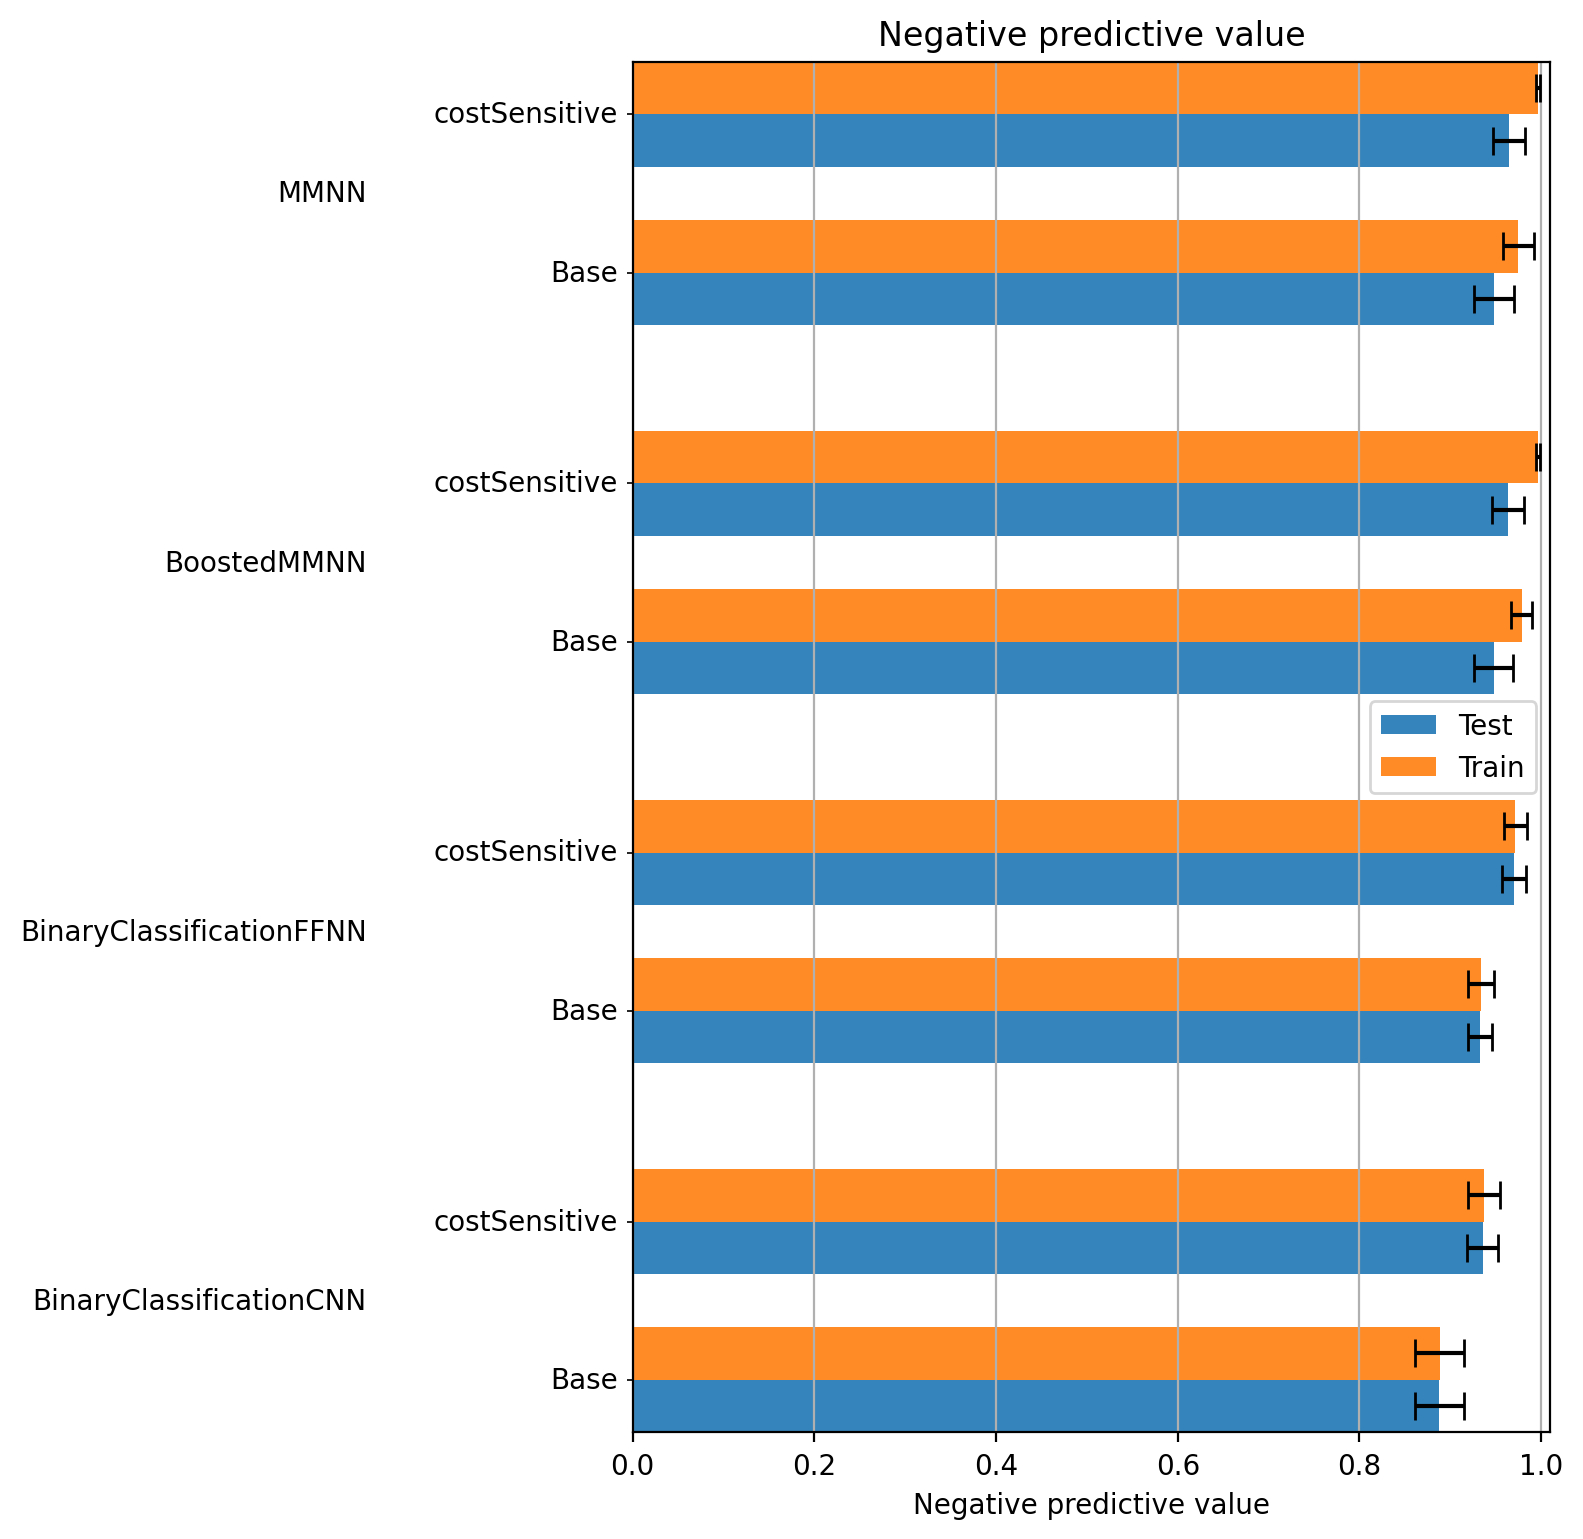

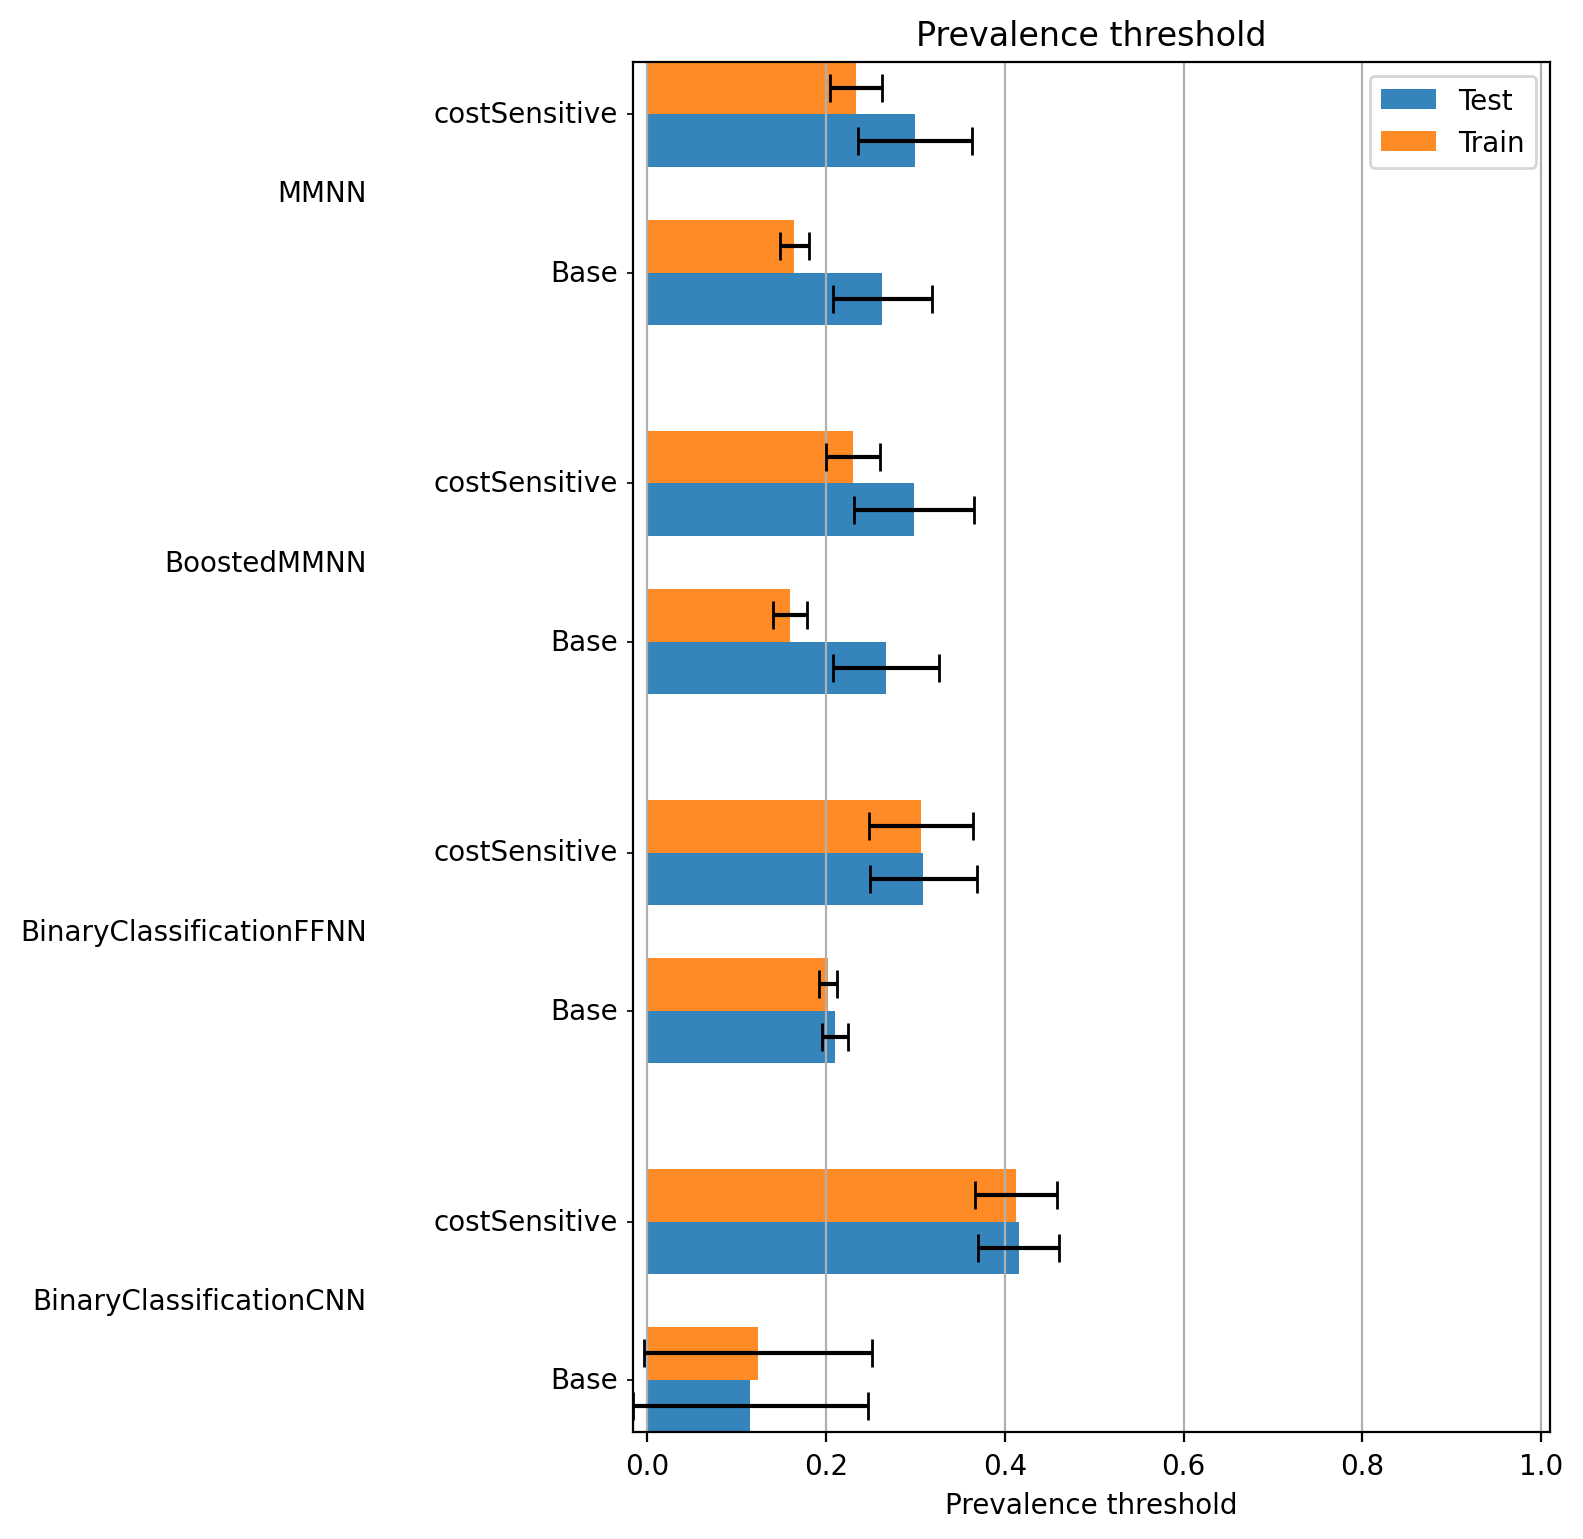

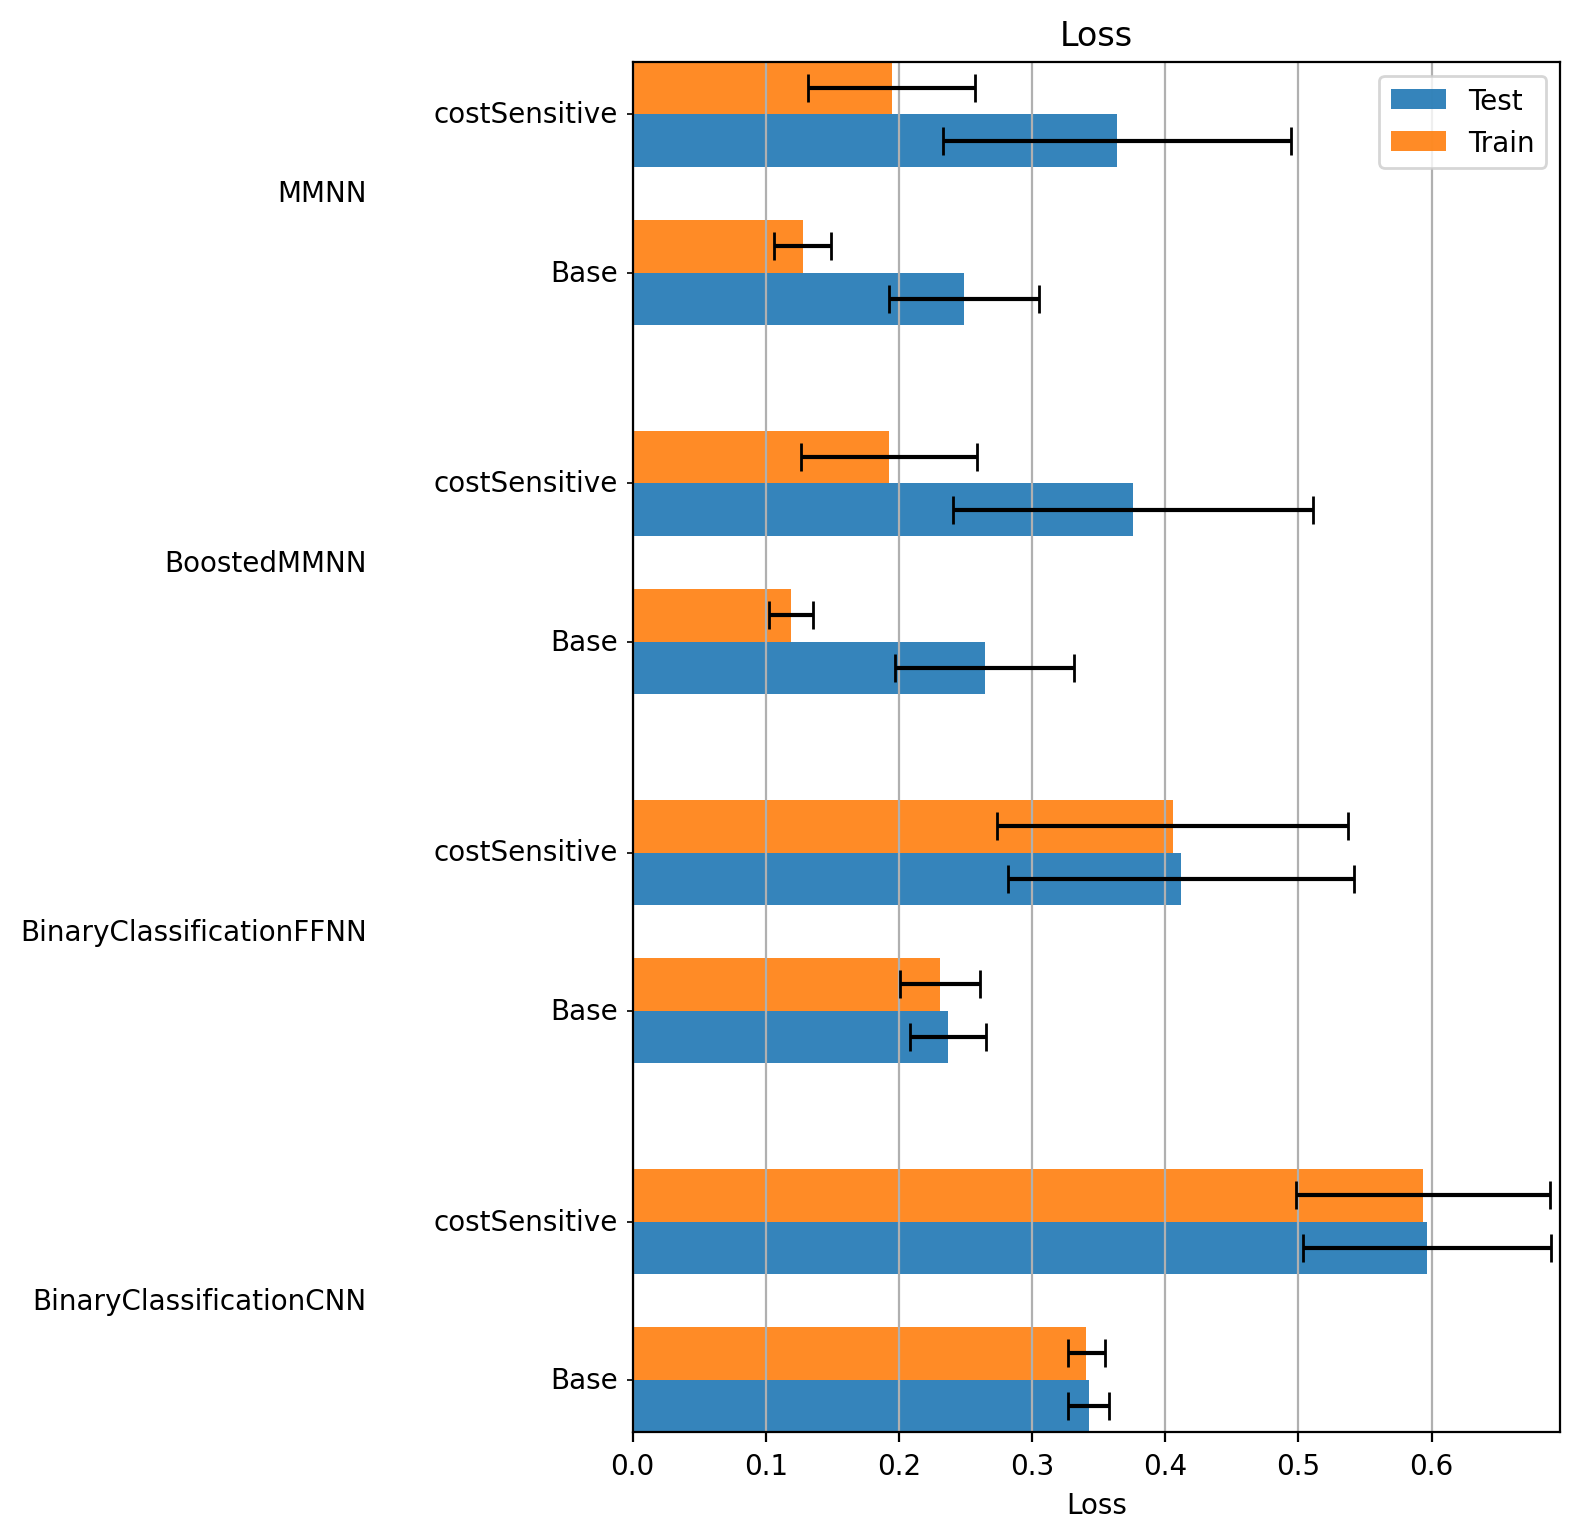

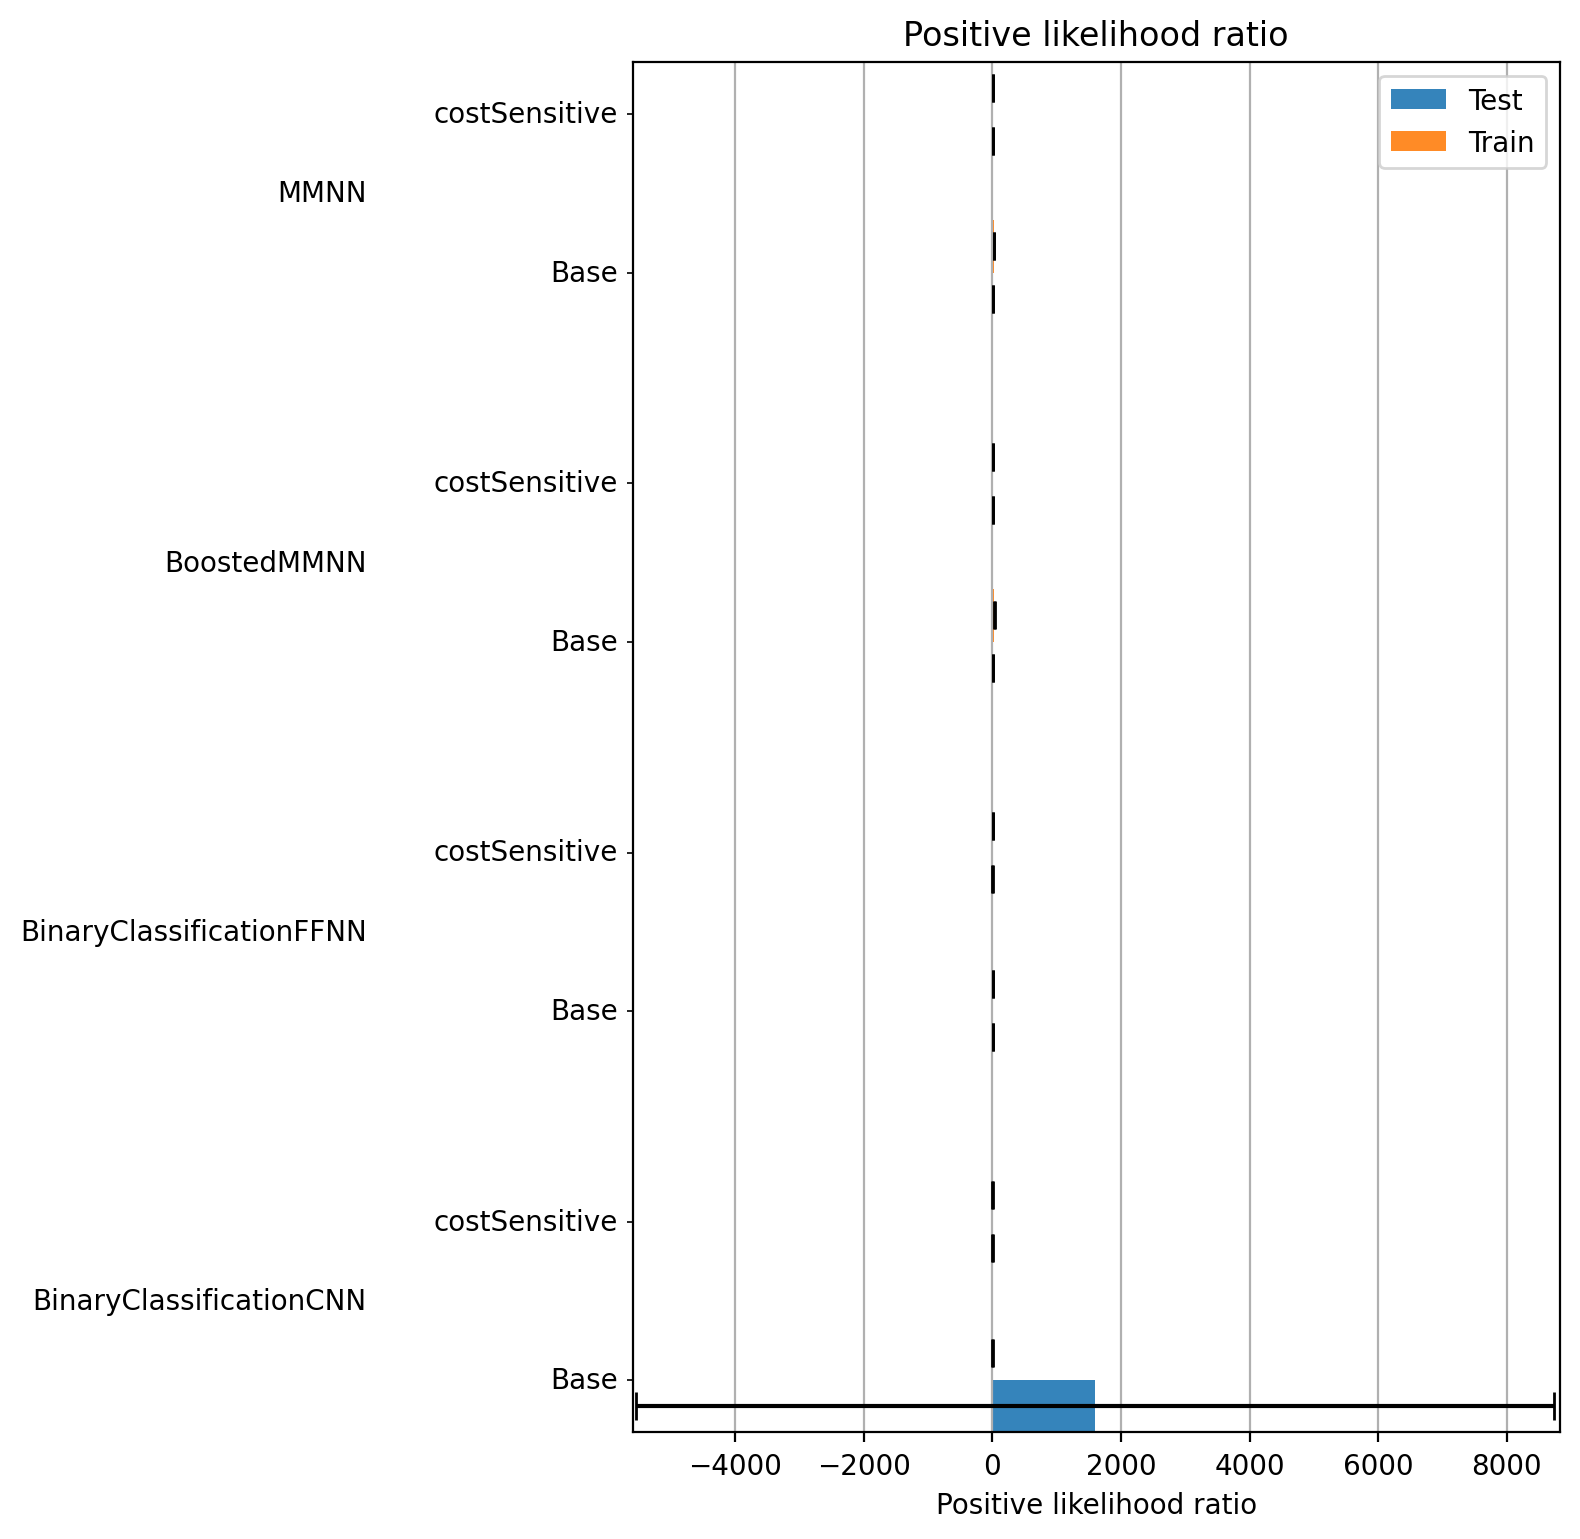

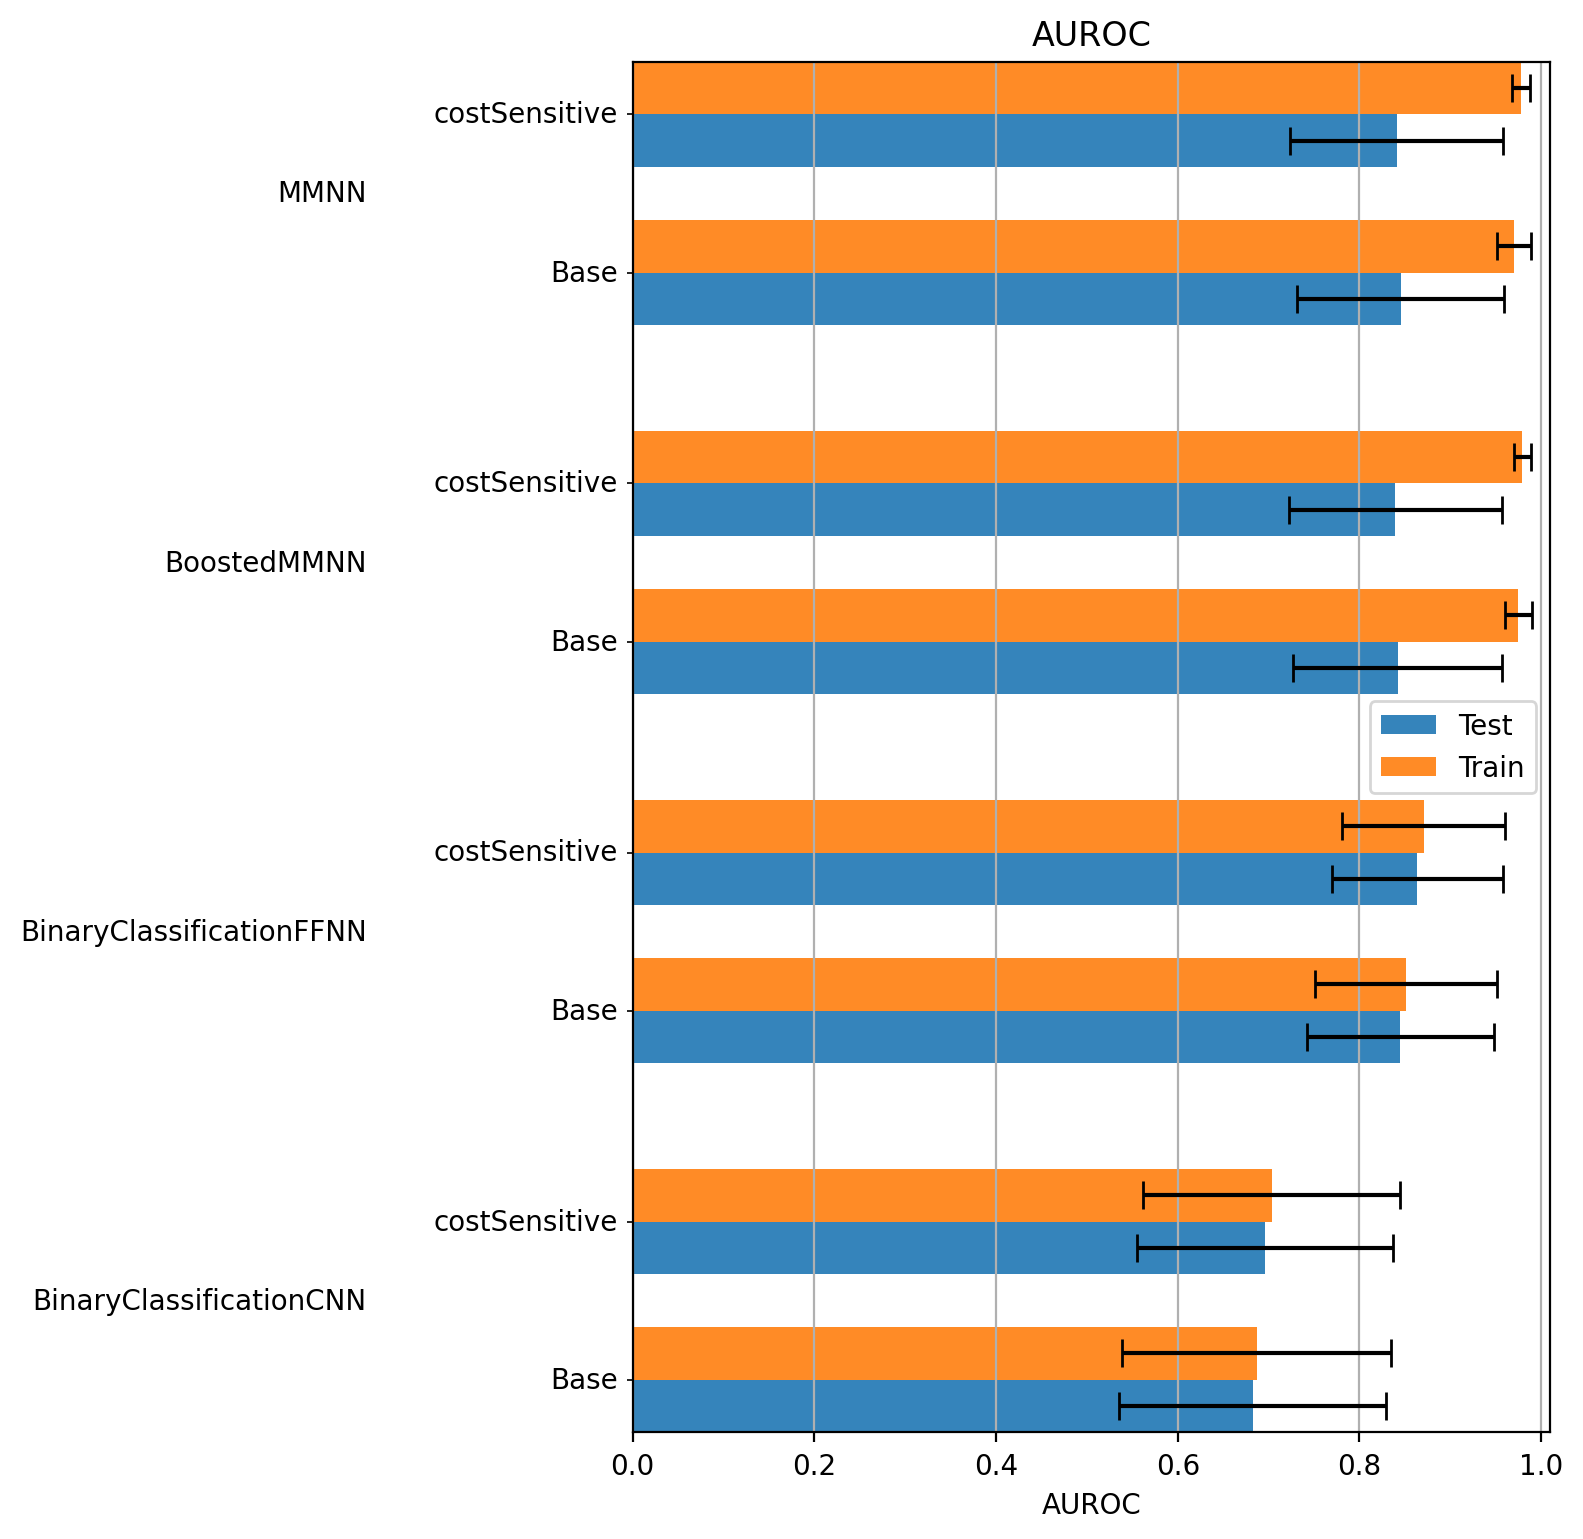

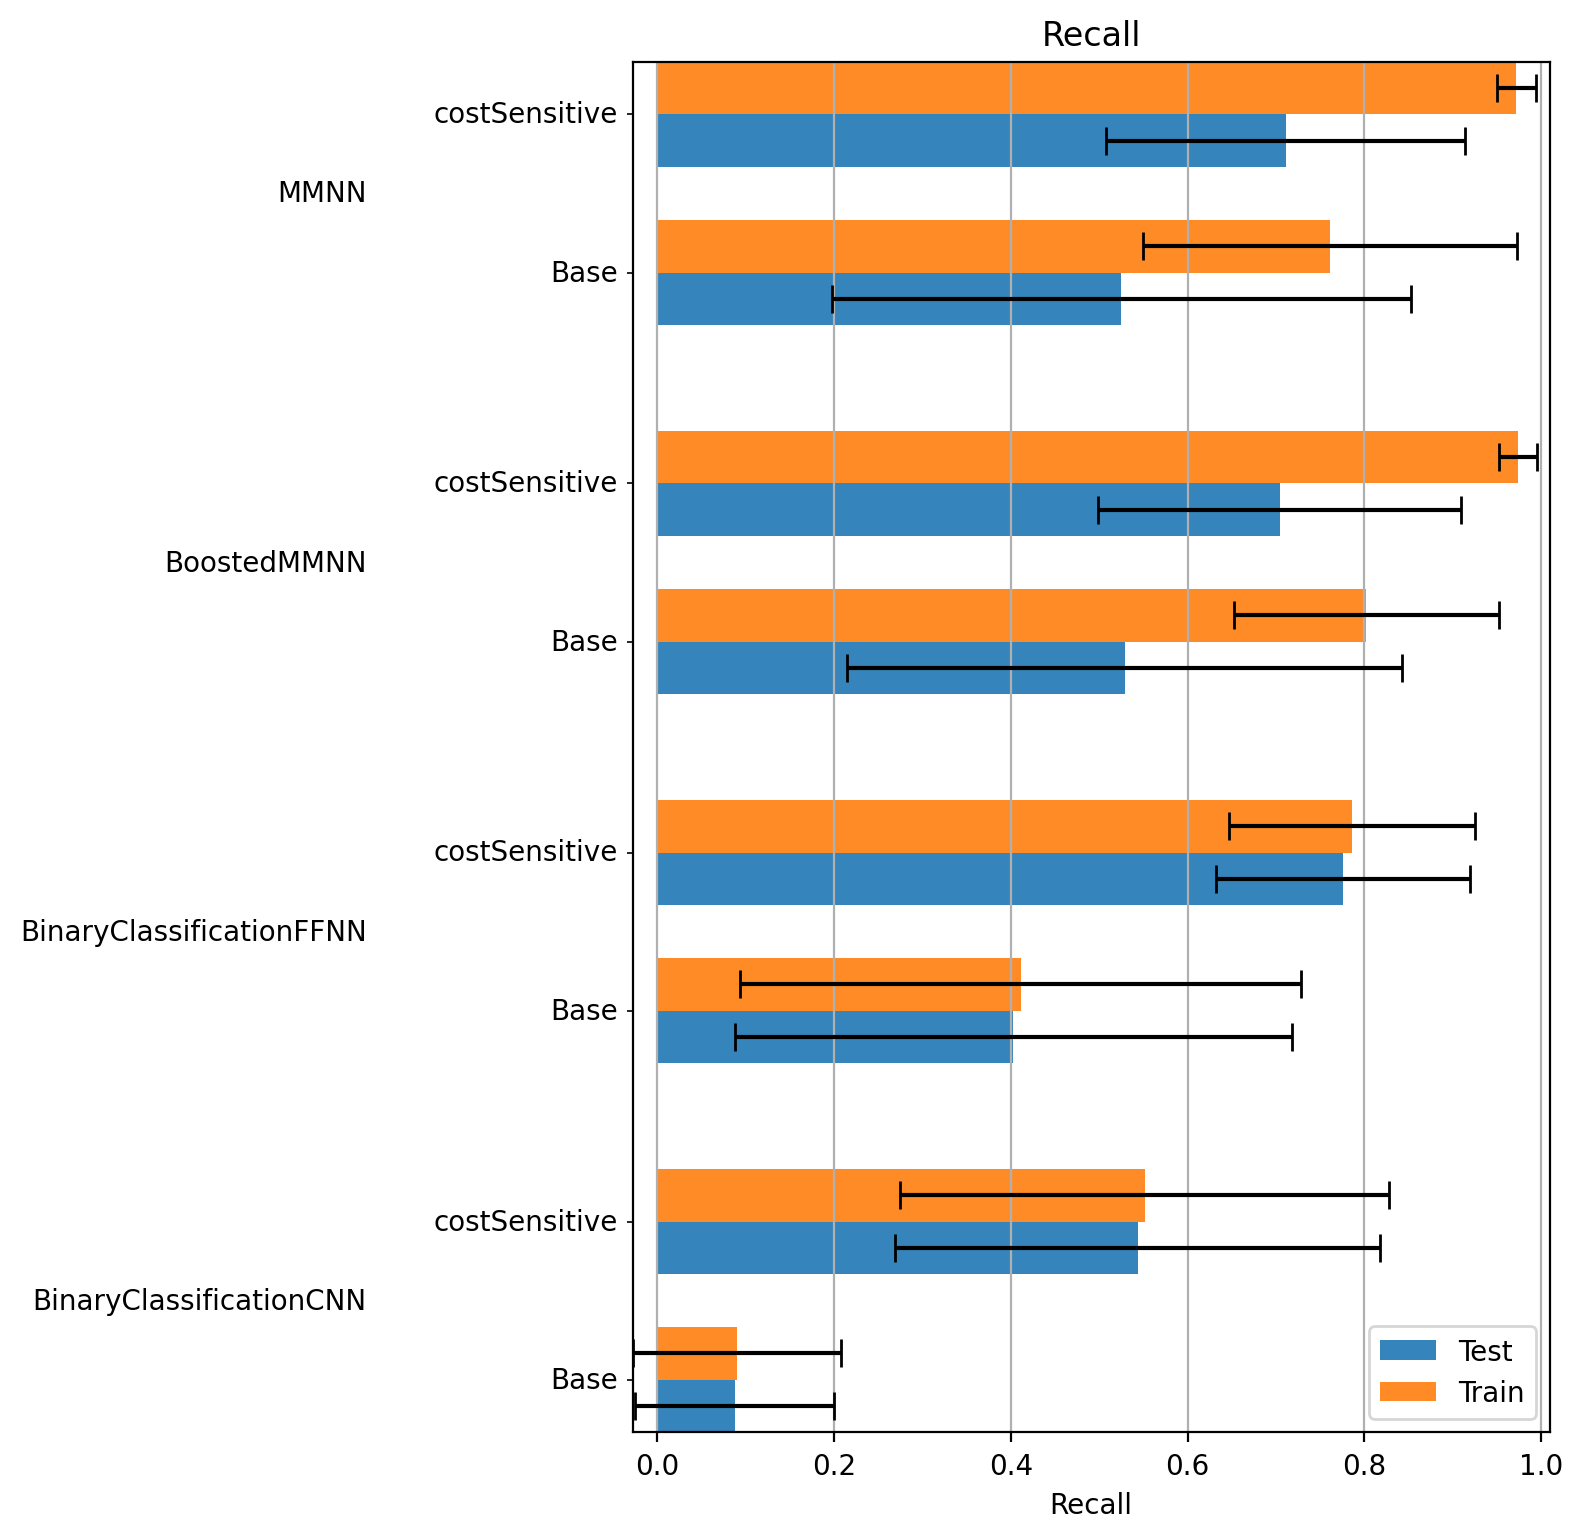

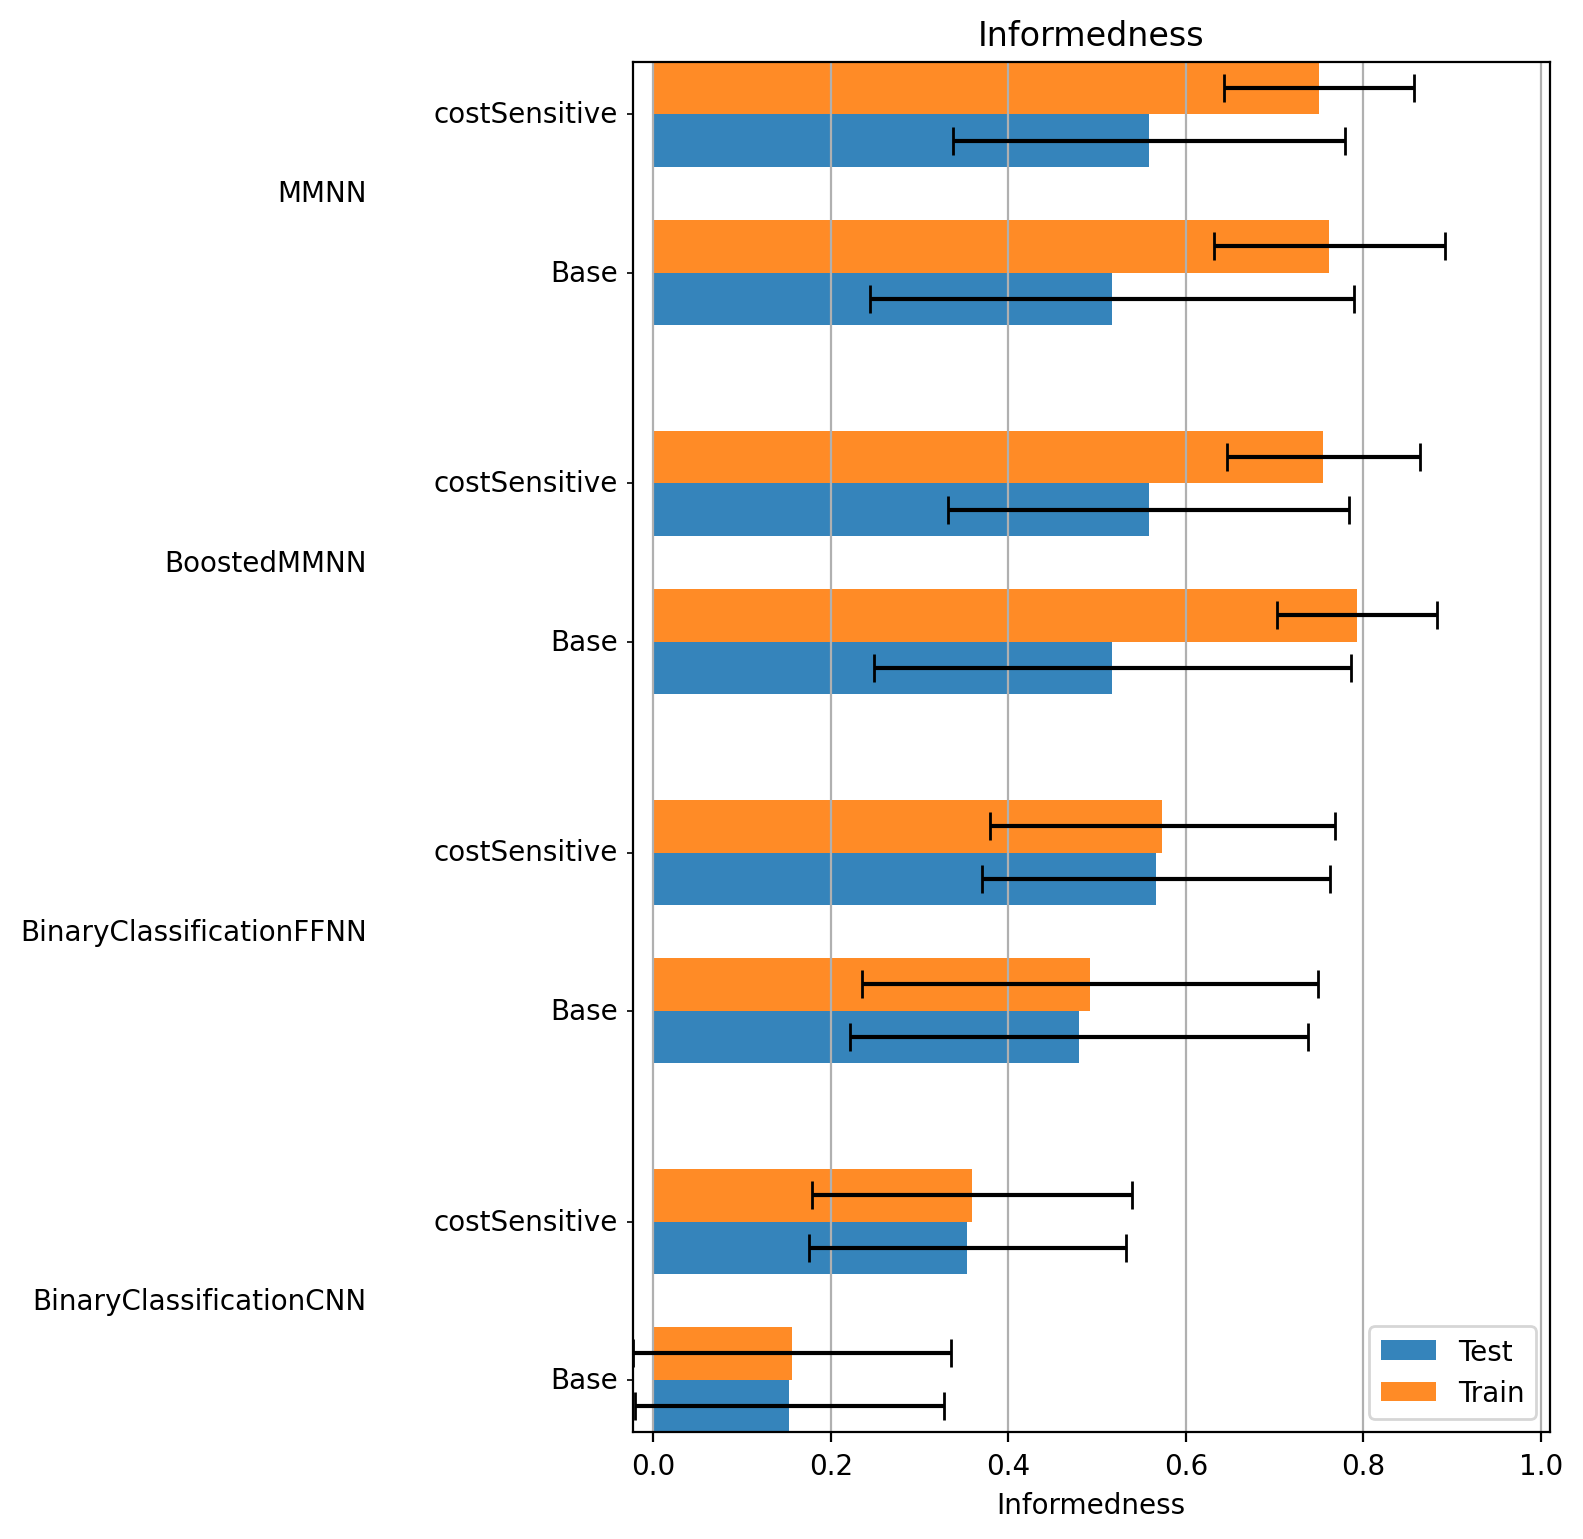

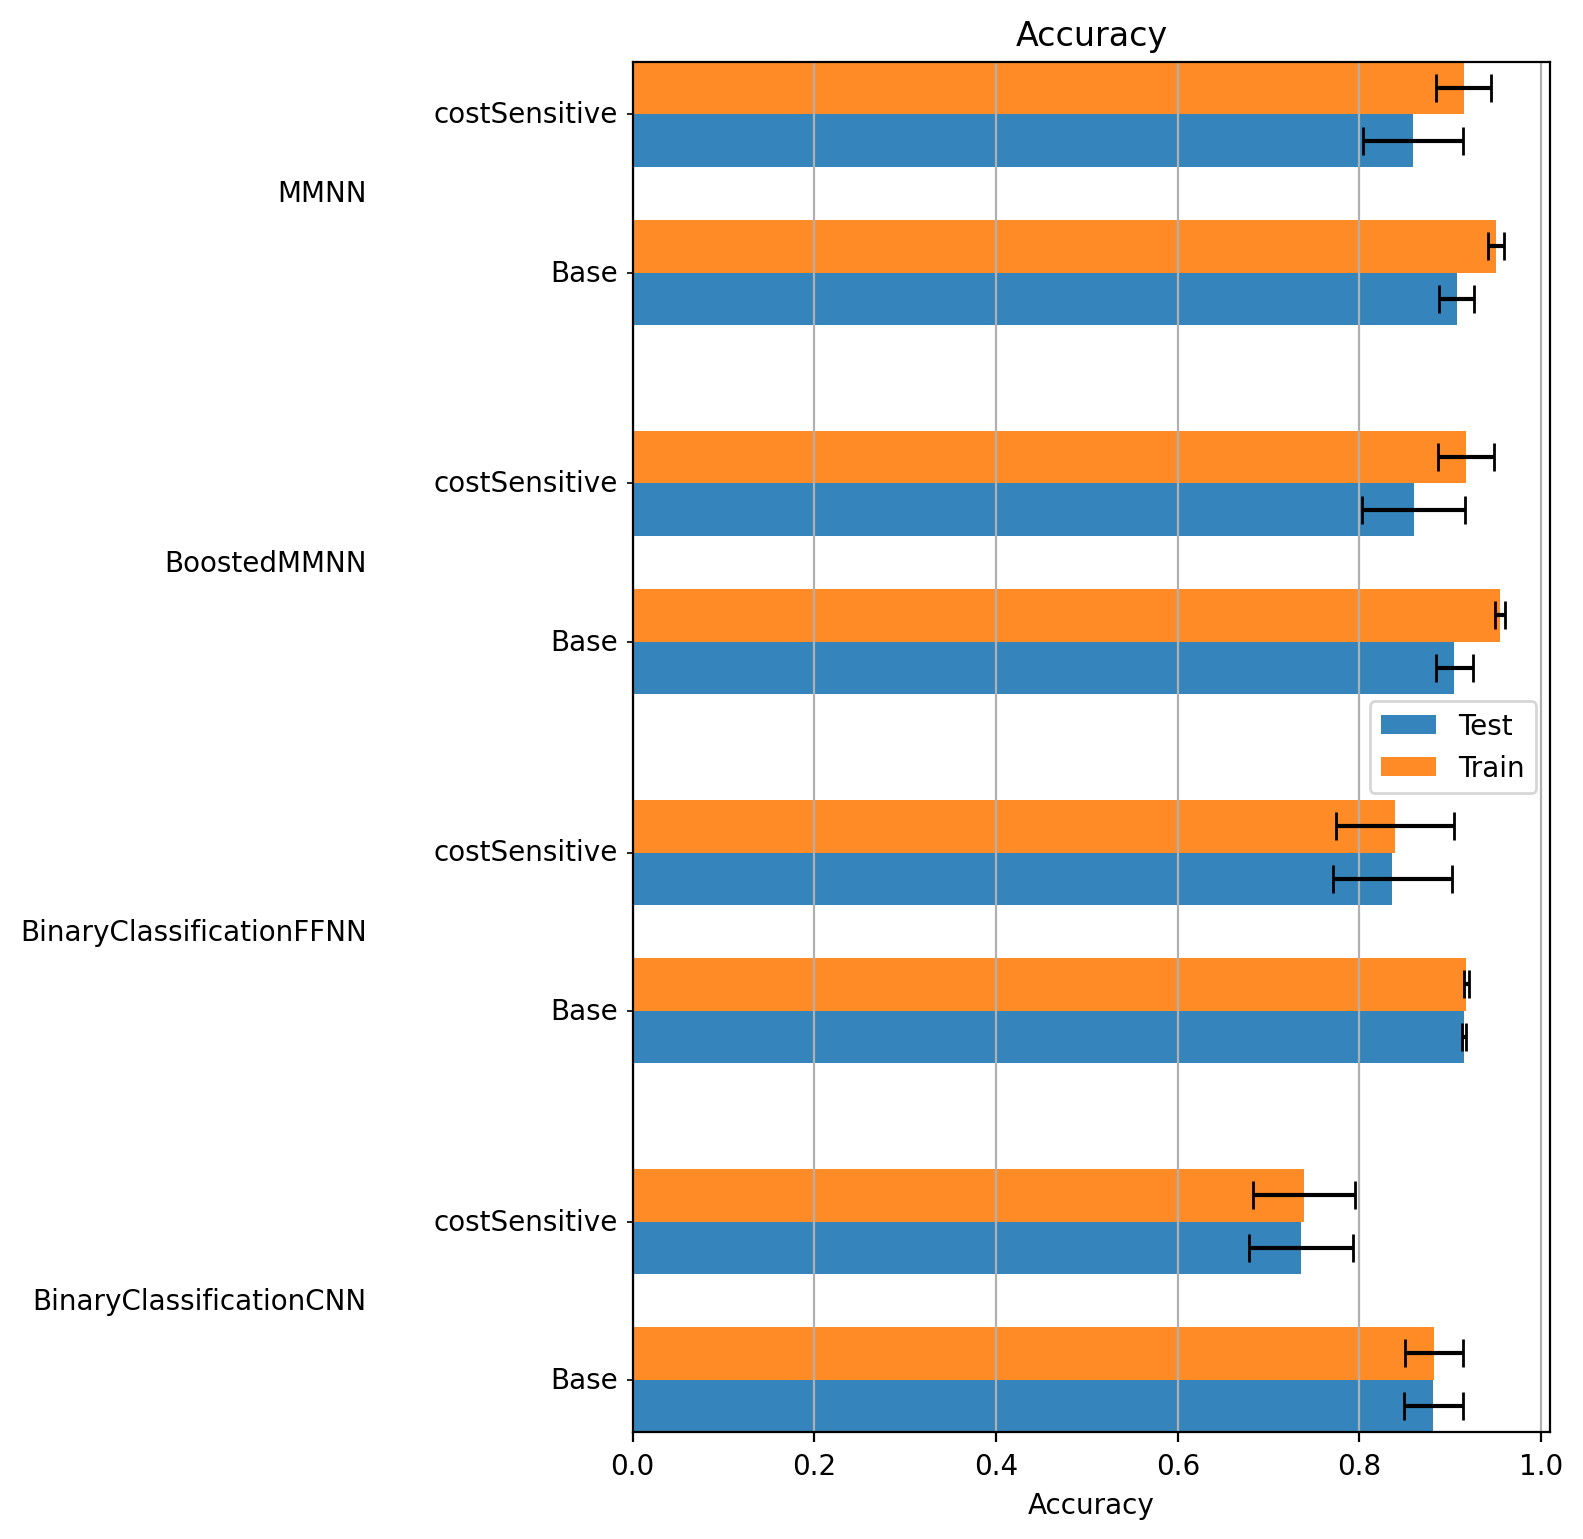

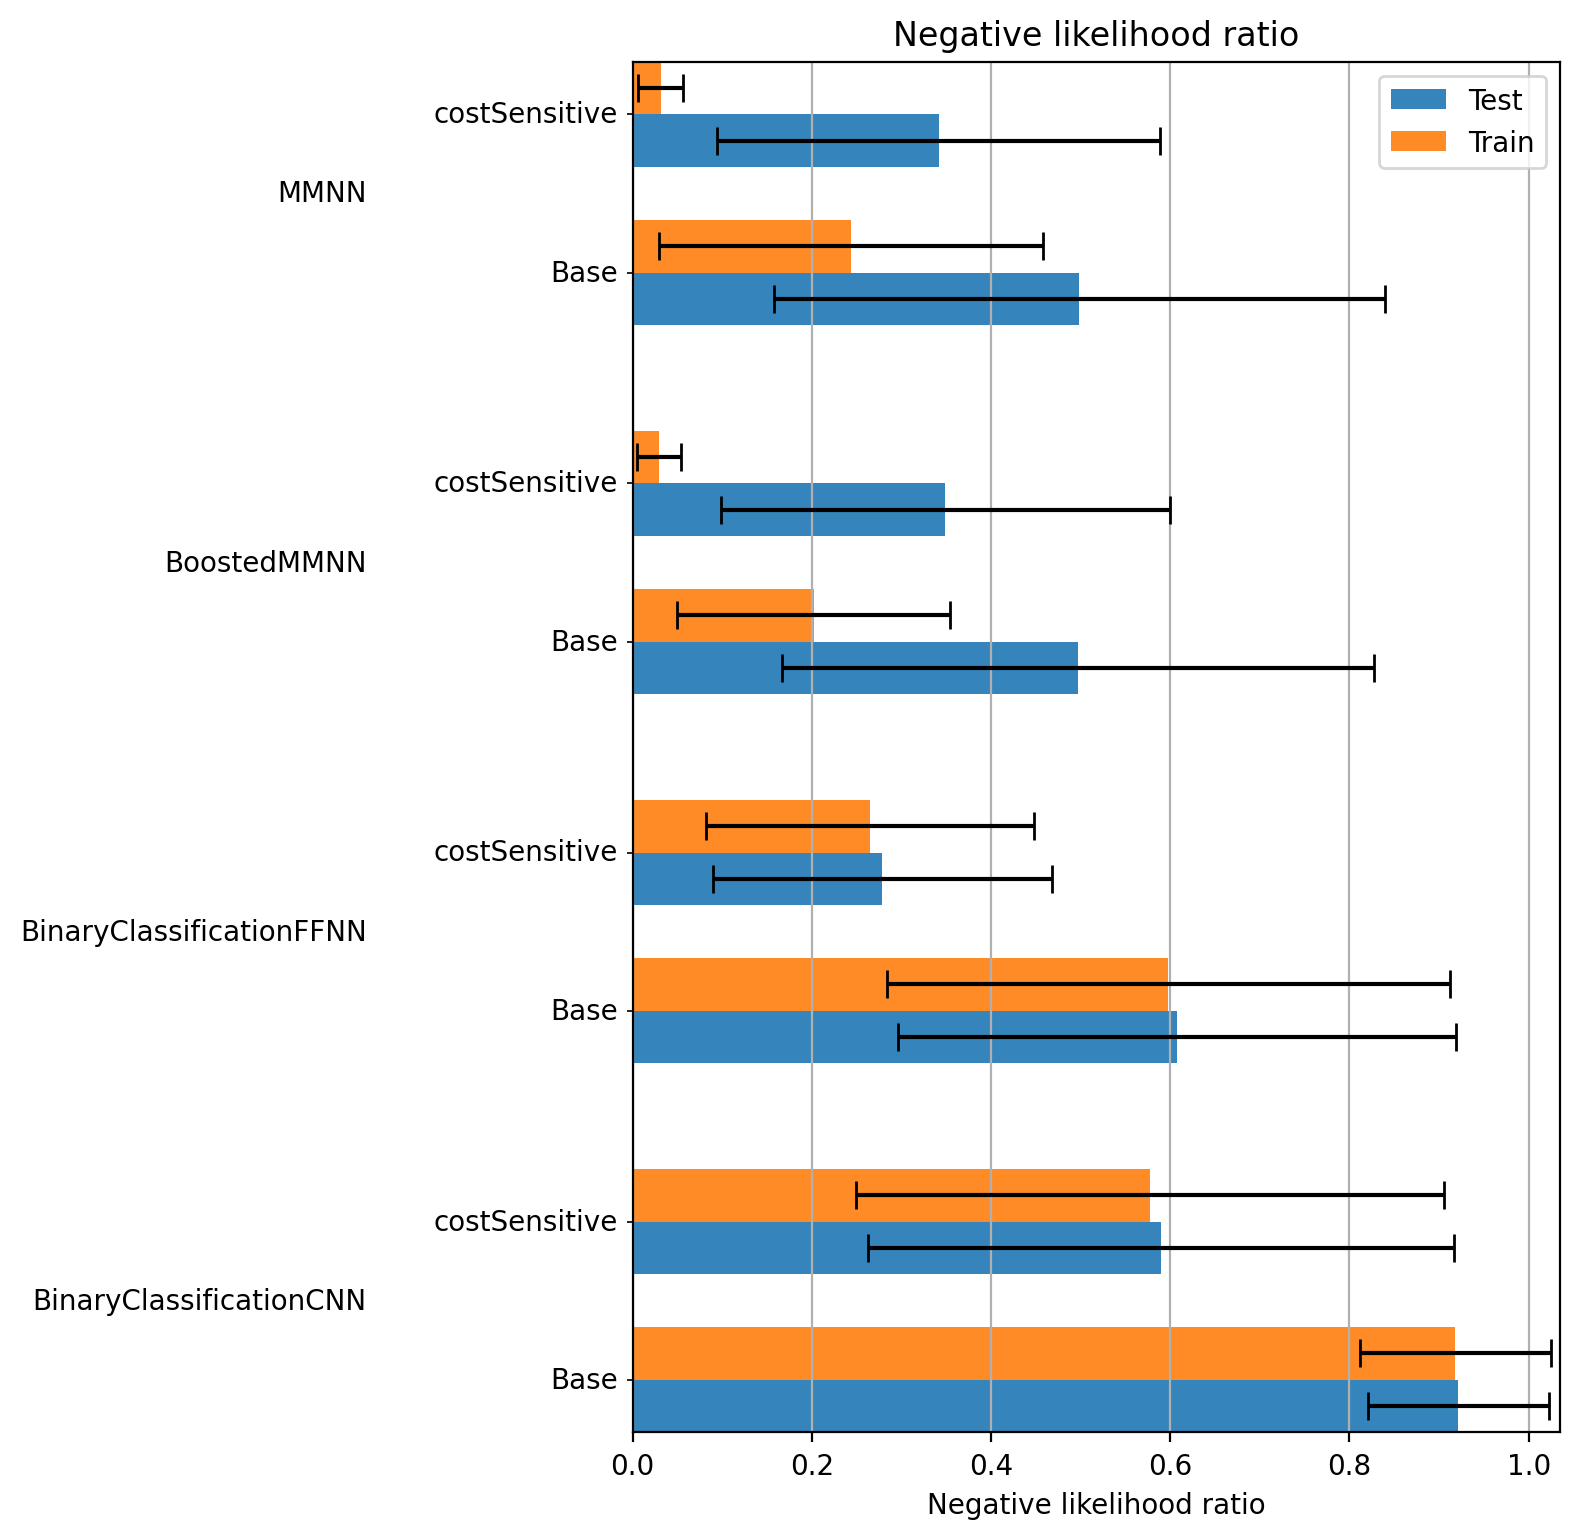

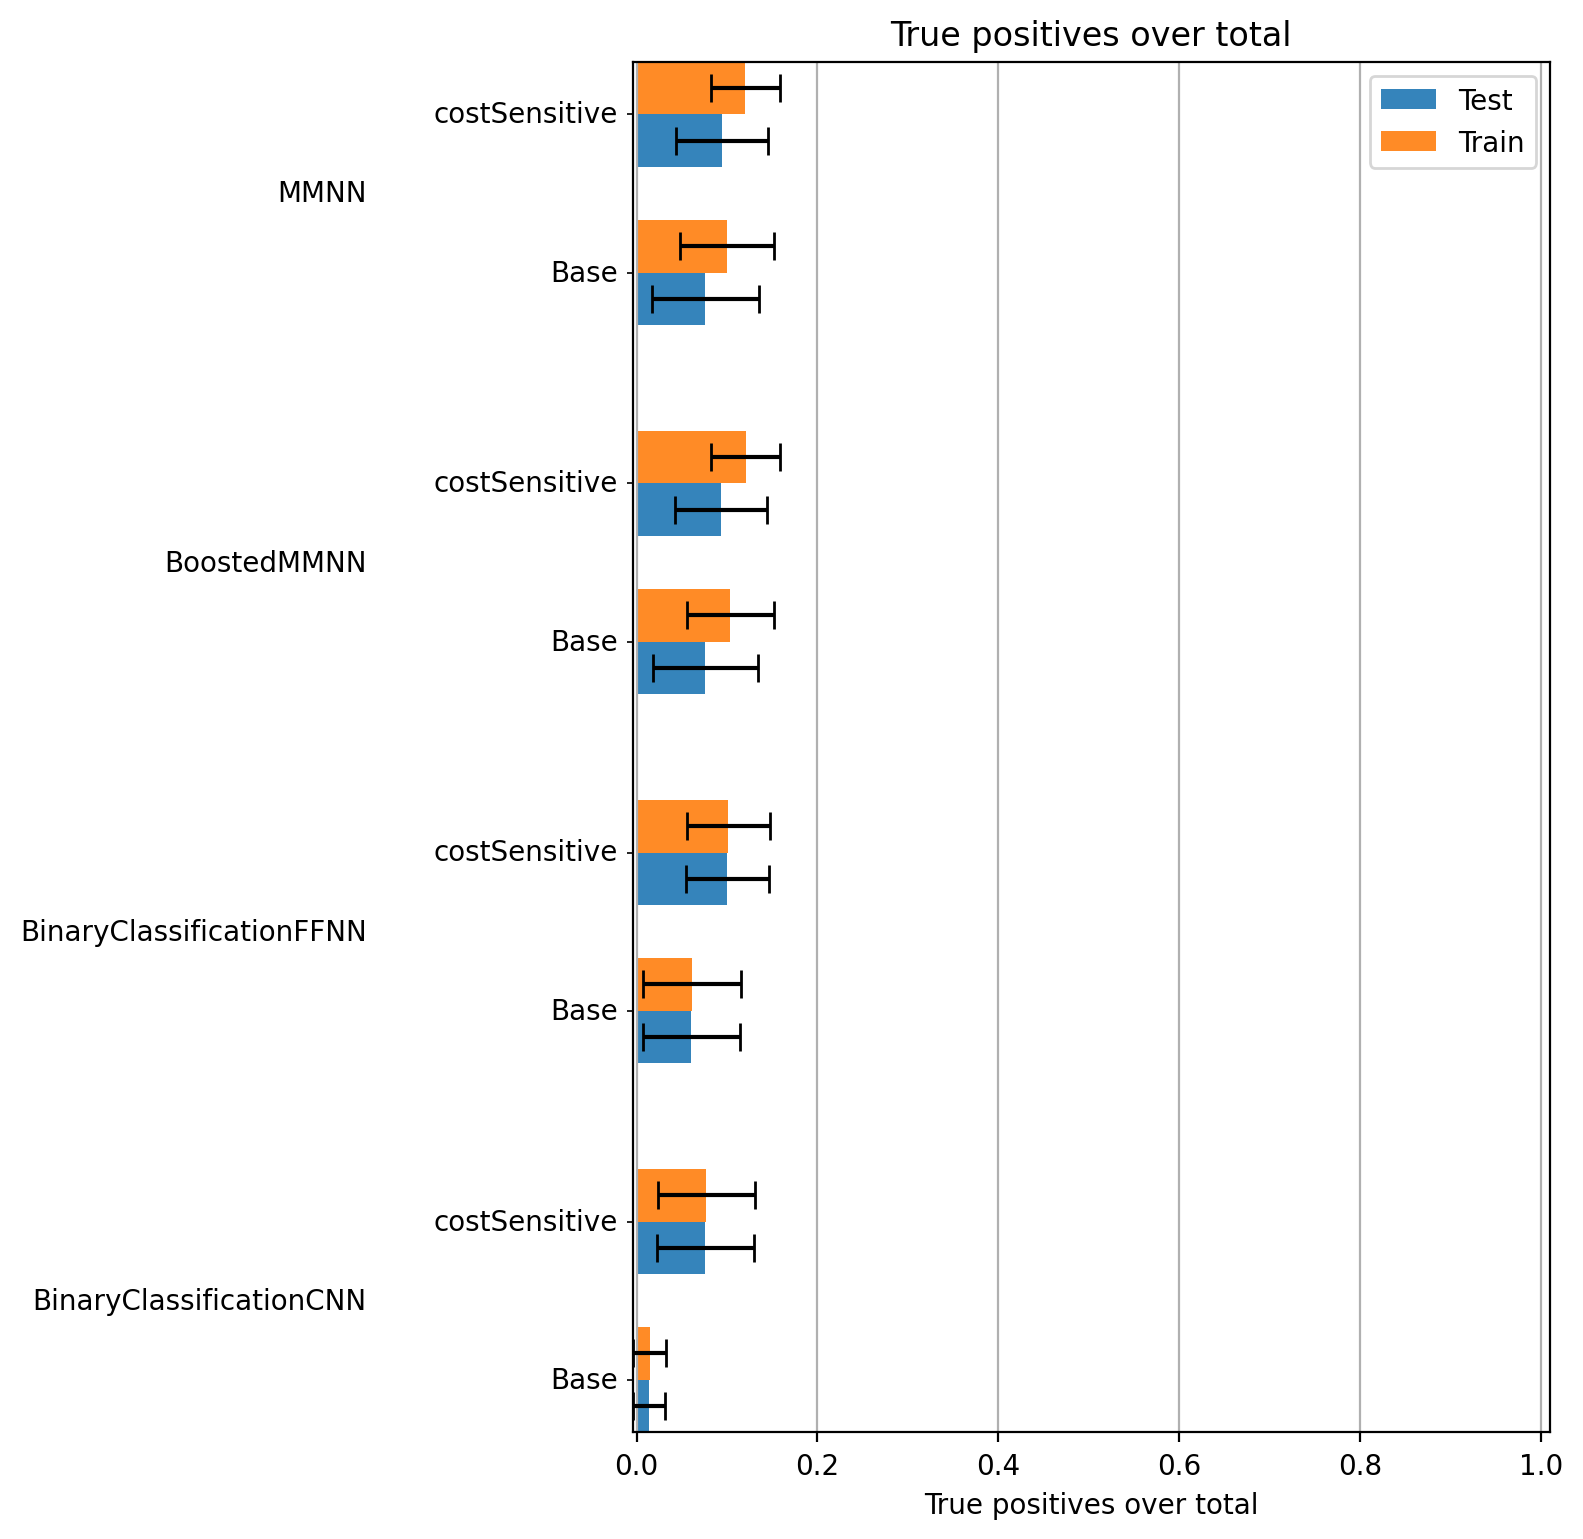

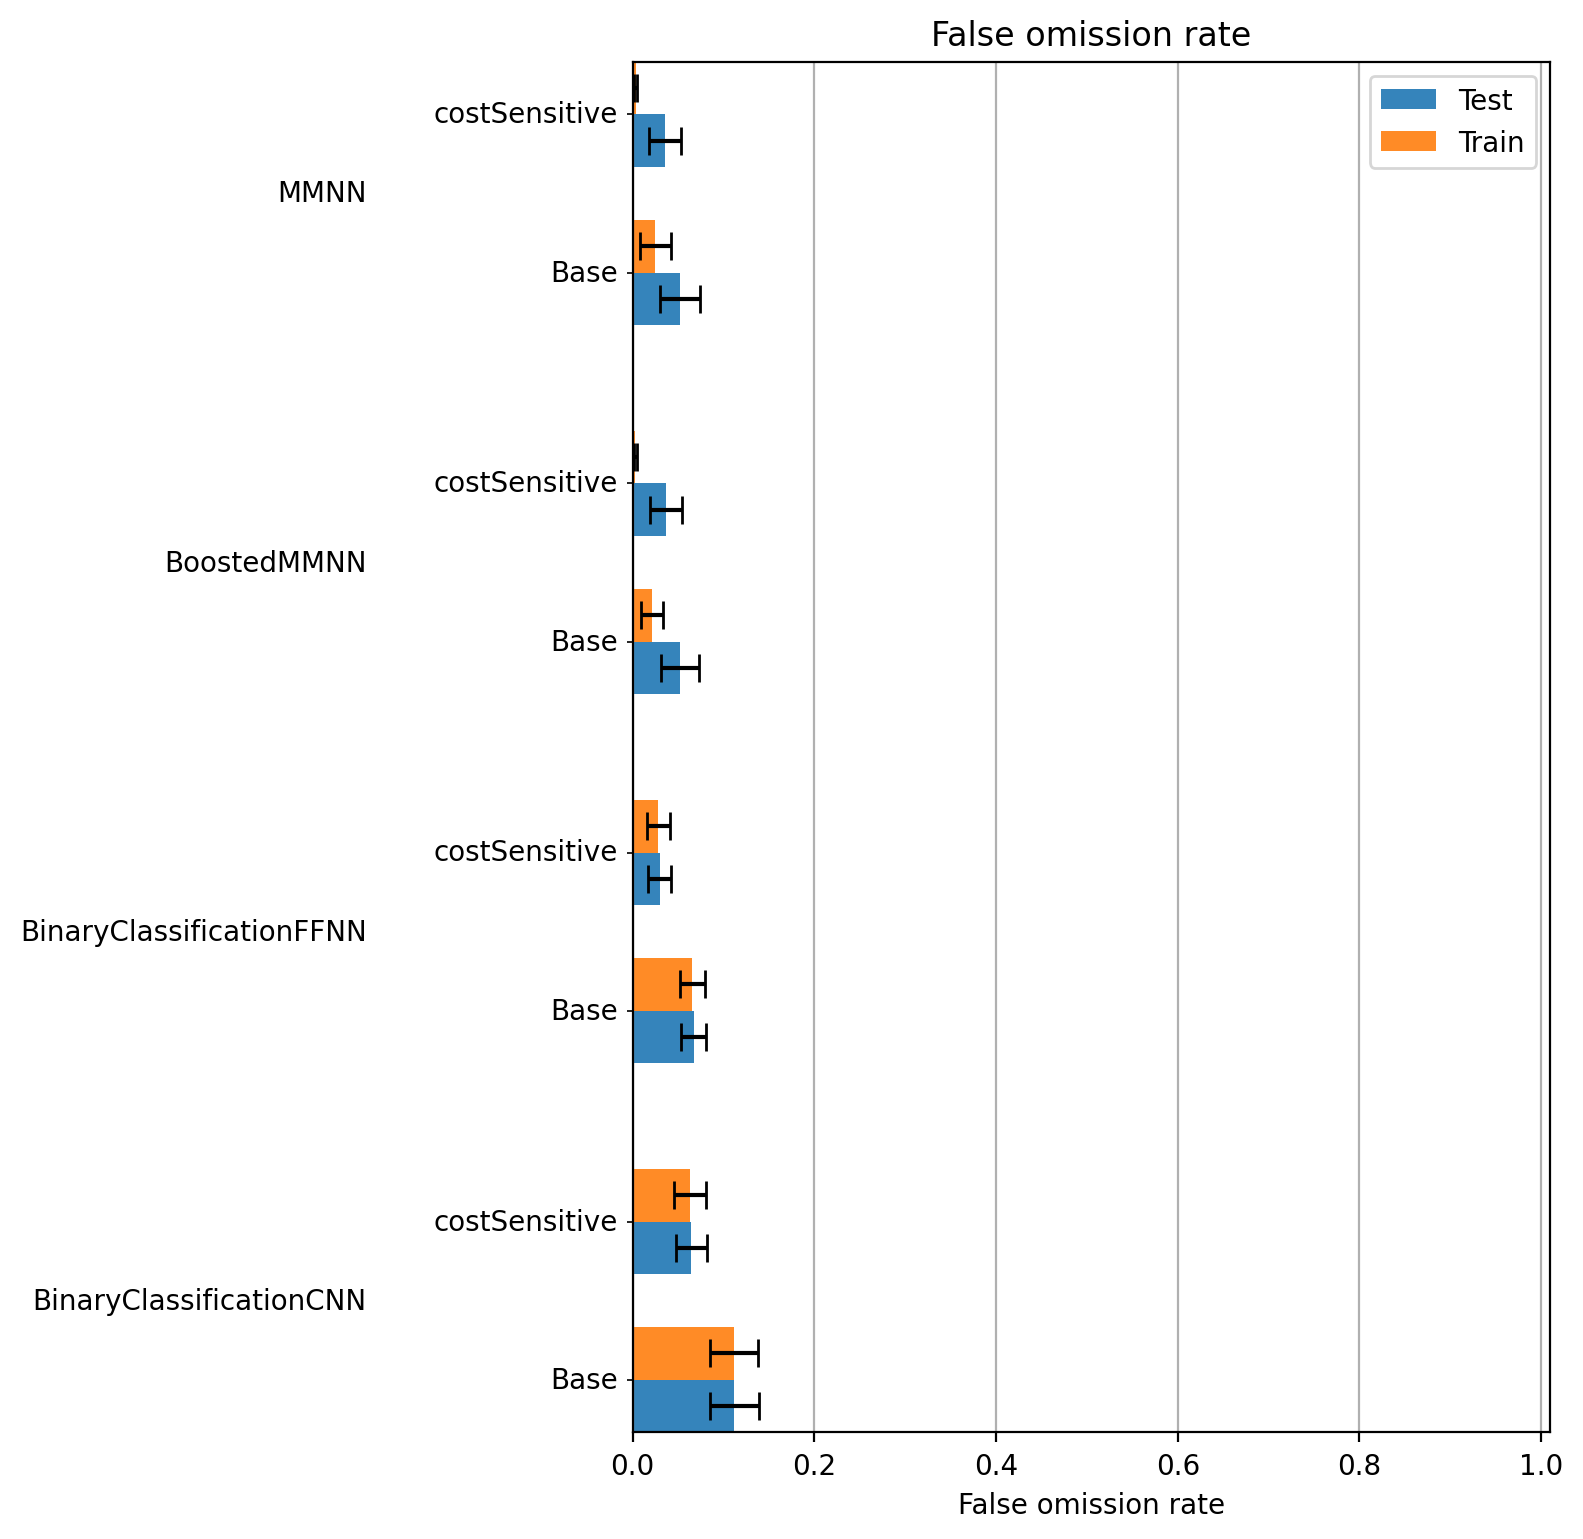

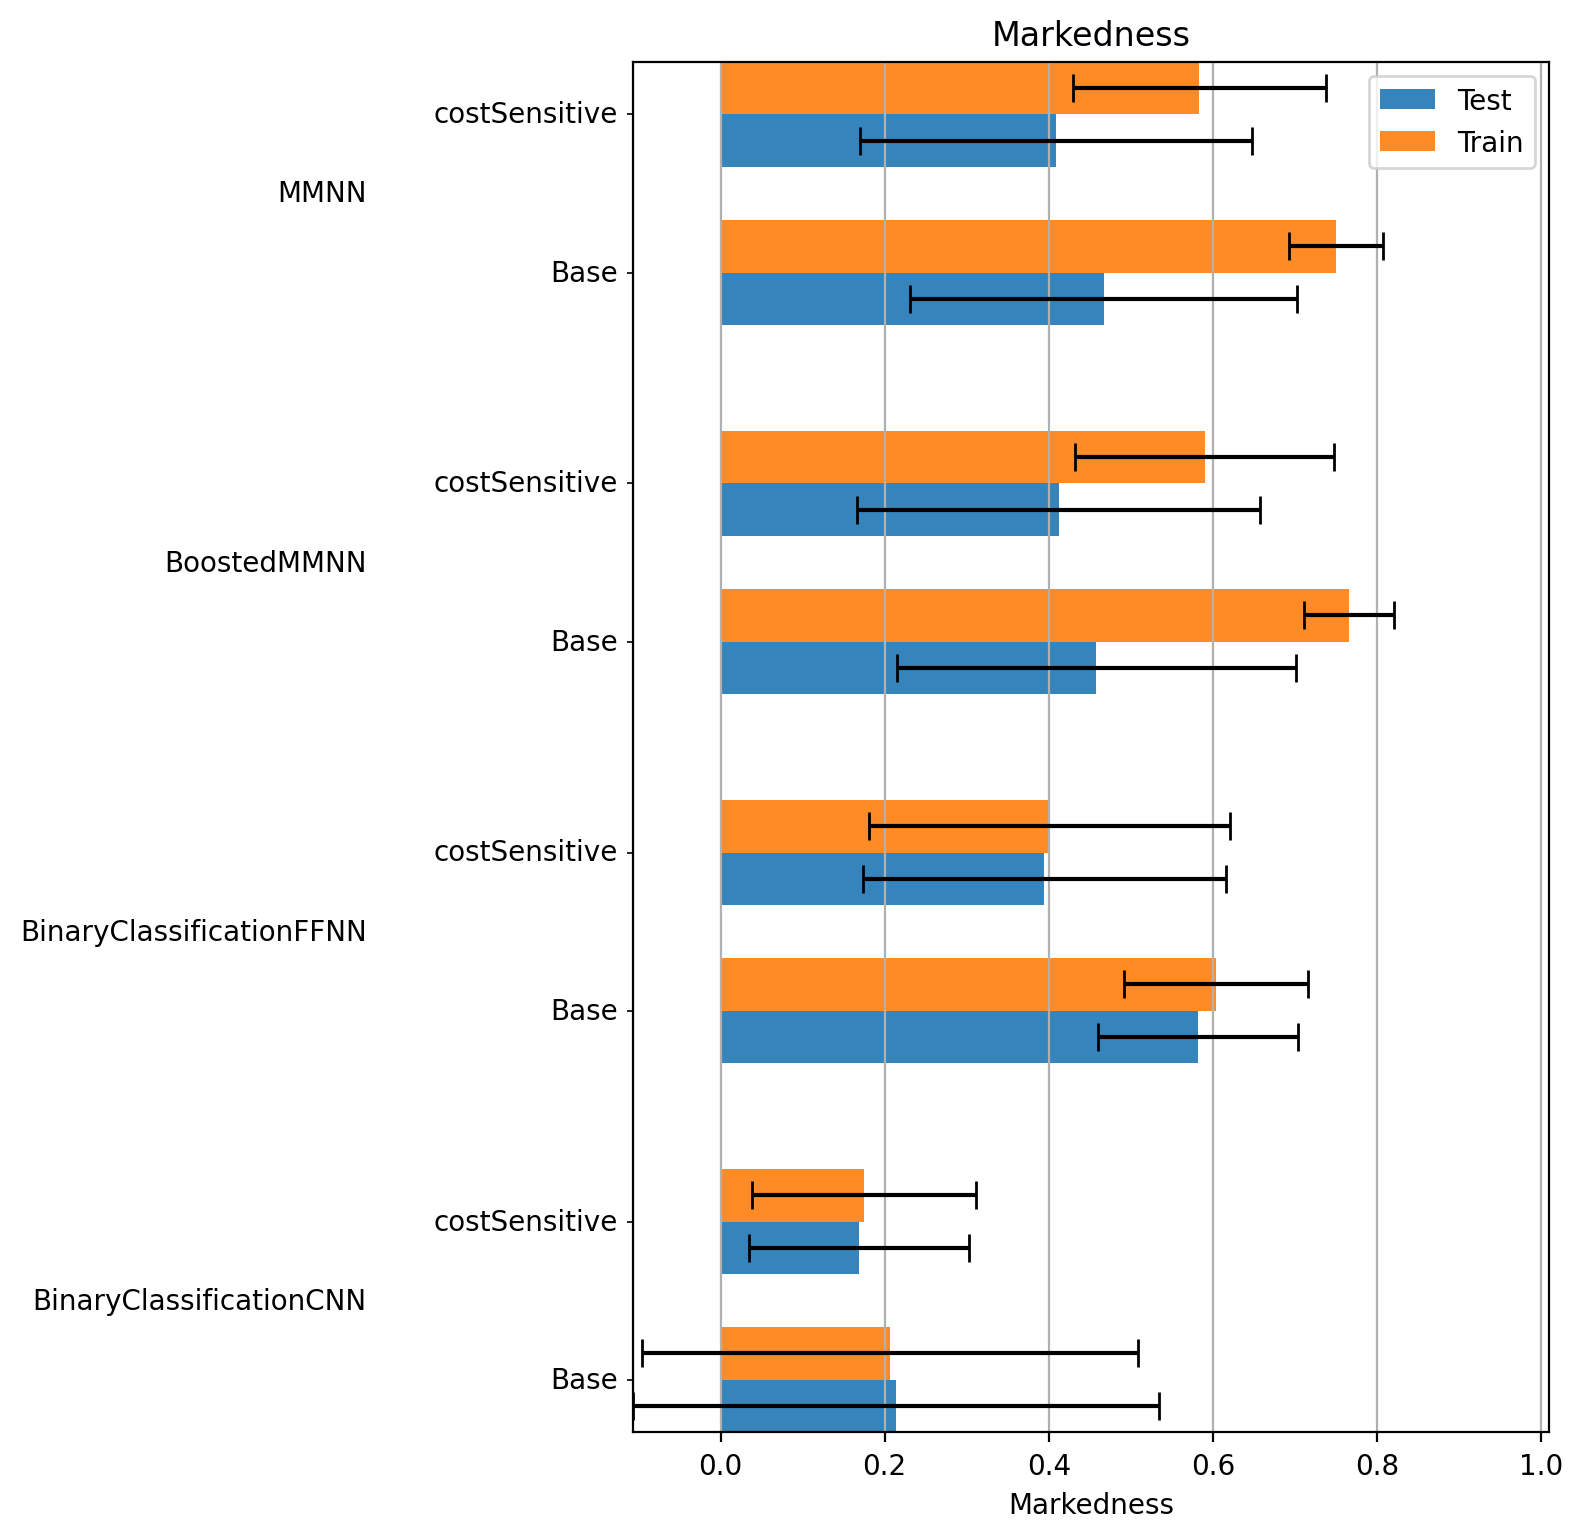

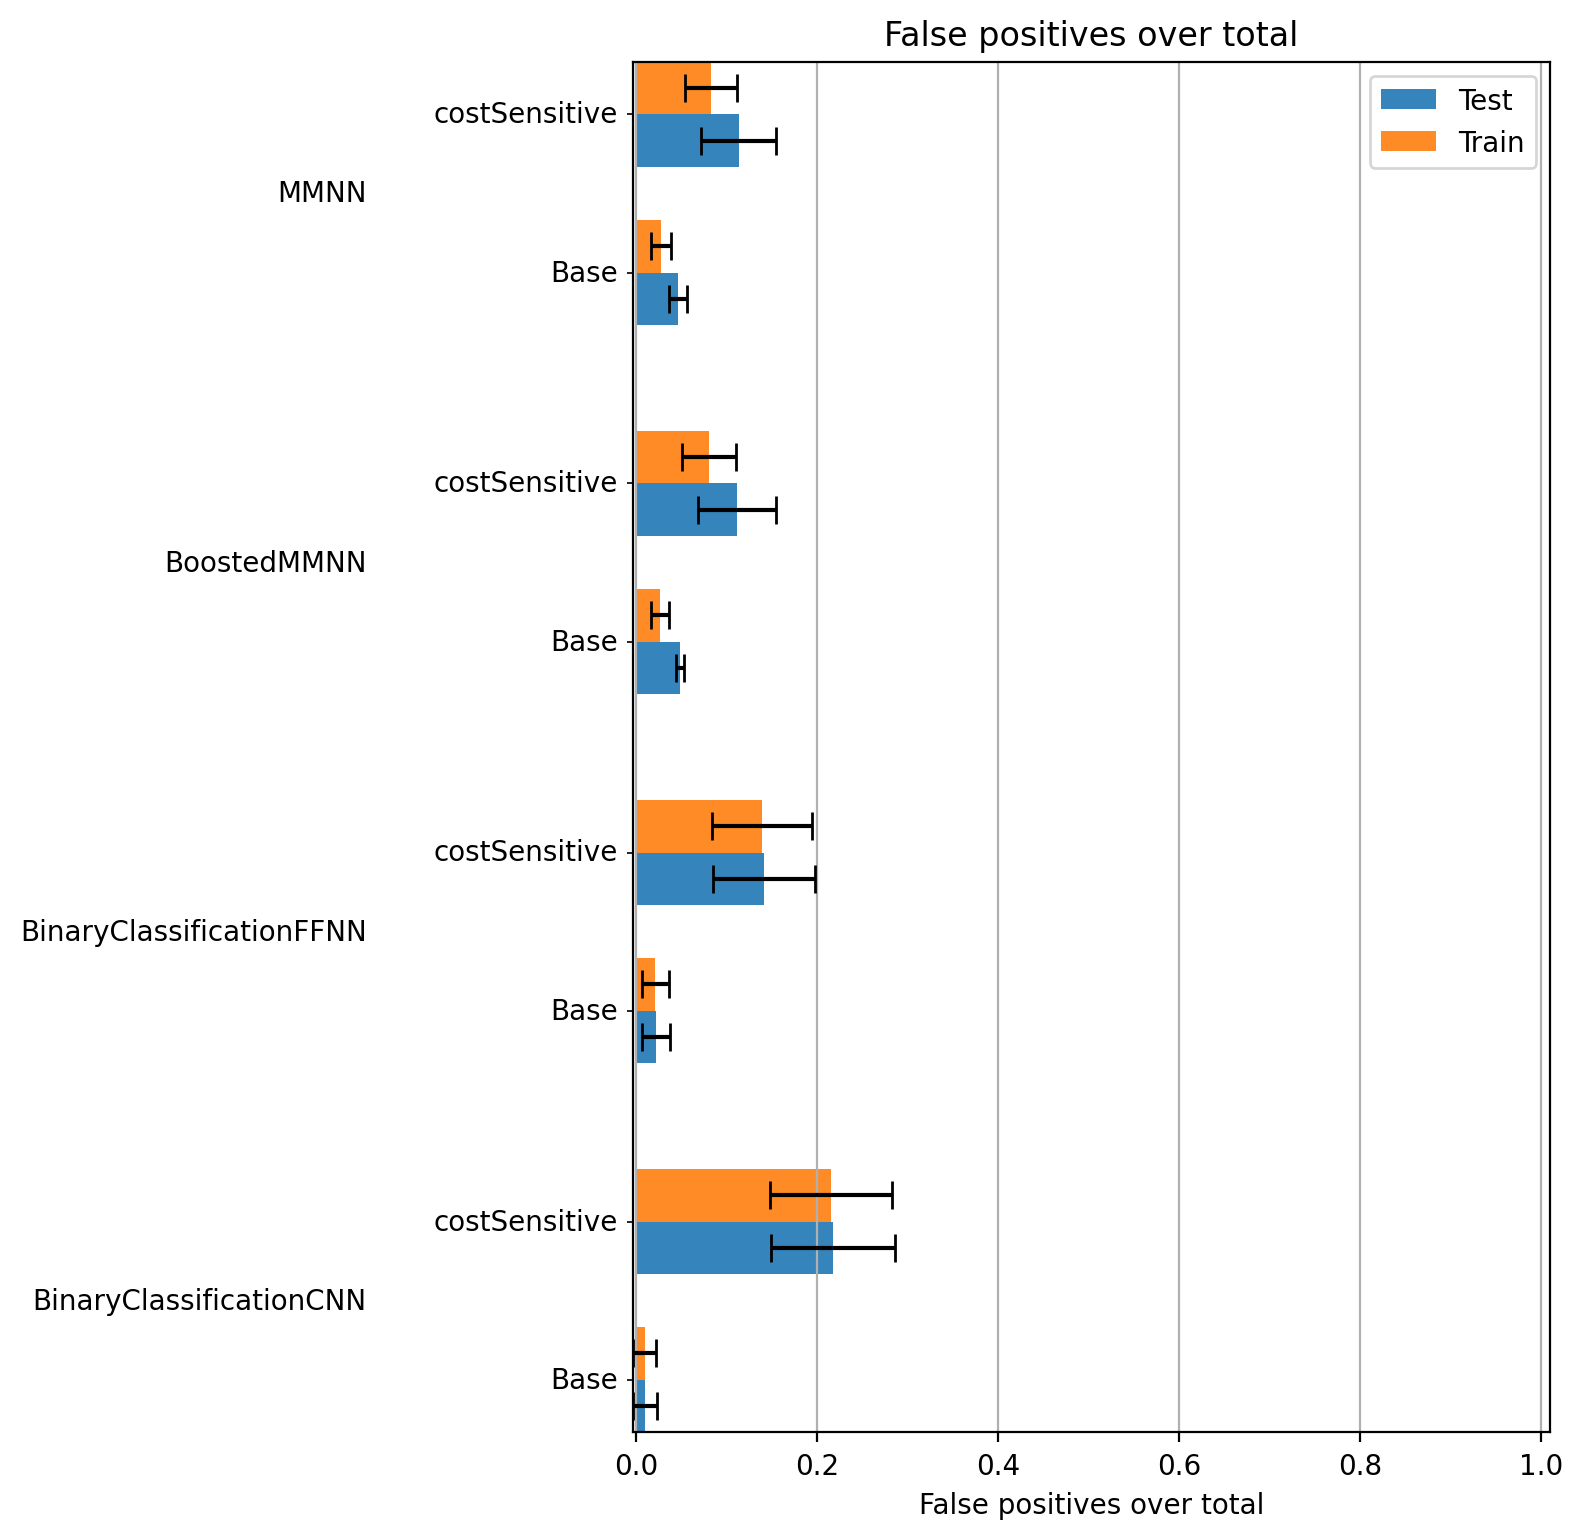

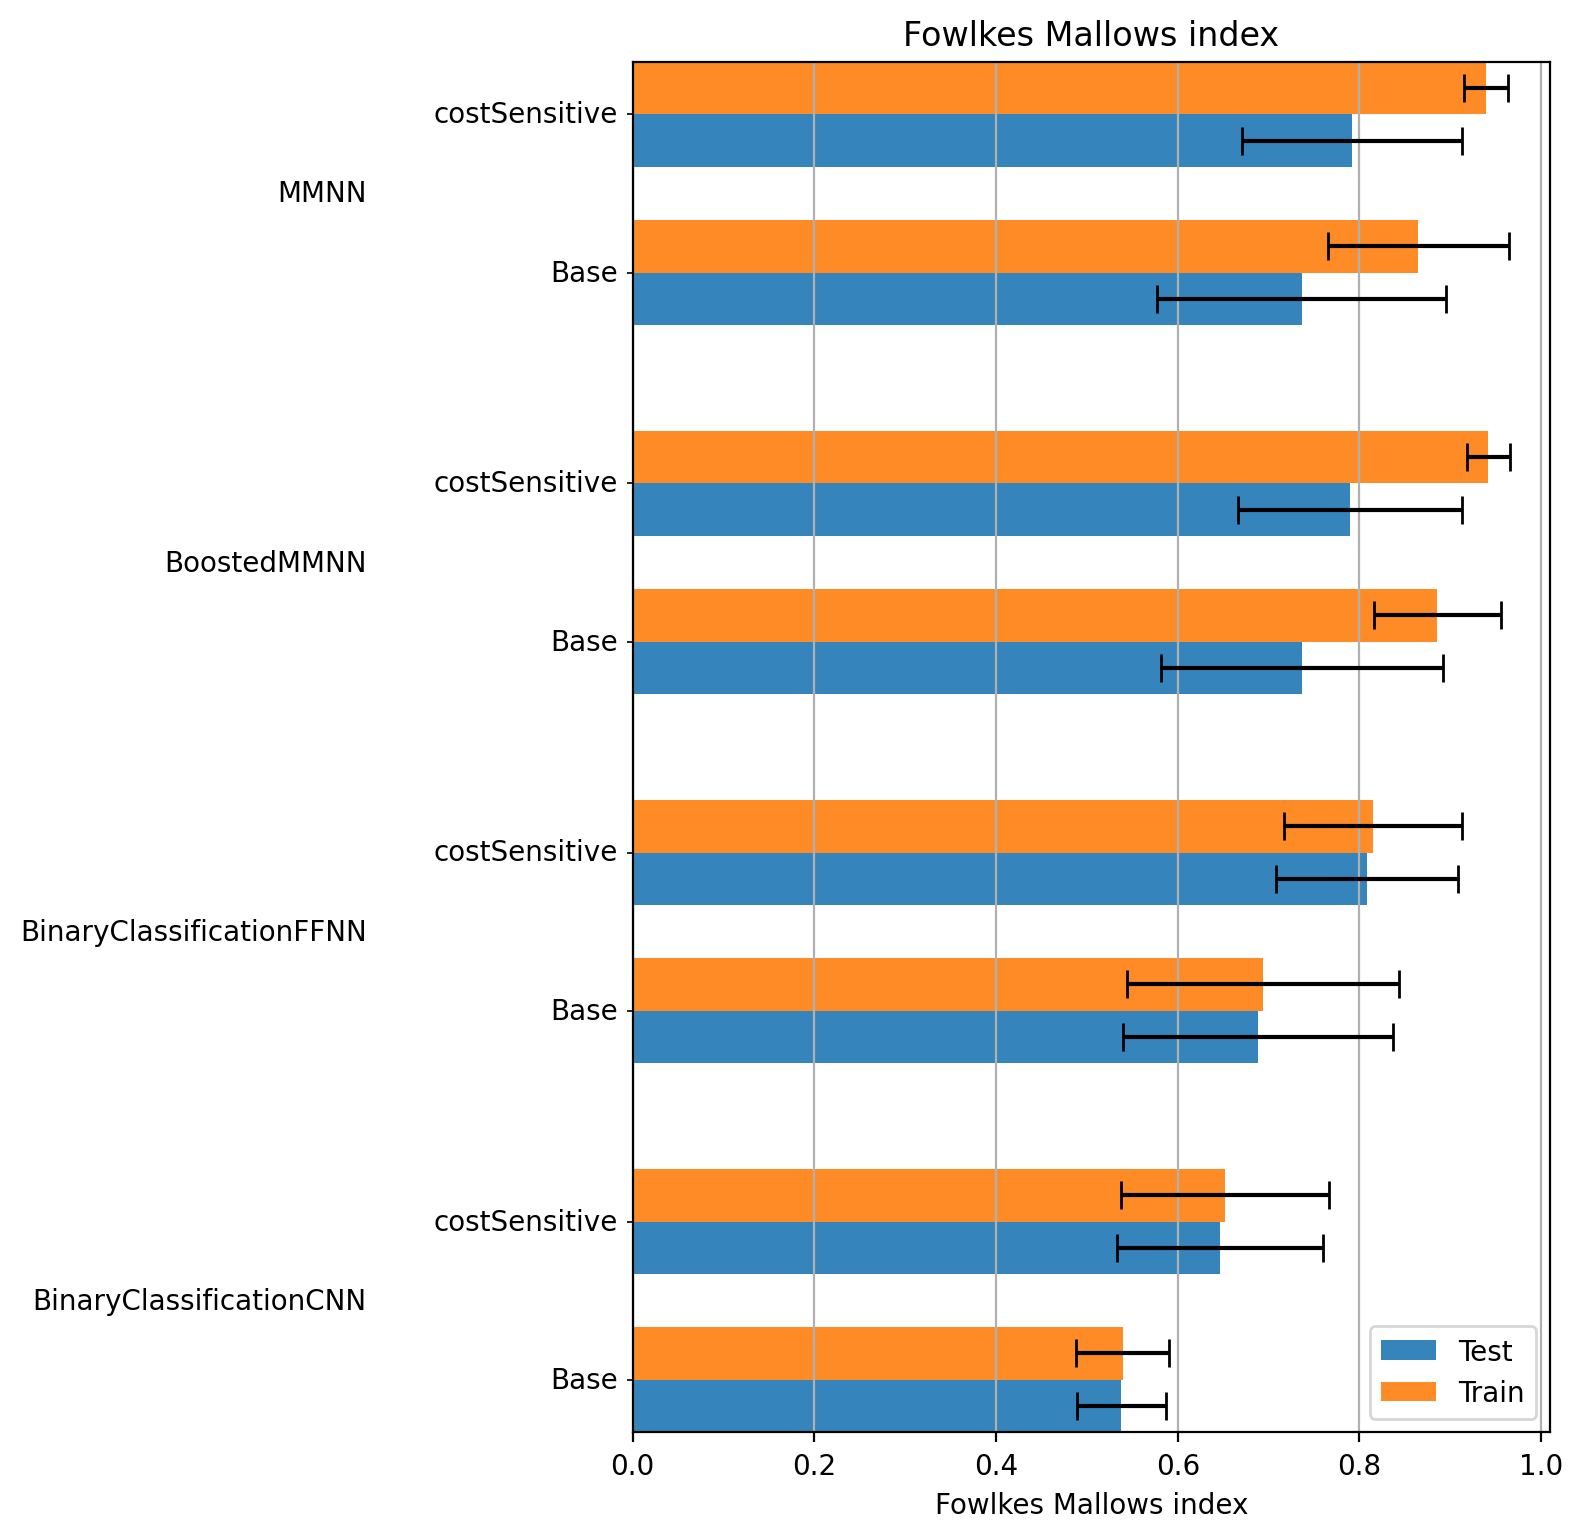

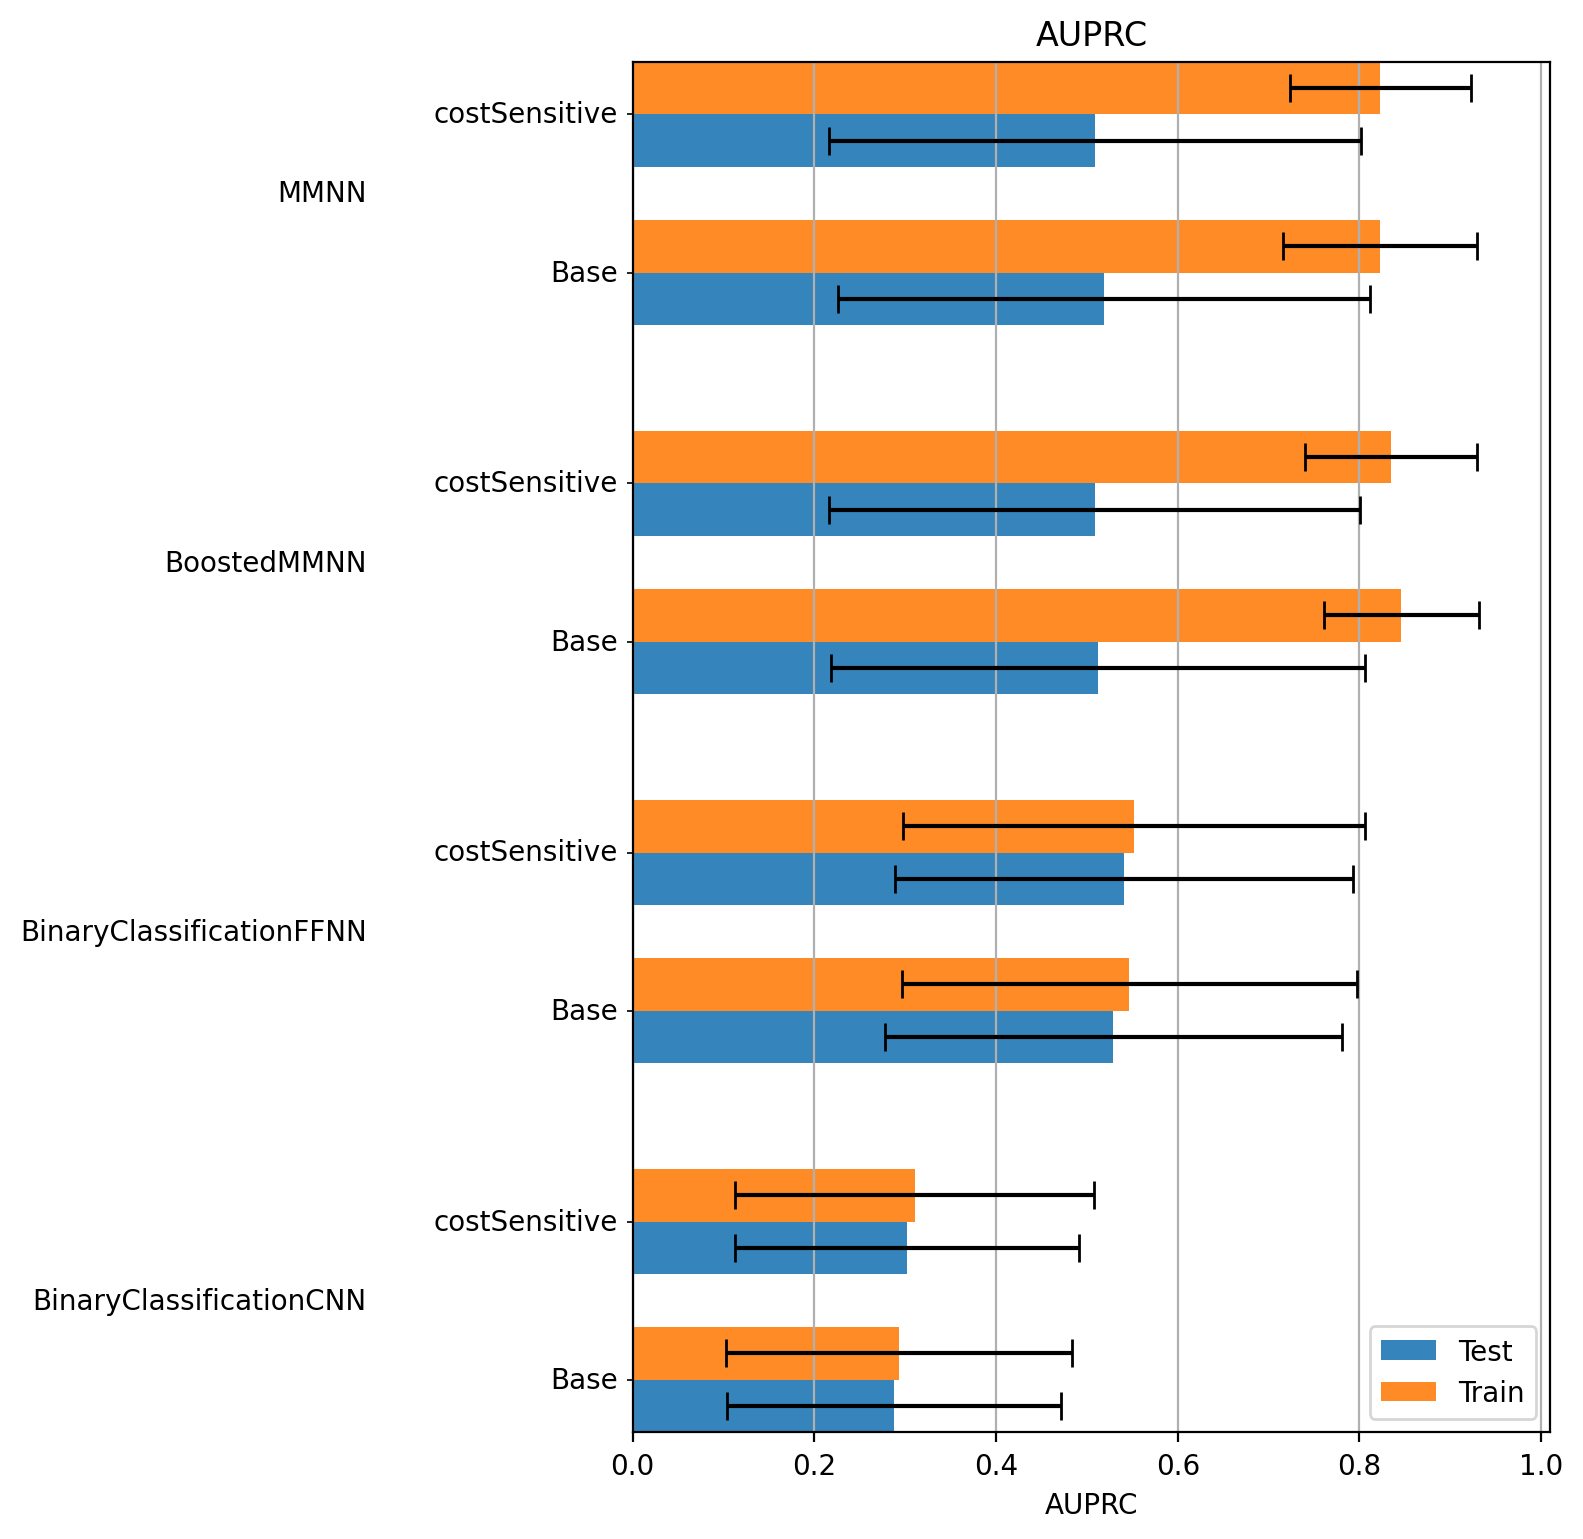

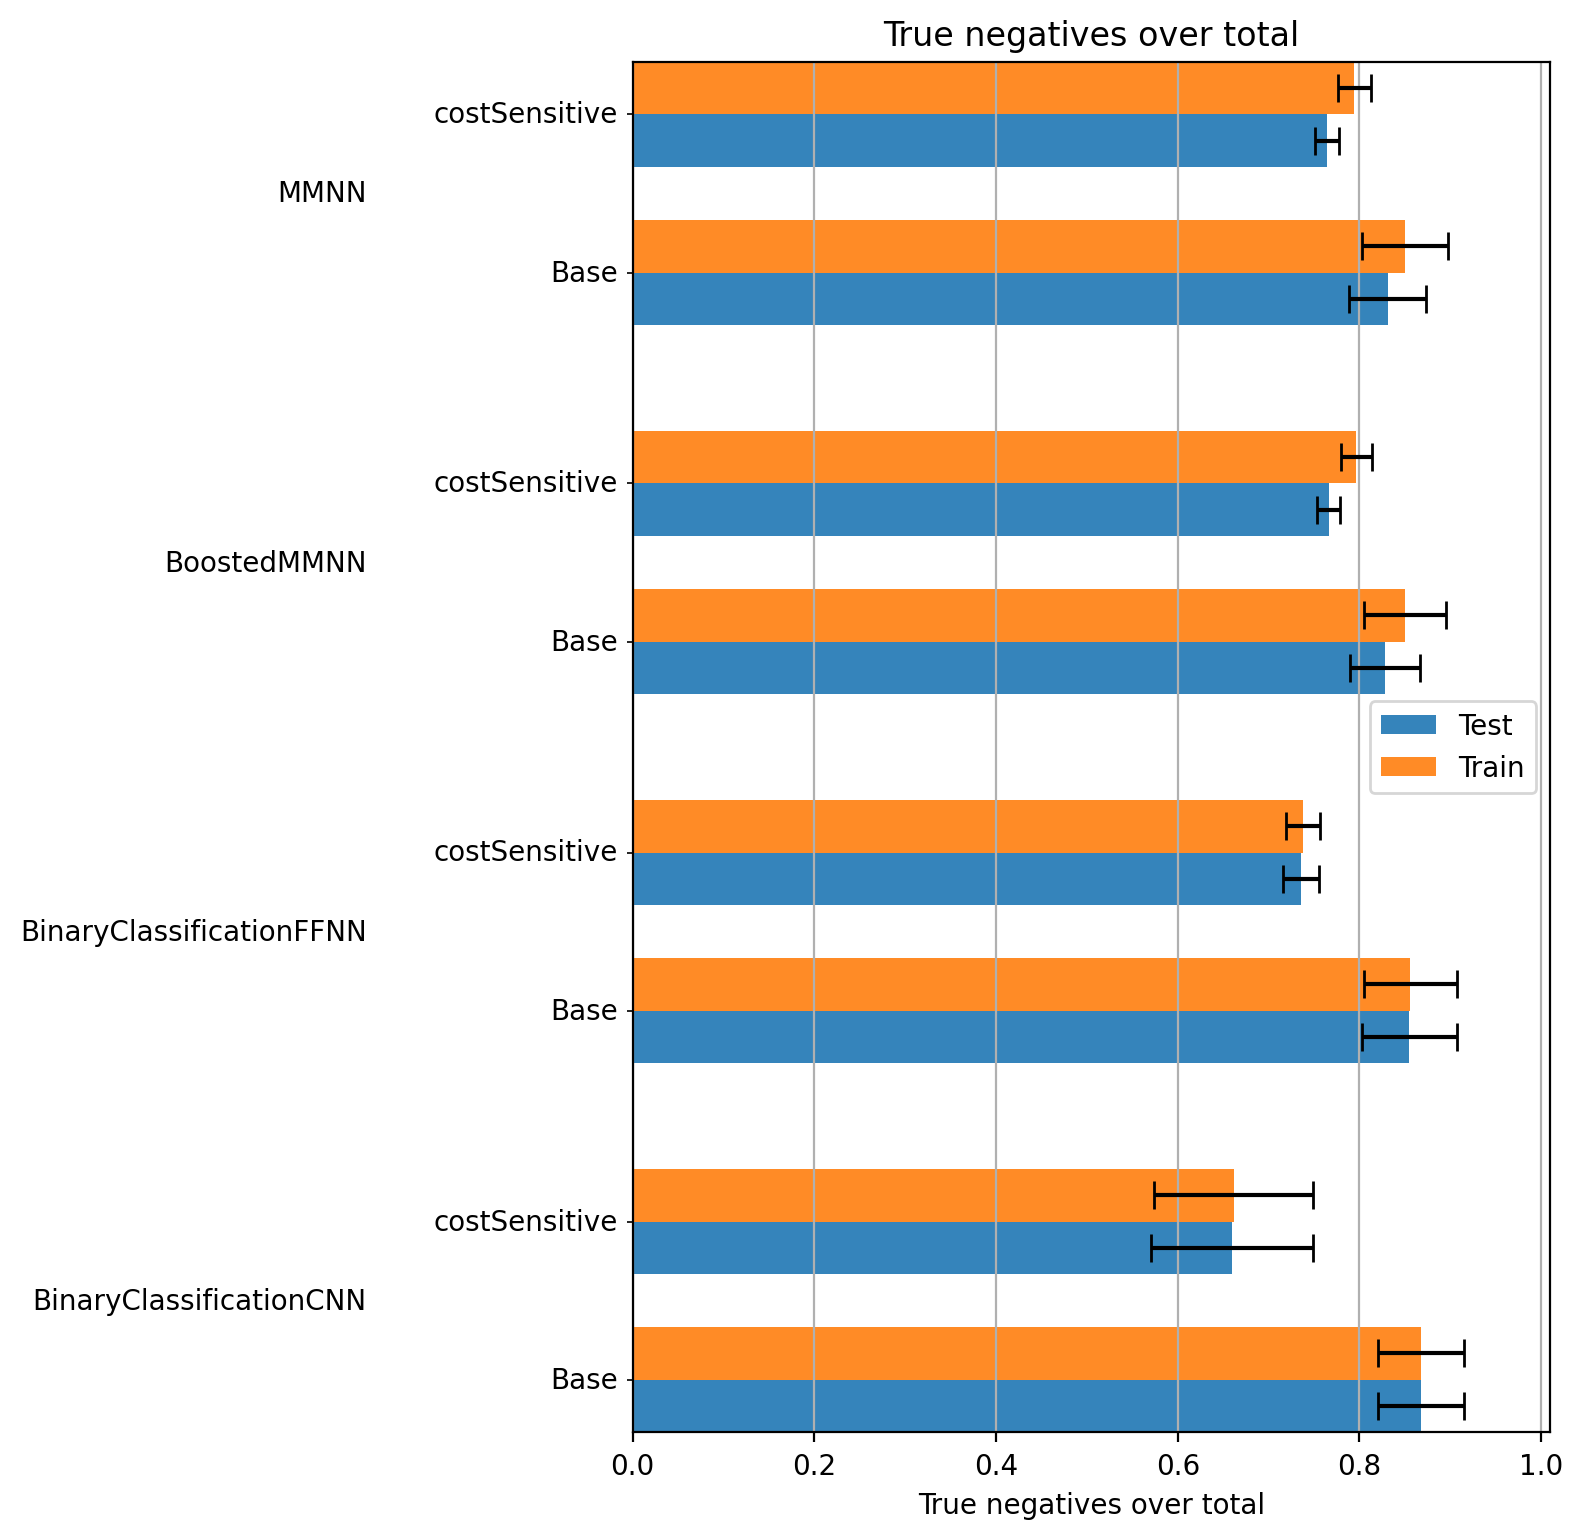

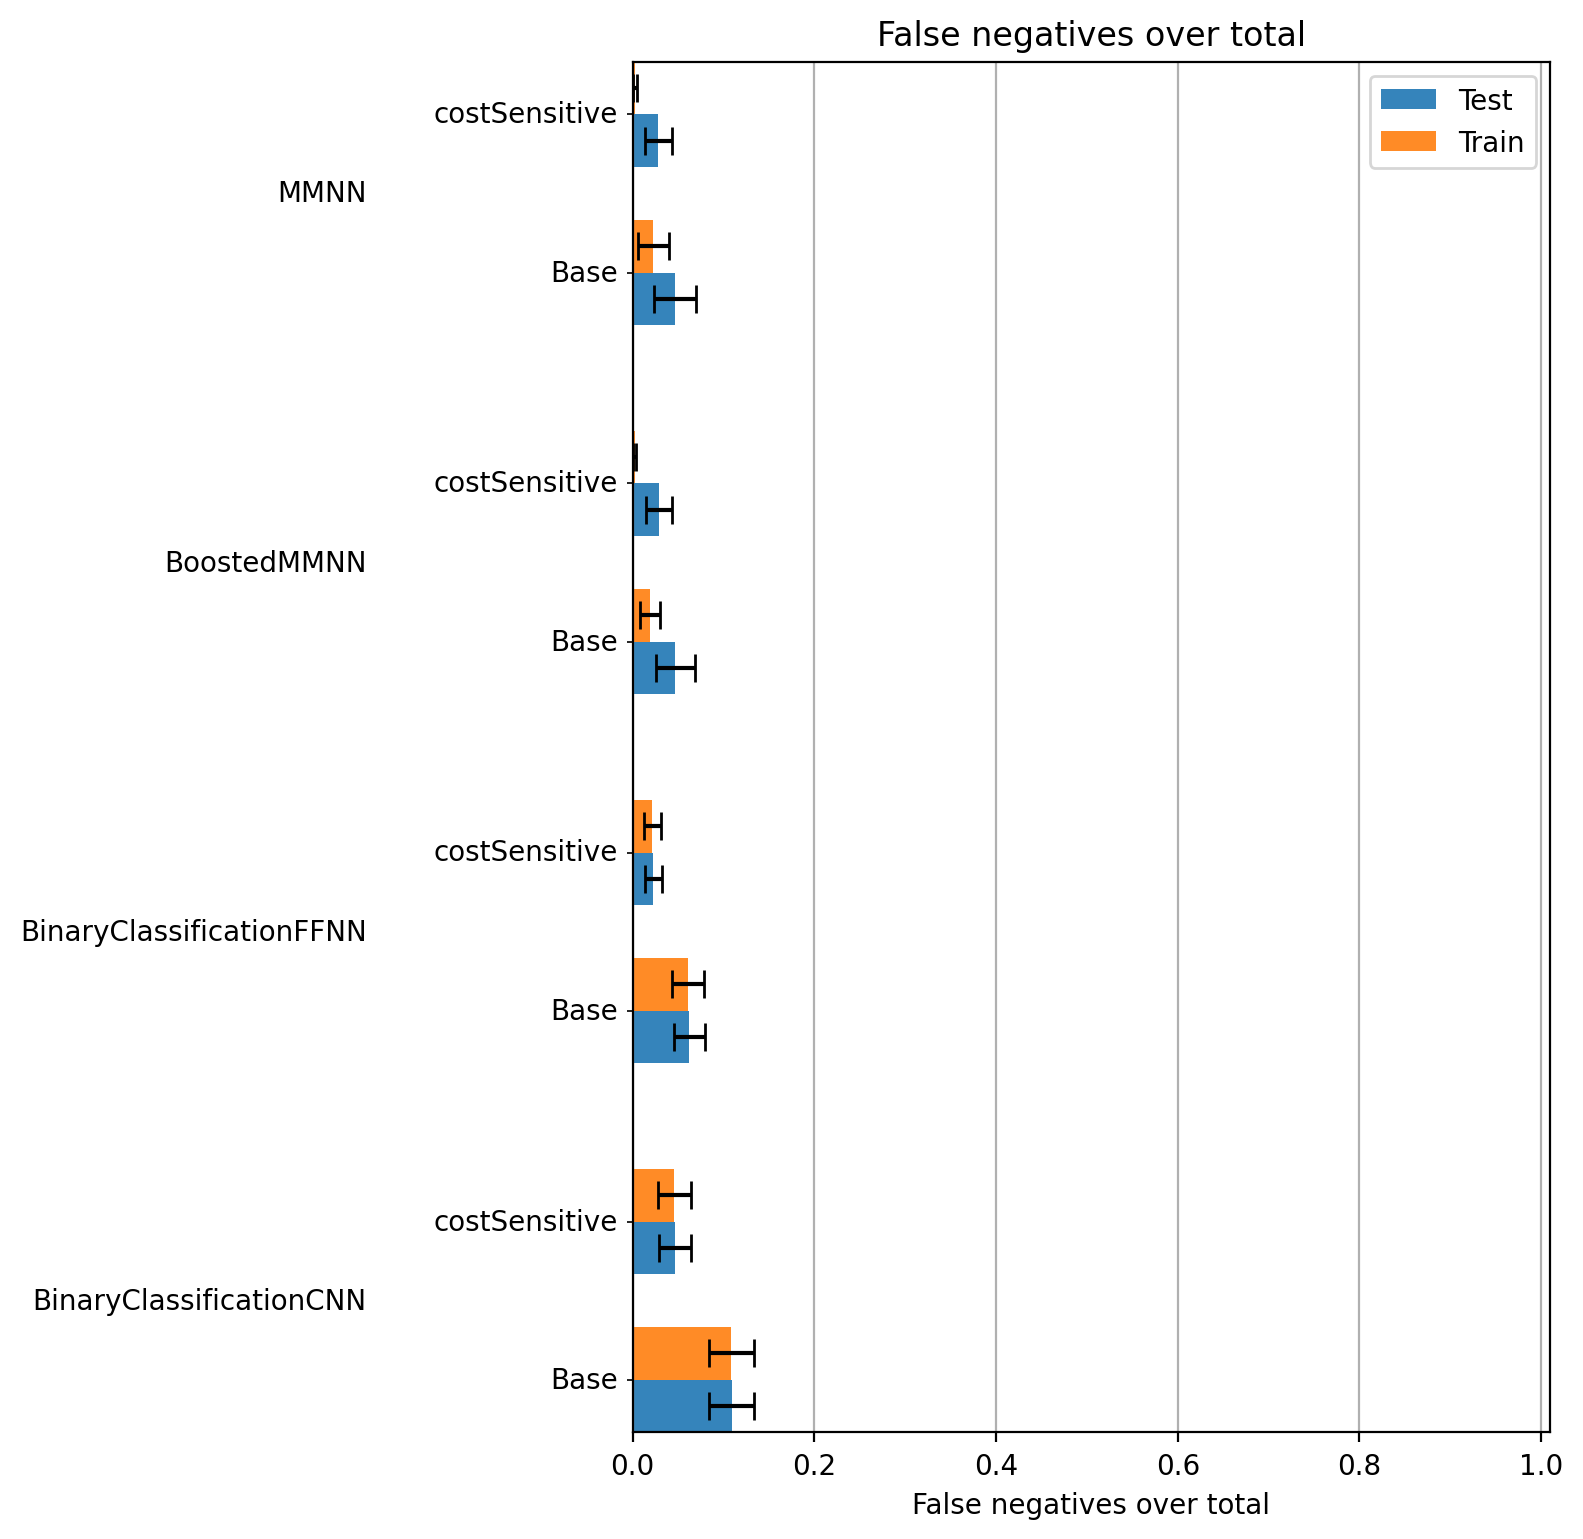

In [49]:
barplots(
    all_performances,
    groupby=["model_name", 'performance_type' , "run_type"],
    orientation="horizontal",
    height=8
)

## Wilcoxon test

In [50]:
from scipy.stats import wilcoxon
from IPython.display import Markdown, display

In [51]:
def printmd(string):
    display(Markdown(string))

In [71]:
for task in all_performances.task.unique():
    printmd('**'+task.upper()+'**')
    for model in all_performances.model_name.unique():
        base_model_performance = all_performances\
            [\
                (all_performances.task == task)\
                &(all_performances.model_name == model) \
                & (all_performances.run_type == "test") \
                & (all_performances.performance_type == 'base')\
            ]\

        
        costSensitive_model_performance = all_performances\
        [\
            (all_performances.task == task)\
            &(all_performances.model_name == model) \
            & (all_performances.run_type == "test")\
            & (all_performances.performance_type == 'costSensitive')\
        ]
        base_outperf_costSensitive = []
        costSensitive_outperf_base = []
        for metric in ('recall', 'AUROC', 'AUPRC', 'f1_score',
                       'balanced_accuracy'):
            base, costSensitive = base_model_performance[metric],\
                  costSensitive_model_performance[metric]
            _, p_value =  wilcoxon(base, costSensitive)
            if p_value < 0.01:
                if base.mean() > costSensitive.mean():
                    best_model, worst_model = model+'-base', model+'-costSensitive'
                    base_outperf_costSensitive.append((metric, p_value))
                else:
                    best_model, worst_model = model+'-costSensitive', model+'-base'
                    costSensitive_outperf_base.append((metric, p_value))
                #printmd("**The model {} outperformed the model {} with p_value {} on metric {}**".format(
                #    best_model, worst_model, p_value, metric)
                #     )
            else:
                print("The model {} is statistically indistinguishable from the model {} with p_value {} on metric {}".format(
                    model+'-base', model+'-costSensitive', p_value, metric)
                     )
        printmd("**{}**: The **base** model outperformed the **cost sensitive** model on these **{}** metrics: {}".format(
               model, len(base_outperf_costSensitive), base_outperf_costSensitive))
        printmd("**{}**: The **cost sensitive** model outperformed the **base** model on these **{}** metrics: {}".format(
               model, len(costSensitive_outperf_base), costSensitive_outperf_base))

**ENHANCERS**

**BinaryClassificationFFNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**BinaryClassificationFFNN**: The **cost sensitive** model outperformed the **base** model on these **5** metrics: [('recall', 0.001953125), ('AUROC', 0.001953125), ('AUPRC', 0.00390625), ('f1_score', 0.001953125), ('balanced_accuracy', 0.001953125)]

**BinaryClassificationCNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**BinaryClassificationCNN**: The **cost sensitive** model outperformed the **base** model on these **5** metrics: [('recall', 0.001953125), ('AUROC', 0.001953125), ('AUPRC', 0.001953125), ('f1_score', 0.001953125), ('balanced_accuracy', 0.001953125)]

The model MMNN-base is statistically indistinguishable from the model MMNN-costSensitive with p_value 0.064453125 on metric AUROC
The model MMNN-base is statistically indistinguishable from the model MMNN-costSensitive with p_value 0.16015625 on metric AUPRC


**MMNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**MMNN**: The **cost sensitive** model outperformed the **base** model on these **3** metrics: [('recall', 0.001953125), ('f1_score', 0.001953125), ('balanced_accuracy', 0.001953125)]

The model BoostedMMNN-base is statistically indistinguishable from the model BoostedMMNN-costSensitive with p_value 0.232421875 on metric AUROC
The model BoostedMMNN-base is statistically indistinguishable from the model BoostedMMNN-costSensitive with p_value 0.921875 on metric AUPRC


**BoostedMMNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**BoostedMMNN**: The **cost sensitive** model outperformed the **base** model on these **3** metrics: [('recall', 0.001953125), ('f1_score', 0.001953125), ('balanced_accuracy', 0.001953125)]

**PROMOTERS**

**BinaryClassificationFFNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**BinaryClassificationFFNN**: The **cost sensitive** model outperformed the **base** model on these **5** metrics: [('recall', 0.001953125), ('AUROC', 0.001953125), ('AUPRC', 0.001953125), ('f1_score', 0.001953125), ('balanced_accuracy', 0.001953125)]

**BinaryClassificationCNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**BinaryClassificationCNN**: The **cost sensitive** model outperformed the **base** model on these **5** metrics: [('recall', 0.001953125), ('AUROC', 0.001953125), ('AUPRC', 0.001953125), ('f1_score', 0.001953125), ('balanced_accuracy', 0.001953125)]

The model MMNN-base is statistically indistinguishable from the model MMNN-costSensitive with p_value 0.16015625 on metric AUROC


**MMNN**: The **base** model outperformed the **cost sensitive** model on these **2** metrics: [('AUPRC', 0.001953125), ('f1_score', 0.001953125)]

**MMNN**: The **cost sensitive** model outperformed the **base** model on these **2** metrics: [('recall', 0.001953125), ('balanced_accuracy', 0.001953125)]

The model BoostedMMNN-base is statistically indistinguishable from the model BoostedMMNN-costSensitive with p_value 0.6953125 on metric AUROC
The model BoostedMMNN-base is statistically indistinguishable from the model BoostedMMNN-costSensitive with p_value 0.01953125 on metric AUPRC
The model BoostedMMNN-base is statistically indistinguishable from the model BoostedMMNN-costSensitive with p_value 0.037109375 on metric f1_score


**BoostedMMNN**: The **base** model outperformed the **cost sensitive** model on these **0** metrics: []

**BoostedMMNN**: The **cost sensitive** model outperformed the **base** model on these **2** metrics: [('recall', 0.001953125), ('balanced_accuracy', 0.001953125)]